In [1]:
pip install pymupdf pdfplumber


Note: you may need to restart the kernel to use updated packages.


<h1>Data Preprocessing </h1>

<h3> Concatenate IGCSE data into single .csv </h3>

In [2]:
import os, re, glob
import pandas as pd

import fitz  # pymupdf

def extract_text_pymupdf(pdf_path: str) -> str:
    text_parts = []
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text_parts.append(page.get_text("text"))
    return "\n".join(text_parts).strip()


ROOT = r"C:\Users\Rizwana\Desktop\studyoclock project"

subjects = ["biology", "chemistry", "business", "ict"]
rows = []

for subj in subjects:
    folder = os.path.join(ROOT, subj)
    for pdf in glob.glob(os.path.join(folder, "*.pdf")):
        topic_name = os.path.splitext(os.path.basename(pdf))[0]
        raw_text = extract_text_pymupdf(pdf)
        rows.append({
            "subject": subj,
            "topic_name": topic_name,
            "raw_text": raw_text
        })

raw_df = pd.DataFrame(rows)
raw_df = raw_df.dropna(subset=["raw_text"])
raw_df = raw_df[raw_df["raw_text"].str.strip().astype(bool)]

raw_df.to_csv("raw_notes_from_pdfs.csv", index=False)
print("Built raw_notes_from_pdfs.csv with", len(raw_df), "rows")
raw_df.head()


Built raw_notes_from_pdfs.csv with 75 rows


,subject,topic_name,raw_text
0,biology,Unit 1 Characteristics and Classification of L...,Unit 1 Characteristics and Classification of L...
1,biology,Unit 10 Diseases and Immunity,Diseases and Immunity \nDisease \n• Pathogens ...
2,biology,Unit 11 Gas Exchange in Humans,Gas Exchange in Humans \nThe Gas Exchange Syst...
3,biology,Unit 12 Respiration,Respiration \nAerobic respiration \n• All ce...
4,biology,Unit 13 Excretion,Excretion \n \n• Excretion is the removal from...


<h3> Verification that data is sensible </h3>

In [4]:
raw_df.tail()

,subject,topic_name,raw_text
70,ict,4. Networks and the effects of using them,Networks and the effects of using them \n• A ...
71,ict,5. The effects of using ICT,The Effects of Using ICT \nThe effects of ICT...
72,ict,6. ICT Applications,ICT Applications \nCommunication applications ...
73,ict,7. Systems Analysis and Design,Systems Analysis and Design \n• It is a method...
74,ict,8.Safety and Security,Safety and Security \nPhysical Safety \nHealt...


<h3>Assignment of Difficulty Tags</h3>

In [5]:
import re
import pandas as pd
from transformers import pipeline, AutoTokenizer
from textstat import flesch_kincaid_grade, flesch_reading_ease
from tqdm import tqdm

df = pd.read_csv("raw_notes_from_pdfs.csv")

required = {"subject", "topic_name", "raw_text"}
if not required.issubset(df.columns):
    raise ValueError(f"CSV must contain {required}")

df = df.dropna(subset=["raw_text"]).copy()
df["word_count"] = df["raw_text"].apply(lambda x: len(str(x).split()))

tqdm.pandas()

model_name = "sshleifer/distilbart-cnn-12-6"
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarizer = pipeline("summarization", model=model_name, tokenizer=tokenizer, framework="pt")

def chunk_by_tokens(text, tokenizer, max_tokens=1024):
    sentences = re.split(r'(?<=[.!?]) +', str(text))
    chunks, cur = [], ""
    for s in sentences:
        cand = (cur + " " + s).strip()
        if len(tokenizer.encode(cand)) < max_tokens:
            cur = cand
        else:
            if cur: chunks.append(cur)
            cur = s
    if cur: chunks.append(cur)
    return chunks

def summarize_text(text):
    parts = chunk_by_tokens(text, tokenizer)
    outs = [summarizer(p, max_length=1000, min_length=40, truncation=True)[0]["summary_text"] for p in parts if p.strip()]
    return " ".join(outs)

if "summary_text" not in df.columns:
    df["summary_text"] = df["raw_text"].progress_apply(summarize_text)

def assign_difficulty(summary: str) -> str:
    grade = flesch_kincaid_grade(summary)
    ease  = flesch_reading_ease(summary)
    if grade <= 6 and ease >= 60:
        return "Easy"
    elif grade <= 10 and ease >= 40:
        return "Medium"
    else:
        return "Hard"

df["difficulty_level"] = df["summary_text"].apply(assign_difficulty)

df.to_csv("processed_notes.csv", index=False)
print("Saved processed_notes.csv with columns:", list(df.columns))
df.head()


Device set to use cpu
  0%|                                                                                                                       | 0/75 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (2263 > 1024). Running this sequence through the model will result in indexing errors
Your max_length is set to 1000, but your input_length is only 345. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=172)
Your max_length is set to 1000, but your input_length is only 219. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=109)
  3%|██▉                                                                                                            | 2/75 [00:18<11:20,  9.33s

Saved processed_notes.csv with columns: ['subject', 'topic_name', 'raw_text', 'word_count', 'summary_text', 'difficulty_level']


,subject,topic_name,raw_text,word_count,summary_text,difficulty_level
0,biology,Unit 1 Characteristics and Classification of L...,Unit 1 Characteristics and Classification of L...,1458,Living organisms are classified into 5 groups...,Medium
1,biology,Unit 10 Diseases and Immunity,Diseases and Immunity \nDisease \n• Pathogens ...,2059,Pathogens are organisms that cause diseases (...,Medium
2,biology,Unit 11 Gas Exchange in Humans,Gas Exchange in Humans \nThe Gas Exchange Syst...,937,The lungs are spongy organs found inside the ...,Hard
3,biology,Unit 12 Respiration,Respiration \nAerobic respiration \n• All ce...,589,All cells need energy provided by burning glu...,Hard
4,biology,Unit 13 Excretion,Excretion \n \n• Excretion is the removal from...,1274,Excretion is the removal from the body of the...,Hard


In [6]:
df.tail()

,subject,topic_name,raw_text,word_count,summary_text,difficulty_level
70,ict,4. Networks and the effects of using them,Networks and the effects of using them \n• A ...,3787,A computer network is developed by linking co...,Hard
71,ict,5. The effects of using ICT,The Effects of Using ICT \nThe effects of ICT...,540,Robots have replaced human workers in many ar...,Medium
72,ict,6. ICT Applications,ICT Applications \nCommunication applications ...,6582,Paper based communication used to inform peop...,Medium
73,ict,7. Systems Analysis and Design,Systems Analysis and Design \n• It is a method...,2172,Systems Analysis and Design is a method used ...,Hard
74,ict,8.Safety and Security,Safety and Security \nPhysical Safety \nHealt...,1280,Health and safety regulations advise that all...,Hard


<h1>Content Based Filtering</h1>

In [9]:
import os
from typing import List, Dict
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

class ContentRecommender:
    def __init__(self, processed_csv: str = "processed_notes.csv",
                 tfidf_kwargs: Dict = None):
        if not os.path.exists(processed_csv):
            raise FileNotFoundError(f"{processed_csv} not found")
        self.df = pd.read_csv(processed_csv)

        required = {"subject", "topic_name", "summary_text"}
        if not required.issubset(self.df.columns):
            raise ValueError(f"CSV must contain {required}")

        
        self.tfidf_kwargs = tfidf_kwargs or dict(
            stop_words="english", max_df=0.95, min_df=1, ngram_range=(1,2)
        )

        self.models = {}
        for subject, sub in self.df.groupby("subject"):
            sub = sub.reset_index(drop=True).copy()
            tfidf = TfidfVectorizer(**self.tfidf_kwargs)
            X = tfidf.fit_transform(sub["summary_text"])
            sim = cosine_similarity(X, X)
            index_by_topic = pd.Series(sub.index, index=sub["topic_name"]).drop_duplicates()
            self.models[subject] = dict(df=sub, tfidf=tfidf, X=X, sim=sim,
                                        index_by_topic=index_by_topic)

    def _m(self, subject: str):
        if subject not in self.models:
            raise ValueError(f"No data for subject '{subject}'")
        return self.models[subject]

    def find_topic(self, subject: str, pattern: str, top: int = 5) -> pd.DataFrame:
        m = self._m(subject)
        mask = m["df"]["topic_name"].str.contains(pattern, case=False, na=False)
        return m["df"][mask].head(top)[["topic_name"]]

    def recommend_like(self, subject: str, topic_name: str, k: int = 5) -> pd.DataFrame:
        m = self._m(subject)
        if topic_name not in m["index_by_topic"]:
            raise ValueError(f"Topic '{topic_name}' not found in {subject}.")
        idx = m["index_by_topic"][topic_name]
        sims = list(enumerate(m["sim"][idx]))
        sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:k+1]
        out = m["df"].iloc[[i for i,_ in sims]].copy()
        out["similarity"] = [s for _, s in sims]
        cols = ["topic_name", "similarity"]
        if "difficulty_level" in out.columns: cols.append("difficulty_level")
        return out[cols]

    def recommend_query(self, subject: str, query: str, k: int = 5) -> pd.DataFrame:
        m = self._m(subject)
        q_vec = m["tfidf"].transform([query])
        sims = linear_kernel(q_vec, m["X"]).ravel()
        top = sims.argsort()[::-1][:k]
        out = m["df"].iloc[top].copy()
        out["similarity"] = sims[top]
        cols = ["topic_name", "similarity"]
        if "difficulty_level" in out.columns: cols.append("difficulty_level")
        return out[cols]

    def recommend_from_profile(self, subject: str, liked_topics: List[str], k: int = 5) -> pd.DataFrame:
        m = self._m(subject)
        sub = m["df"]
        mask = sub["topic_name"].isin(liked_topics)
        idxs = np.where(mask.values)[0]
        if len(idxs) == 0:
            raise ValueError("None of the liked topics are in this subject.")
        # mean() returns a numpy.matrix; convert to 2D ndarray
        centroid = np.asarray(m["X"][idxs].mean(axis=0)).reshape(1, -1)
        sims = linear_kernel(centroid, m["X"]).ravel()
        # exclude liked topics
        candidates = ~mask.values
        cand_idx = np.where(candidates)[0]
        ranked = cand_idx[np.argsort(-sims[cand_idx])[:k]]
        out = sub.iloc[ranked].copy()
        out["similarity"] = sims[ranked]
        cols = ["topic_name", "similarity"]
        if "difficulty_level" in out.columns: cols.append("difficulty_level")
        return out[cols]




if __name__ == "__main__":
    rec = ContentRecommender(processed_csv="processed_notes.csv")

    
    def show(title, df):
        print(f"\n=== {title} ===")
        try:
            print(df.to_string(index=False))
        except Exception:
            print(df)

    #Locate exact topic names 
    show("Find Biology topics containing 'Respiration'", rec.find_topic("biology", "Respiration"))
    show("Find Chemistry topics containing 'Speed of Reaction'", rec.find_topic("chemistry", "Speed of Reaction"))
    show("Find Business topics containing 'Market Research'", rec.find_topic("business", "Market Research"))
    show("Find ICT topics containing 'Applications'", rec.find_topic("ict", "Applications"))

    # 1) Item to Item 
    # biology: "Unit 12 Respiration"
    try:
        show("Biology: more like 'Unit 12 Respiration'",
             rec.recommend_like("biology", "Unit 12 Respiration", k=5))
    except Exception as e:
        print("Biology example error:", e)

    # chemistry: "Unit 8 Speed of Reaction"
    try:
        show("Chemistry: more like 'Unit 8 Speed of Reaction'",
             rec.recommend_like("chemistry", "Unit 8 Speed of Reaction", k=5))
    except Exception as e:
        print("Chemistry example error:", e)

    # business: "Chapter 11-Market Research" 
    try:
        show("Business: more like 'Chapter 11-Market Research'",
             rec.recommend_like("business", "Chapter 11-Market Research", k=5))
    except Exception as e:
        print("Business example error:", e)

    # 2) Query to Items 
    show("ICT: query → 'computer networks and topologies'",
         rec.recommend_query("ict", "computer networks and topologies", k=5))

    show("Chemistry: query → 'stoichiometry mole calculations'",
         rec.recommend_query("chemistry", "stoichiometry mole calculations", k=5))

    # 3) Profile  to Items 
    bio_liked = ["Unit 5 Enzymes", "Unit 8 Plant Transport"] 
    try:
        show(f"Biology: profile from liked topics {bio_liked}",
             rec.recommend_from_profile("biology", bio_liked, k=5))
    except Exception as e:
        print("Biology profile example error:", e)

    chem_liked = ["Unit 13 Metals and Reactivity", "Unit 14 Metal Extraction"]
    try:
        show(f"Chemistry: profile from liked topics {chem_liked}",
             rec.recommend_from_profile("chemistry", chem_liked, k=5))
    except Exception as e:
        print("Chemistry profile example error:", e)



=== Find Biology topics containing 'Respiration' ===
         topic_name
Unit 12 Respiration

=== Find Chemistry topics containing 'Speed of Reaction' ===
              topic_name
Unit 8 Speed of Reaction

=== Find Business topics containing 'Market Research' ===
                topic_name
Chapter 11-Market Research

=== Find ICT topics containing 'Applications' ===
         topic_name
6. ICT Applications

=== Biology: more like 'Unit 12 Respiration' ===
                             topic_name  similarity difficulty_level
                 Unit 6 Plant Nutrition    0.056429             Hard
                         Unit 5 Enzymes    0.046207             Hard
Unit 19 Organisms and their environment    0.038062             Hard
    Unit 3 Movement in and out of cells    0.033983           Medium
                Unit 7 Animal Nutrition    0.031785             Hard

=== Chemistry: more like 'Unit 8 Speed of Reaction' ===
                   topic_name  similarity difficulty_level
    Unit 9

In [10]:
import os
from typing import List, Dict
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel


class ContentRecommender:
    def __init__(self, processed_csv: str = "processed_notes.csv",
                 tfidf_kwargs: Dict = None):
        if not os.path.exists(processed_csv):
            raise FileNotFoundError(f"{processed_csv} not found")
        self.df = pd.read_csv(processed_csv)

        required = {"subject", "topic_name", "summary_text"}
        if not required.issubset(self.df.columns):
            raise ValueError(f"CSV must contain {required}")

        # keep rare terms; add bigrams; scale tf; allow long docs
        self.tfidf_kwargs = tfidf_kwargs or dict(
            stop_words="english",
            max_df=0.95,
            min_df=1,
            ngram_range=(1, 2),
            sublinear_tf=True
        )

        self.models = {}
        for subject, sub in self.df.groupby("subject"):
            sub = sub.reset_index(drop=True).copy()

            #combine title and summary for stronger signals
            sub["text_for_tfidf"] = (
                sub["topic_name"].fillna("") + " " + sub["summary_text"].fillna("")
            )

            tfidf = TfidfVectorizer(**self.tfidf_kwargs)
            X = tfidf.fit_transform(sub["text_for_tfidf"])
            sim = cosine_similarity(X, X)
            index_by_topic = pd.Series(sub.index, index=sub["topic_name"]).drop_duplicates()

            self.models[subject] = dict(
                df=sub, tfidf=tfidf, X=X, sim=sim, index_by_topic=index_by_topic
            )

    def _m(self, subject: str):
        if subject not in self.models:
            raise ValueError(f"No data for subject '{subject}'")
        return self.models[subject]

    def find_topic(self, subject: str, pattern: str, top: int = 5) -> pd.DataFrame:
        """Case-insensitive partial match over topic_name."""
        m = self._m(subject)
        mask = m["df"]["topic_name"].str.contains(pattern, case=False, na=False)
        return m["df"][mask].head(top)[["topic_name"]]

    #Item to Item
    def recommend_like(self, subject: str, topic_name: str, k: int = 5) -> pd.DataFrame:
        m = self._m(subject)
        if topic_name not in m["index_by_topic"]:
            raise ValueError(
                f"Topic '{topic_name}' not found in {subject}. "
                f"Try rec.find_topic('{subject}', '<part of title>')."
            )
        idx = m["index_by_topic"][topic_name]
        sims = list(enumerate(m["sim"][idx]))
        sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:k+1]
        out = m["df"].iloc[[i for i, _ in sims]].copy()
        out["similarity"] = [s for _, s in sims]
        cols = ["topic_name", "similarity"]
        if "difficulty_level" in out.columns:
            cols.append("difficulty_level")
        return out[cols]

    #Query to Item
    def recommend_query(self, subject: str, query: str, k: int = 5) -> pd.DataFrame:
        m = self._m(subject)
        q_vec = m["tfidf"].transform([query])
        sims = linear_kernel(q_vec, m["X"]).ravel()
        top = sims.argsort()[::-1][:k]
        out = m["df"].iloc[top].copy()
        out["similarity"] = sims[top]
        cols = ["topic_name", "similarity"]
        if "difficulty_level" in out.columns:
            cols.append("difficulty_level")
        return out[cols]

    #Liked Topics to Items
    def recommend_from_profile(self, subject: str, liked_topics: List[str], k: int = 5) -> pd.DataFrame:
        m = self._m(subject)
        sub = m["df"]
        mask = sub["topic_name"].isin(liked_topics)
        idxs = np.where(mask.values)[0]
        if len(idxs) == 0:
            raise ValueError("None of the liked topics are in this subject.")
        # convert to ndarray row vector to avoid np.matrix issues
        centroid = np.asarray(m["X"][idxs].mean(axis=0)).reshape(1, -1)
        sims = linear_kernel(centroid, m["X"]).ravel()
        # exclude liked topics
        candidates = ~mask.values
        cand_idx = np.where(candidates)[0]
        ranked = cand_idx[np.argsort(-sims[cand_idx])[:k]]
        out = sub.iloc[ranked].copy()
        out["similarity"] = sims[ranked]
        cols = ["topic_name", "similarity"]
        if "difficulty_level" in out.columns:
            cols.append("difficulty_level")
        return out[cols]


#Verification
if __name__ == "__main__":
    rec = ContentRecommender(processed_csv="processed_notes.csv")

    def show(title, df):
        print(f"\n=== {title} ===")
        try:
            print(df.to_string(index=False))
        except Exception:
            print(df)

    #Helpers to confirm exact titles present
    show("Find Biology topics containing 'Respiration'", rec.find_topic("biology", "Respiration"))
    show("Find Chemistry topics containing 'Speed of Reaction'", rec.find_topic("chemistry", "Speed of Reaction"))
    show("Find Business topics containing 'Market Research'", rec.find_topic("business", "Market Research"))
    show("Find ICT topics containing 'Applications'", rec.find_topic("ict", "Applications"))

    #Item to Item
    try:
        show("Biology: more like 'Unit 12 Respiration'",
             rec.recommend_like("biology", "Unit 12 Respiration", k=5))
    except Exception as e:
        print("Biology example error:", e)

    try:
        show("Chemistry: more like 'Unit 8 Speed of Reaction'",
             rec.recommend_like("chemistry", "Unit 8 Speed of Reaction", k=5))
    except Exception as e:
        print("Chemistry example error:", e)

    try:
        show("Business: more like 'Chapter 11-Market Research'",
             rec.recommend_like("business", "Chapter 11-Market Research", k=5))
    except Exception as e:
        print("Business example error:", e)

    #Query to Items
    show("ICT: query → 'computer networks and topologies'",
         rec.recommend_query("ict", "computer networks topologies data transmission", k=5))

    chem_query = "stoichiometry mole calculations reacting masses molar mass empirical formula"
    show("Chemistry: query → 'stoichiometry ...'",
         rec.recommend_query("chemistry", chem_query, k=5))

    #Profile to Items
    bio_liked = ["Unit 5 Enzymes", "Unit 8 Plant Transport"]
    try:
        show(f"Biology: profile from liked topics {bio_liked}",
             rec.recommend_from_profile("biology", bio_liked, k=5))
    except Exception as e:
        print("Biology profile example error:", e)

    chem_liked = ["Unit 13 Metals and Reactivity", "Unit 14 Metal Extraction"]
    try:
        show(f"Chemistry: profile from liked topics {chem_liked}",
             rec.recommend_from_profile("chemistry", chem_liked, k=5))
    except Exception as e:
        print("Chemistry profile example error:", e)


=== Find Biology topics containing 'Respiration' ===
         topic_name
Unit 12 Respiration

=== Find Chemistry topics containing 'Speed of Reaction' ===
              topic_name
Unit 8 Speed of Reaction

=== Find Business topics containing 'Market Research' ===
                topic_name
Chapter 11-Market Research

=== Find ICT topics containing 'Applications' ===
         topic_name
6. ICT Applications

=== Biology: more like 'Unit 12 Respiration' ===
                             topic_name  similarity difficulty_level
                 Unit 6 Plant Nutrition    0.056465             Hard
                         Unit 5 Enzymes    0.037409             Hard
    Unit 3 Movement in and out of cells    0.035064           Medium
                           Unit 2 Cells    0.024262           Medium
Unit 19 Organisms and their environment    0.023323             Hard

=== Chemistry: more like 'Unit 8 Speed of Reaction' ===
                       topic_name  similarity difficulty_level
      

<h1>Collaborative Filtering</h1>

In [11]:
import os
import numpy as np
import pandas as pd
from typing import Optional
from sklearn.metrics.pairwise import cosine_similarity

#load in synthetic data
if not os.path.exists("processed_notes.csv"):
    raise FileNotFoundError("processed_notes.csv not found.")

topics = pd.read_csv("processed_notes.csv")
req = {"subject", "topic_name"}
if not req.issubset(topics.columns):
    raise ValueError(f"processed_notes.csv must contain {req}")

#Clean duplicates
topics = topics.dropna(subset=["subject", "topic_name"]).drop_duplicates(subset=["subject","topic_name"]).reset_index(drop=True)

#Synthetic interactions generator
rng = np.random.default_rng(7)

subjects = topics["subject"].unique().tolist()


N_USERS = 60

rows = []
for user in range(1, N_USERS + 1):
    #Each user has a primary subject bias
    main_subj = rng.choice(subjects)
    # number of interactions this user makes
    n_interactions = rng.integers(8, 16)  # 8-15 interactions

    #choose subjects with a higher prob on the main subject
    subj_choices = rng.choice(
        subjects,
        size=n_interactions,
        p=[0.55 if s == main_subj else (0.45/(len(subjects)-1)) for s in subjects]
    )

    for subj in subj_choices:
        pool = topics[topics["subject"] == subj]["topic_name"].values
        if len(pool) == 0:
            continue
        topic = rng.choice(pool)

        #rating pattern: biased a bit higher for the main subject
        base = 0.6 if subj == main_subj else 0.4
        # skew ratings to 3-5 range mostly
        prob_1 = 0.02 * (1-base)
        prob_2 = 0.08 * (1-base)
        prob_3 = 0.30 + 0.10*base
        prob_4 = 0.35 + 0.15*base
        prob_5 = 1.0 - (prob_1 + prob_2 + prob_3 + prob_4)
        rating = rng.choice([1,2,3,4,5], p=[prob_1, prob_2, prob_3, prob_4, prob_5])

        rows.append((user, subj, topic, int(rating)))

interactions = pd.DataFrame(rows, columns=["user_id", "subject", "topic_name", "rating"]).drop_duplicates()
interactions.to_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\Sample_Interactions_Data.csv", index=False)
print(f"Saved interactions.csv with {len(interactions)} rows and {interactions['user_id'].nunique()} users.")


#Collaborative Filtering helpers (User–User and Item–Item)

def _pivot_by_subject(interactions_df: pd.DataFrame, subject: str) -> pd.DataFrame:
    """User–Item matrix for a single subject."""
    sub = interactions_df[interactions_df["subject"] == subject].copy()
    if sub.empty:
        raise ValueError(f"No interactions for subject='{subject}'")
    pivot = sub.pivot_table(index="user_id", columns="topic_name", values="rating")
    return pivot

def user_user_recommend(
    interactions_df: pd.DataFrame,
    subject: str,
    user_id: int,
    top_n: int = 5
) -> pd.DataFrame:
    """
    Recommend topics for user_id in a subject using User–User CF.
    Cosine similarity over users; aggregate neighbors' ratings.
    Returns: DataFrame[topic_name, score]
    """
    pivot = _pivot_by_subject(interactions_df, subject)
    if user_id not in pivot.index:
        raise ValueError(f"user_id {user_id} has no interactions in subject '{subject}'")

    #similarities between users
    sim = cosine_similarity(pivot.fillna(0))
    sim_df = pd.DataFrame(sim, index=pivot.index, columns=pivot.index)

    #candidate topics = not rated by user yet
    user_rated = set(interactions_df[(interactions_df["user_id"] == user_id) &
                                     (interactions_df["subject"] == subject)]["topic_name"])
    rec_scores = {}

    #weight neighbors' ratings by similarity
    neighbors = sim_df[user_id].sort_values(ascending=False).drop(user_id)
    for other_id, s in neighbors.items():
        other_row = pivot.loc[other_id]
        for topic, r in other_row.dropna().items():
            if topic in user_rated:
                continue
            rec_scores[topic] = rec_scores.get(topic, 0.0) + s * r

    if not rec_scores:
        return pd.DataFrame(columns=["topic_name","score"])

    ranked = sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(ranked, columns=["topic_name","score"])


def item_item_recommend(
    interactions_df: pd.DataFrame,
    subject: str,
    topic_name: str,
    top_n: int = 5
) -> pd.DataFrame:
    """
    Recommend similar topics (Item–Item CF) inside a subject using cosine
    similarity of item rating vectors.
    Returns: DataFrame[topic_name, similarity]
    """
    pivot = _pivot_by_subject(interactions_df, subject)
    if topic_name not in pivot.columns:
        raise ValueError(f"Topic '{topic_name}' has no ratings in subject '{subject}'")

    sim = cosine_similarity(pivot.T.fillna(0))
    sim_df = pd.DataFrame(sim, index=pivot.columns, columns=pivot.columns)

    sims = sim_df[topic_name].sort_values(ascending=False).drop(topic_name).head(top_n)
    return pd.DataFrame({"topic_name": sims.index, "similarity": sims.values})

#biology and chemistry example for verification

print("\n--- Example: User–User CF (biology) ---")
try:
    u_example = interactions[interactions["subject"]=="biology"]["user_id"].iloc[0]
    print("user_id:", u_example)
    print(user_user_recommend(interactions, "biology", user_id=u_example, top_n=5))
except Exception as e:
    print("User–User example error:", e)

print("\n--- Example: Item–Item CF (chemistry) ---")
try:
    # pick a chemistry topic that appears in interactions
    chem_topic = interactions[interactions["subject"]=="chemistry"]["topic_name"].iloc[0]
    print("topic:", chem_topic)
    print(item_item_recommend(interactions, "chemistry", topic_name=chem_topic, top_n=5))
except Exception as e:
    print("Item–Item example error:", e)



Saved interactions.csv with 648 rows and 60 users.

--- Example: User–User CF (biology) ---
user_id: 1
                               topic_name     score
0         Unit 18 Variation and selection  8.365624
1                     Unit 12 Respiration  7.030872
2  Unit 21 Human Influences on Ecosystems  4.468643
3                          Unit 5 Enzymes  3.555991
4                     Unit 17 Inheritance  2.451482

--- Example: Item–Item CF (chemistry) ---
topic: Unit 6 Electrcity and Chemistry
                                     topic_name  similarity
0      Unit 18 The Variety of Organic Chemicals    0.341972
1  Unit 17 Organic chemistry and petrochemicals    0.222744
2             Unit 1 Particles and Purification    0.216192
3                 Unit 16 The Chemical Industry    0.197579
4                 Unit 13 Metals and Reactivity    0.165256


<h1>Traing the BiLSTM</h1>

<p>Training each subject individually</p>

In [2]:
#biology 

import os, pickle, random
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#configuration
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

CSV_PATH     = r"C:\Users\Rizwana\Desktop\studyoclock project\Sample_Interactions_Data.csv"
SUBJECT      = "biology"
MODELS_DIR   = "models"
DEVICE       = "cpu"                 

MIN_SEQ_LEN  = 4                     
MAX_HIST_LEN = 50
BATCH_SIZE   = 64
EPOCHS       = 8
LR           = 1e-3
TOPK         = 5

#utilities
def load_interactions(path: str) -> pd.DataFrame:
    if not os.path.exists(path): raise FileNotFoundError(path)
    df = pd.read_csv(path)
    need = {"user_id","subject","topic_name","rating"}
    if not need.issubset(df.columns): raise ValueError(f"{path} must contain {need}")
    if "timestamp" not in df.columns:
        df = df.copy()
        df["timestamp"] = df.groupby(["user_id","subject"]).cumcount()
    return df

def build_vocab_sequences(df_subj: pd.DataFrame) -> Tuple[Dict[str,int], Dict[int,str], List[Tuple[int,List[int]]]]:
    df_subj = df_subj.sort_values(["user_id","timestamp"])
    topics = df_subj["topic_name"].unique().tolist()
    topic2id = {t:i+1 for i,t in enumerate(topics)}  # 0=PAD
    id2topic = {i:t for t,i in topic2id.items()}
    sequences = []
    for uid, g in df_subj.groupby("user_id"):
        seq = [topic2id[t] for t in g["topic_name"].tolist()]
        if len(seq) >= MIN_SEQ_LEN:
            sequences.append((uid, seq))
    return topic2id, id2topic, sequences

def make_next_pairs(sequences: List[Tuple[int,List[int]]]):
    X, y = [], []
    for _, seq in sequences:
        for t in range(1, len(seq)):
            hist = seq[max(0, t - MAX_HIST_LEN):t]
            if hist:
                X.append(hist); y.append(seq[t])
    return X, y

def pad_batch(seqs: List[List[int]], pad_id=0):
    L = max(len(s) for s in seqs)
    arr = np.zeros((len(seqs), L), dtype=np.int64)
    lens = np.array([len(s) for s in seqs], dtype=np.int64)
    for i,s in enumerate(seqs): arr[i,:len(s)] = s
    x = torch.tensor(arr); lengths = torch.tensor(lens)
    mask = (x != pad_id).float()
    return x, lengths, mask

class NextDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

def collate_fn(batch, pad_id=0):
    seqs, targets = zip(*batch)
    x, lengths, mask = pad_batch(seqs, pad_id)
    y = torch.tensor(targets, dtype=torch.long)
    return x, lengths, mask, y

#model building
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    def forward(self, H, mask):
        scores = self.v(torch.tanh(self.W(H))).squeeze(-1)   # (B,T)
        scores = scores.masked_fill(mask == 0, -1e9)
        alpha  = torch.softmax(scores, dim=-1)               # (B,T)
        ctx    = torch.bmm(alpha.unsqueeze(1), H).squeeze(1) # (B,H)
        return ctx, alpha

class BiLSTMAttnRec(nn.Module):
    def __init__(self, num_items, emb_dim=64, hidden_dim=128, pad_id=0):
        super().__init__()
        self.emb  = nn.Embedding(num_items+1, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, batch_first=True, bidirectional=True)
        self.attn = AdditiveAttention(hidden_dim)
        self.drop = nn.Dropout(0.2)
        self.out  = nn.Linear(hidden_dim, num_items+1)
    def forward(self, x, lengths, mask):
        E = self.emb(x)              # (B,T,E)
        H, _ = self.lstm(E)          # (B,T,H)
        ctx, _ = self.attn(H, mask)  # (B,H)
        z = self.drop(ctx)
        logits = self.out(z)         # (B,V)
        return logits

#train and save
def train_biology():
    df = load_interactions(CSV_PATH)
    bio = df[df["subject"] == SUBJECT].copy()
    if bio.empty: raise ValueError("No biology rows in interactions.csv")
    if bio["user_id"].nunique() < 5:
        print("[biology] Few users detected; training anyway.")

    topic2id, id2topic, sequences = build_vocab_sequences(bio)
    if not sequences:
        raise ValueError("No biology sequences with length ≥ MIN_SEQ_LEN")

    X, y = make_next_pairs(sequences)
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)
    train_loader = DataLoader(NextDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(NextDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = BiLSTMAttnRec(num_items=len(topic2id)).to(DEVICE)
    crit  = nn.CrossEntropyLoss(ignore_index=0)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR)

    for ep in range(1, EPOCHS+1):
        model.train(); tloss=0
        for x,l,m,yb in train_loader:
            x,l,m,yb = x.to(DEVICE), l.to(DEVICE), m.to(DEVICE), yb.to(DEVICE)
            logits = model(x,l,m)
            loss = crit(logits, yb)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tloss += loss.item()*x.size(0)

        #        model.eval(); vloss=0
        with torch.no_grad():
            for x,l,m,yb in val_loader:
                x,l,m,yb = x.to(DEVICE), l.to(DEVICE), m.to(DEVICE), yb.to(DEVICE)
                vloss += crit(model(x,l,m), yb).item()*x.size(0)
        print(f"[biology] Epoch {ep:02d}  train_loss={tloss/len(Xtr):.4f}  val_loss={vloss/len(Xva):.4f}")

    os.makedirs(MODELS_DIR, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(MODELS_DIR, "bilstm_biology.pt"))
    with open(os.path.join(MODELS_DIR, "topic2id_biology.pkl"), "wb") as f: pickle.dump(topic2id, f)
    with open(os.path.join(MODELS_DIR, "id2topic_biology.pkl"), "wb") as f: pickle.dump(id2topic, f)
    print("[biology] Saved model + vocab to models/")

    
    example_hist = list(topic2id.keys())[:3]
    recs = recommend_next("biology", example_hist, already_seen=example_hist, top_n=TOPK)
    print("\nDemo history:", example_hist)
    print("Top-N next topics:", recs)

#Inference 
def load_biology_model():
    t2i_p = os.path.join(MODELS_DIR, "topic2id_biology.pkl")
    i2t_p = os.path.join(MODELS_DIR, "id2topic_biology.pkl")
    m_p   = os.path.join(MODELS_DIR, "bilstm_biology.pt")
    if not (os.path.exists(t2i_p) and os.path.exists(i2t_p) and os.path.exists(m_p)):
        raise FileNotFoundError("Train biology first to create model + mappings in models/")
    with open(t2i_p, "rb") as f: topic2id = pickle.load(f)
    with open(i2t_p, "rb") as f: id2topic = pickle.load(f)
    model = BiLSTMAttnRec(num_items=len(topic2id)).to(DEVICE)
    model.load_state_dict(torch.load(m_p, map_location=DEVICE))
    model.eval()
    return model, topic2id, id2topic

def recommend_next(subject: str, history_topics: List[str], already_seen: List[str] = None, top_n: int = 5):
    assert subject == "biology", "This script is biology-only."
    model, topic2id, id2topic = load_biology_model()
    ids = [topic2id[t] for t in history_topics if t in topic2id]
    if not ids: return []
    x = torch.tensor([ids], dtype=torch.long).to(DEVICE)
    lengths = torch.tensor([len(ids)], dtype=torch.long).to(DEVICE)
    mask = (x != 0).float()
    with torch.no_grad():
        logits = model(x, lengths, mask)
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
    seen = set(already_seen or [])
    cands = [(tid,p) for tid,p in enumerate(probs) if tid!=0 and id2topic.get(tid) not in seen]
    cands.sort(key=lambda x: x[1], reverse=True)
    return [(id2topic[tid], float(p)) for tid,p in cands[:top_n]]


if __name__ == "__main__":
    train_biology()

[biology] Epoch 01  train_loss=3.0865  val_loss=3.0691
[biology] Epoch 02  train_loss=3.0623  val_loss=3.0731
[biology] Epoch 03  train_loss=3.0476  val_loss=3.0756
[biology] Epoch 04  train_loss=3.0311  val_loss=3.0777
[biology] Epoch 05  train_loss=3.0125  val_loss=3.0791
[biology] Epoch 06  train_loss=2.9944  val_loss=3.0786
[biology] Epoch 07  train_loss=2.9861  val_loss=3.0767
[biology] Epoch 08  train_loss=2.9712  val_loss=3.0756
[biology] Saved model + vocab to models/

Demo history: ['Unit 13 Excretion', 'Unit 3 Movement in and out of cells', 'Unit 21 Human Influences on Ecosystems']
Top-N next topics: [('Unit 18 Variation and selection', 0.0549352653324604), ('Unit 12 Respiration', 0.050515495240688324), ('Unit 6 Plant Nutrition', 0.05047224089503288), ('Unit 10 Diseases and Immunity', 0.05010153353214264), ('Unit 8 Plant Transport', 0.04774574562907219)]


In [4]:
#chemistry 

import os, pickle, random
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#configuration
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

CSV_PATH     = r"C:\Users\Rizwana\Desktop\studyoclock project\Sample_Interactions_Data.csv"   
SUBJECT      = "chemistry"
MODELS_DIR   = "models"
DEVICE       = "cpu"                

MIN_SEQ_LEN  = 4                    
MAX_HIST_LEN = 50
BATCH_SIZE   = 64
EPOCHS       = 8
LR           = 1e-3
TOPK         = 5

#utilities
def load_interactions(path: str) -> pd.DataFrame:
    if not os.path.exists(path): raise FileNotFoundError(path)
    df = pd.read_csv(path)
    need = {"user_id","subject","topic_name","rating"}
    if not need.issubset(df.columns): raise ValueError(f"{path} must contain {need}")
    if "timestamp" not in df.columns:
        df = df.copy()
        df["timestamp"] = df.groupby(["user_id","subject"]).cumcount()
    return df

def build_vocab_sequences(df_subj: pd.DataFrame) -> Tuple[Dict[str,int], Dict[int,str], List[Tuple[int,List[int]]]]:
    df_subj = df_subj.sort_values(["user_id","timestamp"])
    topics = df_subj["topic_name"].unique().tolist()
    topic2id = {t:i+1 for i,t in enumerate(topics)}  # 0=PAD
    id2topic = {i:t for t,i in topic2id.items()}
    sequences = []
    for uid, g in df_subj.groupby("user_id"):
        seq = [topic2id[t] for t in g["topic_name"].tolist()]
        if len(seq) >= MIN_SEQ_LEN:
            sequences.append((uid, seq))
    return topic2id, id2topic, sequences

def make_next_pairs(sequences: List[Tuple[int,List[int]]]):
    X, y = [], []
    for _, seq in sequences:
        for t in range(1, len(seq)):
            hist = seq[max(0, t - MAX_HIST_LEN):t]
            if hist:
                X.append(hist); y.append(seq[t])
    return X, y

def pad_batch(seqs: List[List[int]], pad_id=0):
    L = max(len(s) for s in seqs)
    arr = np.zeros((len(seqs), L), dtype=np.int64)
    lens = np.array([len(s) for s in seqs], dtype=np.int64)
    for i,s in enumerate(seqs): arr[i,:len(s)] = s
    x = torch.tensor(arr); lengths = torch.tensor(lens)
    mask = (x != pad_id).float()
    return x, lengths, mask

class NextDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

def collate_fn(batch, pad_id=0):
    seqs, targets = zip(*batch)
    x, lengths, mask = pad_batch(seqs, pad_id)
    y = torch.tensor(targets, dtype=torch.long)
    return x, lengths, mask, y

#model building
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    def forward(self, H, mask):
        scores = self.v(torch.tanh(self.W(H))).squeeze(-1)   # (B,T)
        scores = scores.masked_fill(mask == 0, -1e9)
        alpha  = torch.softmax(scores, dim=-1)               # (B,T)
        ctx    = torch.bmm(alpha.unsqueeze(1), H).squeeze(1) # (B,H)
        return ctx, alpha

class BiLSTMAttnRec(nn.Module):
    def __init__(self, num_items, emb_dim=64, hidden_dim=128, pad_id=0):
        super().__init__()
        self.emb  = nn.Embedding(num_items+1, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, batch_first=True, bidirectional=True)
        self.attn = AdditiveAttention(hidden_dim)
        self.drop = nn.Dropout(0.2)
        self.out  = nn.Linear(hidden_dim, num_items+1)
    def forward(self, x, lengths, mask):
        E = self.emb(x)              # (B,T,E)
        H, _ = self.lstm(E)          # (B,T,H)
        ctx, _ = self.attn(H, mask)  # (B,H)
        z = self.drop(ctx)
        logits = self.out(z)         # (B,V)
        return logits

#train and save
def train_chemistry():
    df = load_interactions(CSV_PATH)
    chem = df[df["subject"] == SUBJECT].copy()
    if chem.empty: raise ValueError("No chemistry rows in interactions.csv")
    if chem["user_id"].nunique() < 5:
        print("[chemistry] Few users detected; training anyway.")

    topic2id, id2topic, sequences = build_vocab_sequences(chem)
    if not sequences:
        raise ValueError("No chemistry sequences with length ≥ MIN_SEQ_LEN")

    X, y = make_next_pairs(sequences)
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)
    train_loader = DataLoader(NextDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(NextDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = BiLSTMAttnRec(num_items=len(topic2id)).to(DEVICE)
    crit  = nn.CrossEntropyLoss(ignore_index=0)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR)

    for ep in range(1, EPOCHS+1):
        model.train(); tloss=0
        for x,l,m,yb in train_loader:
            x,l,m,yb = x.to(DEVICE), l.to(DEVICE), m.to(DEVICE), yb.to(DEVICE)
            logits = model(x,l,m)
            loss = crit(logits, yb)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tloss += loss.item()*x.size(0)

        
        model.eval(); vloss=0
        with torch.no_grad():
            for x,l,m,yb in val_loader:
                x,l,m,yb = x.to(DEVICE), l.to(DEVICE), m.to(DEVICE), yb.to(DEVICE)
                vloss += crit(model(x,l,m), yb).item()*x.size(0)
        print(f"[chemistry] Epoch {ep:02d}  train_loss={tloss/len(Xtr):.4f}  val_loss={vloss/len(Xva):.4f}")

    os.makedirs(MODELS_DIR, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(MODELS_DIR, "bilstm_chemistry.pt"))
    with open(os.path.join(MODELS_DIR, "topic2id_chemistry.pkl"), "wb") as f: pickle.dump(topic2id, f)
    with open(os.path.join(MODELS_DIR, "id2topic_chemistry.pkl"), "wb") as f: pickle.dump(id2topic, f)
    print("[chemistry] Saved model + vocab to models/")

    # demo: ranked list for a short history
    example_hist = list(topic2id.keys())[:3]
    recs = recommend_next("chemistry", example_hist, already_seen=example_hist, top_n=TOPK)
    print("\nDemo history:", example_hist)
    print("Top-N next topics:", recs)

#Inference
def load_chemistry_model():
    t2i_p = os.path.join(MODELS_DIR, "topic2id_chemistry.pkl")
    i2t_p = os.path.join(MODELS_DIR, "id2topic_chemistry.pkl")
    m_p   = os.path.join(MODELS_DIR, "bilstm_chemistry.pt")
    if not (os.path.exists(t2i_p) and os.path.exists(i2t_p) and os.path.exists(m_p)):
        raise FileNotFoundError("Train chemistry first to create model + mappings in models/")
    with open(t2i_p, "rb") as f: topic2id = pickle.load(f)
    with open(i2t_p, "rb") as f: id2topic = pickle.load(f)
    model = BiLSTMAttnRec(num_items=len(topic2id)).to(DEVICE)
    model.load_state_dict(torch.load(m_p, map_location=DEVICE))
    model.eval()
    return model, topic2id, id2topic

def recommend_next(subject: str, history_topics: List[str], already_seen: List[str] = None, top_n: int = 5):
    assert subject == "chemistry", "This script is chemistry-only."
    model, topic2id, id2topic = load_chemistry_model()
    ids = [topic2id[t] for t in history_topics if t in topic2id]
    if not ids: return []
    x = torch.tensor([ids], dtype=torch.long).to(DEVICE)
    lengths = torch.tensor([len(ids)], dtype=torch.long).to(DEVICE)
    mask = (x != 0).float()
    with torch.no_grad():
        logits = model(x, lengths, mask)
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
    seen = set(already_seen or [])
    cands = [(tid,p) for tid,p in enumerate(probs) if tid!=0 and id2topic.get(tid) not in seen]
    cands.sort(key=lambda x: x[1], reverse=True)
    return [(id2topic[tid], float(p)) for tid,p in cands[:top_n]]


if __name__ == "__main__":
    train_chemistry()

[chemistry] Epoch 01  train_loss=2.9427  val_loss=2.9507
[chemistry] Epoch 02  train_loss=2.9181  val_loss=2.9569
[chemistry] Epoch 03  train_loss=2.9006  val_loss=2.9634
[chemistry] Epoch 04  train_loss=2.8904  val_loss=2.9700
[chemistry] Epoch 05  train_loss=2.8596  val_loss=2.9767
[chemistry] Epoch 06  train_loss=2.8368  val_loss=2.9838
[chemistry] Epoch 07  train_loss=2.8109  val_loss=2.9911
[chemistry] Epoch 08  train_loss=2.8015  val_loss=2.9987
[chemistry] Saved model + vocab to models/

Demo history: ['Unit 6 Electrcity and Chemistry', 'Unit 16 The Chemical Industry', 'Unit 18 The Variety of Organic Chemicals']
Top-N next topics: [('Unit 15 Air and Water', 0.06551077961921692), ('Unit 12 The Periodic Table', 0.06037665903568268), ('Unit 3 Structure and Bonding', 0.0581340491771698), ('Unit 14 Metal Extraction', 0.05558158829808235), ('Unit 9 Chemical Reactions', 0.0548650324344635)]


In [5]:
#business studies
import os, pickle, random
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#configurations
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

CSV_PATH     = r"C:\Users\Rizwana\Desktop\studyoclock project\Sample_Interactions_Data.csv"   
SUBJECT      = "business"
MODELS_DIR   = "models"
DEVICE       = "cpu"                 

MIN_SEQ_LEN  = 4                     
MAX_HIST_LEN = 50
BATCH_SIZE   = 64
EPOCHS       = 8
LR           = 1e-3
TOPK         = 5

#utilities
def load_interactions(path: str) -> pd.DataFrame:
    if not os.path.exists(path): raise FileNotFoundError(path)
    df = pd.read_csv(path)
    need = {"user_id","subject","topic_name","rating"}
    if not need.issubset(df.columns): raise ValueError(f"{path} must contain {need}")
    if "timestamp" not in df.columns:
        df = df.copy()
        df["timestamp"] = df.groupby(["user_id","subject"]).cumcount()
    return df

def build_vocab_sequences(df_subj: pd.DataFrame) -> Tuple[Dict[str,int], Dict[int,str], List[Tuple[int,List[int]]]]:
    df_subj = df_subj.sort_values(["user_id","timestamp"])
    topics = df_subj["topic_name"].unique().tolist()
    topic2id = {t:i+1 for i,t in enumerate(topics)}  # 0=PAD
    id2topic = {i:t for t,i in topic2id.items()}
    sequences = []
    for uid, g in df_subj.groupby("user_id"):
        seq = [topic2id[t] for t in g["topic_name"].tolist()]
        if len(seq) >= MIN_SEQ_LEN:
            sequences.append((uid, seq))
    return topic2id, id2topic, sequences

def make_next_pairs(sequences: List[Tuple[int,List[int]]]):
    X, y = [], []
    for _, seq in sequences:
        for t in range(1, len(seq)):
            hist = seq[max(0, t - MAX_HIST_LEN):t]
            if hist:
                X.append(hist); y.append(seq[t])
    return X, y

def pad_batch(seqs: List[List[int]], pad_id=0):
    L = max(len(s) for s in seqs)
    arr = np.zeros((len(seqs), L), dtype=np.int64)
    lens = np.array([len(s) for s in seqs], dtype=np.int64)
    for i,s in enumerate(seqs): arr[i,:len(s)] = s
    x = torch.tensor(arr); lengths = torch.tensor(lens)
    mask = (x != pad_id).float()
    return x, lengths, mask

class NextDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

def collate_fn(batch, pad_id=0):
    seqs, targets = zip(*batch)
    x, lengths, mask = pad_batch(seqs, pad_id)
    y = torch.tensor(targets, dtype=torch.long)
    return x, lengths, mask, y

#model building
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    def forward(self, H, mask):
        scores = self.v(torch.tanh(self.W(H))).squeeze(-1)   # (B,T)
        scores = scores.masked_fill(mask == 0, -1e9)
        alpha  = torch.softmax(scores, dim=-1)               # (B,T)
        ctx    = torch.bmm(alpha.unsqueeze(1), H).squeeze(1) # (B,H)
        return ctx, alpha

class BiLSTMAttnRec(nn.Module):
    def __init__(self, num_items, emb_dim=64, hidden_dim=128, pad_id=0):
        super().__init__()
        self.emb  = nn.Embedding(num_items+1, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, batch_first=True, bidirectional=True)
        self.attn = AdditiveAttention(hidden_dim)
        self.drop = nn.Dropout(0.2)
        self.out  = nn.Linear(hidden_dim, num_items+1)
    def forward(self, x, lengths, mask):
        E = self.emb(x)              # (B,T,E)
        H, _ = self.lstm(E)          # (B,T,H)
        ctx, _ = self.attn(H, mask)  # (B,H)
        z = self.drop(ctx)
        logits = self.out(z)         # (B,V)
        return logits

#train and save
def train_business():
    df = load_interactions(CSV_PATH)
    bus = df[df["subject"] == SUBJECT].copy()
    if bus.empty: raise ValueError("No business rows in interactions.csv")
    if bus["user_id"].nunique() < 5:
        print("[business] Few users detected; training anyway.")

    topic2id, id2topic, sequences = build_vocab_sequences(bus)
    if not sequences:
        raise ValueError("No business sequences with length ≥ MIN_SEQ_LEN")

    X, y = make_next_pairs(sequences)
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)
    train_loader = DataLoader(NextDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(NextDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = BiLSTMAttnRec(num_items=len(topic2id)).to(DEVICE)
    crit  = nn.CrossEntropyLoss(ignore_index=0)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR)

    for ep in range(1, EPOCHS+1):
        model.train(); tloss=0
        for x,l,m,yb in train_loader:
            x,l,m,yb = x.to(DEVICE), l.to(DEVICE), m.to(DEVICE), yb.to(DEVICE)
            logits = model(x,l,m)
            loss = crit(logits, yb)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tloss += loss.item()*x.size(0)

        
        model.eval(); vloss=0
        with torch.no_grad():
            for x,l,m,yb in val_loader:
                x,l,m,yb = x.to(DEVICE), l.to(DEVICE), m.to(DEVICE), yb.to(DEVICE)
                vloss += crit(model(x,l,m), yb).item()*x.size(0)
        print(f"[business] Epoch {ep:02d}  train_loss={tloss/len(Xtr):.4f}  val_loss={vloss/len(Xva):.4f}")

    os.makedirs(MODELS_DIR, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(MODELS_DIR, "bilstm_business.pt"))
    with open(os.path.join(MODELS_DIR, "topic2id_business.pkl"), "wb") as f: pickle.dump(topic2id, f)
    with open(os.path.join(MODELS_DIR, "id2topic_business.pkl"), "wb") as f: pickle.dump(id2topic, f)
    print("[business] Saved model + vocab to models/")

    
    example_hist = list(topic2id.keys())[:3]
    recs = recommend_next("business", example_hist, already_seen=example_hist, top_n=TOPK)
    print("\nDemo history:", example_hist)
    print("Top-N next topics:", recs)

#Inference
def load_business_model():
    t2i_p = os.path.join(MODELS_DIR, "topic2id_business.pkl")
    i2t_p = os.path.join(MODELS_DIR, "id2topic_business.pkl")
    m_p   = os.path.join(MODELS_DIR, "bilstm_business.pt")
    if not (os.path.exists(t2i_p) and os.path.exists(i2t_p) and os.path.exists(m_p)):
        raise FileNotFoundError("Train business first to create model + mappings in models/")
    with open(t2i_p, "rb") as f: topic2id = pickle.load(f)
    with open(i2t_p, "rb") as f: id2topic = pickle.load(f)
    model = BiLSTMAttnRec(num_items=len(topic2id)).to(DEVICE)
    model.load_state_dict(torch.load(m_p, map_location=DEVICE))
    model.eval()
    return model, topic2id, id2topic

def recommend_next(subject: str, history_topics: List[str], already_seen: List[str] = None, top_n: int = 5):
    assert subject == "business", "This script is business-only."
    model, topic2id, id2topic = load_business_model()
    ids = [topic2id[t] for t in history_topics if t in topic2id]
    if not ids: return []
    x = torch.tensor([ids], dtype=torch.long).to(DEVICE)
    lengths = torch.tensor([len(ids)], dtype=torch.long).to(DEVICE)
    mask = (x != 0).float()
    with torch.no_grad():
        logits = model(x, lengths, mask)
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
    seen = set(already_seen or [])
    cands = [(tid,p) for tid,p in enumerate(probs) if tid!=0 and id2topic.get(tid) not in seen]
    cands.sort(key=lambda x: x[1], reverse=True)
    return [(id2topic[tid], float(p)) for tid,p in cands[:top_n]]


if __name__ == "__main__":
    train_business()

[business] Epoch 01  train_loss=3.3960  val_loss=3.3538
[business] Epoch 02  train_loss=3.3726  val_loss=3.3577
[business] Epoch 03  train_loss=3.3504  val_loss=3.3614
[business] Epoch 04  train_loss=3.3354  val_loss=3.3630
[business] Epoch 05  train_loss=3.3080  val_loss=3.3633
[business] Epoch 06  train_loss=3.2957  val_loss=3.3629
[business] Epoch 07  train_loss=3.2826  val_loss=3.3611
[business] Epoch 08  train_loss=3.2716  val_loss=3.3599
[business] Saved model + vocab to models/

Demo history: ['Chapter 4- Types of Business Organisation', 'Chapter 21-Business Finance -Needs and Sources', 'Chapter 9- Internal and External Communication']
Top-N next topics: [('Chapter 15-The Marketing Mix', 0.04480503872036934), ('Chapter 2- Classification of Business', 0.04317012429237366), ('Chapter 7-Organisation and mangement', 0.03879755362868309), ('Chapter 5- Business Objectives and Stakeholder objectives', 0.03878293186426163), ('Chapter 26-Government economic objectives and policies', 0.03

In [6]:
#ict

import os, pickle, random
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#configuration
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

CSV_PATH     = r"C:\Users\Rizwana\Desktop\studyoclock project\Sample_Interactions_Data.csv"
SUBJECT      = "ict"
MODELS_DIR   = "models"
DEVICE       = "cpu"                 

MIN_SEQ_LEN  = 4
MAX_HIST_LEN = 50
BATCH_SIZE   = 64
EPOCHS       = 8
LR           = 1e-3
TOPK         = 5

#utilities
def load_interactions(path: str) -> pd.DataFrame:
    if not os.path.exists(path): raise FileNotFoundError(path)
    df = pd.read_csv(path)
    need = {"user_id","subject","topic_name","rating"}
    if not need.issubset(df.columns): raise ValueError(f"{path} must contain {need}")
    if "timestamp" not in df.columns:
        df = df.copy()
        df["timestamp"] = df.groupby(["user_id","subject"]).cumcount()
    return df

def build_vocab_sequences(df_subj: pd.DataFrame) -> Tuple[Dict[str,int], Dict[int,str], List[Tuple[int,List[int]]]]:
    df_subj = df_subj.sort_values(["user_id","timestamp"])
    topics = df_subj["topic_name"].unique().tolist()
    topic2id = {t:i+1 for i,t in enumerate(topics)}  # 0=PAD
    id2topic = {i:t for t,i in topic2id.items()}
    sequences = []
    for uid, g in df_subj.groupby("user_id"):
        seq = [topic2id[t] for t in g["topic_name"].tolist()]
        if len(seq) >= MIN_SEQ_LEN:
            sequences.append((uid, seq))
    return topic2id, id2topic, sequences

def make_next_pairs(sequences: List[Tuple[int,List[int]]]):
    X, y = [], []
    for _, seq in sequences:
        for t in range(1, len(seq)):
            hist = seq[max(0, t - MAX_HIST_LEN):t]
            if hist:
                X.append(hist); y.append(seq[t])
    return X, y

def pad_batch(seqs: List[List[int]], pad_id=0):
    L = max(len(s) for s in seqs)
    arr = np.zeros((len(seqs), L), dtype=np.int64)
    lens = np.array([len(s) for s in seqs], dtype=np.int64)
    for i,s in enumerate(seqs): arr[i,:len(s)] = s
    x = torch.tensor(arr); lengths = torch.tensor(lens)
    mask = (x != pad_id).float()
    return x, lengths, mask

class NextDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

def collate_fn(batch, pad_id=0):
    seqs, targets = zip(*batch)
    x, lengths, mask = pad_batch(seqs, pad_id)
    y = torch.tensor(targets, dtype=torch.long)
    return x, lengths, mask, y

#model building
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    def forward(self, H, mask):
        scores = self.v(torch.tanh(self.W(H))).squeeze(-1)   # (B,T)
        scores = scores.masked_fill(mask == 0, -1e9)
        alpha  = torch.softmax(scores, dim=-1)               # (B,T)
        ctx    = torch.bmm(alpha.unsqueeze(1), H).squeeze(1) # (B,H)
        return ctx, alpha

class BiLSTMAttnRec(nn.Module):
    def __init__(self, num_items, emb_dim=64, hidden_dim=128, pad_id=0):
        super().__init__()
        self.emb  = nn.Embedding(num_items+1, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, batch_first=True, bidirectional=True)
        self.attn = AdditiveAttention(hidden_dim)
        self.drop = nn.Dropout(0.2)
        self.out  = nn.Linear(hidden_dim, num_items+1)
    def forward(self, x, lengths, mask):
        E = self.emb(x)              # (B,T,E)
        H, _ = self.lstm(E)          # (B,T,H)
        ctx, _ = self.attn(H, mask)  # (B,H)
        z = self.drop(ctx)
        logits = self.out(z)         # (B,V)
        return logits

#train and save
def train_ict():
    df = load_interactions(CSV_PATH)
    ict = df[df["subject"] == SUBJECT].copy()
    if ict.empty: raise ValueError("No ICT rows in interactions.csv")
    if ict["user_id"].nunique() < 5:
        print("[ict] Few users detected; training anyway.")

    topic2id, id2topic, sequences = build_vocab_sequences(ict)
    if not sequences:
        raise ValueError("No ICT sequences with length ≥ MIN_SEQ_LEN")

    X, y = make_next_pairs(sequences)
    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)
    train_loader = DataLoader(NextDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(NextDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = BiLSTMAttnRec(num_items=len(topic2id)).to(DEVICE)
    crit  = nn.CrossEntropyLoss(ignore_index=0)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR)

    for ep in range(1, EPOCHS+1):
        model.train(); tloss=0
        for x,l,m,yb in train_loader:
            x,l,m,yb = x.to(DEVICE), l.to(DEVICE), m.to(DEVICE), yb.to(DEVICE)
            logits = model(x,l,m)
            loss = crit(logits, yb)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tloss += loss.item()*x.size(0)

        
        model.eval(); vloss=0
        with torch.no_grad():
            for x,l,m,yb in val_loader:
                x,l,m,yb = x.to(DEVICE), l.to(DEVICE), m.to(DEVICE), yb.to(DEVICE)
                vloss += crit(model(x,l,m), yb).item()*x.size(0)
        print(f"[ict] Epoch {ep:02d}  train_loss={tloss/len(Xtr):.4f}  val_loss={vloss/len(Xva):.4f}")

    os.makedirs(MODELS_DIR, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(MODELS_DIR, "bilstm_ict.pt"))
    with open(os.path.join(MODELS_DIR, "topic2id_ict.pkl"), "wb") as f: pickle.dump(topic2id, f)
    with open(os.path.join(MODELS_DIR, "id2topic_ict.pkl"), "wb") as f: pickle.dump(id2topic, f)
    print("[ict] Saved model + vocab to models/")

    
    example_hist = list(topic2id.keys())[:3]
    recs = recommend_next("ict", example_hist, already_seen=example_hist, top_n=TOPK)
    print("\nDemo history:", example_hist)
    print("Top-N next topics:", recs)

#Ineference
def load_ict_model():
    t2i_p = os.path.join(MODELS_DIR, "topic2id_ict.pkl")
    i2t_p = os.path.join(MODELS_DIR, "id2topic_ict.pkl")
    m_p   = os.path.join(MODELS_DIR, "bilstm_ict.pt")
    if not (os.path.exists(t2i_p) and os.path.exists(i2t_p) and os.path.exists(m_p)):
        raise FileNotFoundError("Train ICT first to create model + mappings in models/")
    with open(t2i_p, "rb") as f: topic2id = pickle.load(f)
    with open(i2t_p, "rb") as f: id2topic = pickle.load(f)
    model = BiLSTMAttnRec(num_items=len(topic2id)).to(DEVICE)
    model.load_state_dict(torch.load(m_p, map_location=DEVICE))
    model.eval()
    return model, topic2id, id2topic

def recommend_next(subject: str, history_topics: List[str], already_seen: List[str] = None, top_n: int = 5):
    assert subject == "ict", "This script is ICT-only."
    model, topic2id, id2topic = load_ict_model()
    ids = [topic2id[t] for t in history_topics if t in topic2id]
    if not ids: return []
    x = torch.tensor([ids], dtype=torch.long).to(DEVICE)
    lengths = torch.tensor([len(ids)], dtype=torch.long).to(DEVICE)
    mask = (x != 0).float()
    with torch.no_grad():
        logits = model(x, lengths, mask)
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
    seen = set(already_seen or [])
    cands = [(tid,p) for tid,p in enumerate(probs) if tid!=0 and id2topic.get(tid) not in seen]
    cands.sort(key=lambda x: x[1], reverse=True)
    return [(id2topic[tid], float(p)) for tid,p in cands[:top_n]]


if __name__ == "__main__":
    train_ict()


[ict] Epoch 01  train_loss=2.1836  val_loss=2.1953
[ict] Epoch 02  train_loss=2.1590  val_loss=2.1948
[ict] Epoch 03  train_loss=2.1363  val_loss=2.1947
[ict] Epoch 04  train_loss=2.1200  val_loss=2.1927
[ict] Epoch 05  train_loss=2.1047  val_loss=2.1904
[ict] Epoch 06  train_loss=2.0796  val_loss=2.1885
[ict] Epoch 07  train_loss=2.0659  val_loss=2.1870
[ict] Epoch 08  train_loss=2.0447  val_loss=2.1867
[ict] Saved model + vocab to models/

Demo history: ['4. Networks and the effects of using them', '5. The effects of using ICT', '1. Types and Components of Computer Systems']
Top-N next topics: [('8.Safety and Security', 0.12913718819618225), ('3. Storage Devices and Media', 0.1258760243654251), ('7. Systems Analysis and Design', 0.10993129760026932), ('2. Input and Output Devices', 0.10689781606197357), ('6. ICT Applications', 0.10598456859588623)]


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

PATH = r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv"

df = pd.read_csv(PATH)

#verification of data
for subj in ["biology","chemistry","business","ict"]:
    sub = df[df.subject==subj]
    users = sub["user_id"].nunique()
    avg_per_user = sub.groupby("user_id").size().mean()
    print(f"{subj:10s} users={users:3d}  avg_interactions/user={avg_per_user:.1f}")

#per-user holdout
def per_user_holdout(df_subj: pd.DataFrame):
    train_rows = []
    test_truth = {}
    for uid, g in df_subj.groupby("user_id"):
        if len(g) < 2:
            continue
        g = g.sort_values("timestamp")
        n_test = max(1, int(0.3*len(g)))
        test_part = g.tail(n_test)
        train_part = g.iloc[:-n_test]
        if train_part.empty: 
            continue
        train_rows.append(train_part)
        test_truth[uid] = set(test_part["topic_name"].tolist())
    train_df = pd.concat(train_rows, ignore_index=True) if train_rows else pd.DataFrame(columns=df_subj.columns)
    return train_df, test_truth

#self-contained user-user CF (evaluation)
def user_user_recommend_eval(train_df: pd.DataFrame, subject: str, user_id, top_n=5):
    sub = train_df[train_df["subject"]==subject].copy()
    if sub.empty: 
        return []
    #user-item matrix
    users = sub["user_id"].unique().tolist()
    items = sub["topic_name"].unique().tolist()
    ui = pd.pivot_table(sub, index="user_id", columns="topic_name", values="rating")
    ui = ui.reindex(index=users, columns=items)
    if user_id not in ui.index: 
        return []
    sim = cosine_similarity(ui.fillna(0))
    sim = pd.DataFrame(sim, index=ui.index, columns=ui.index)

    # weighted scores
    scores = sim.loc[user_id].values @ ui.fillna(0).values
    scores = pd.Series(scores, index=ui.columns)

    # remove already-seen
    seen = set(sub[sub["user_id"]==user_id]["topic_name"])
    scores.loc[list(seen)] = -np.inf

    ranked = scores.sort_values(ascending=False)
    return ranked.index[:top_n].tolist()

def precision_recall_at_k(pred_items, true_items, k):
    if not pred_items: 
        return 0.0, 0.0
    pred_k = pred_items[:k]
    hits = len(set(pred_k) & true_items)
    return hits/float(k), hits/float(len(true_items))

#evaluate with the fallback recommender
def evaluate_cf_fallback(df: pd.DataFrame, subjects, k=5):
    rows = []
    for subj in subjects:
        sub = df[df["subject"]==subj].copy()
        if sub.empty:
            print(f"[{subj}] no rows; skip")
            continue
        train_df, test_truth = per_user_holdout(sub)
        if train_df.empty or not test_truth:
            print(f"[{subj}] holdout produced 0 users; skip")
            continue
        p_list, r_list = [], []
        for uid, truth in test_truth.items():
            recs = user_user_recommend_eval(train_df, subj, uid, top_n=k)
            p, r = precision_recall_at_k(recs, truth, k)
            p_list.append(p); r_list.append(r)
        if p_list:
            rows.append({
                "subject": subj,
                f"precision@{k}": float(np.mean(p_list)),
                f"recall@{k}": float(np.mean(r_list)),
                "users_eval": int(len(p_list))
            })
        else:
            print(f"[{subj}] recommender returned empty for all users.")
    return pd.DataFrame(rows)

report = evaluate_cf_fallback(df, ["biology","chemistry","business","ict"], k=5)
print("\nCF fallback evaluation:")
print(report if not report.empty else "No evaluable users (unexpected).")


biology    users=  0  avg_interactions/user=nan
chemistry  users=  0  avg_interactions/user=nan
business   users=  0  avg_interactions/user=nan
ict        users=  0  avg_interactions/user=nan
[biology] no rows; skip
[chemistry] no rows; skip
[business] no rows; skip
[ict] no rows; skip

CF fallback evaluation:
No evaluable users (unexpected).


<h1>Hybrid Recommender (BiLSTM)</h1>

In [6]:


import os
import pickle
from typing import List, Optional, Dict, Tuple
import numpy as np
import pandas as pd

#Content
class ContentEmbedRecommender:
    """
    Semantic content recommender using sentence-transformer embeddings.
    Falls back to TF-IDF if sentence-transformers isn't available.
    """
    def __init__(self, processed_csv: str, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        self.df = pd.read_csv(processed_csv)
        need = {"subject","topic_name","summary_text"}
        if not need.issubset(self.df.columns):
            raise ValueError(f"{processed_csv} must contain {need}")
        self.df["text_for_embed"] = (
            self.df["topic_name"].fillna("") + " | " + self.df["summary_text"].fillna("")
        )
        self.model_name = model_name
        self._fit()

    def _fit(self):
        try:
            from sentence_transformers import SentenceTransformer
            from sklearn.preprocessing import normalize
            self.encoder = SentenceTransformer(self.model_name)
            embs = self.encoder.encode(self.df["text_for_embed"].tolist(), normalize_embeddings=True, show_progress_bar=False)
            self.embs = embs.astype(np.float32)  # (N, d), already L2-normalized
            self.backend = "sbert"
        except Exception:
            #Fallback: TF-IDF
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.preprocessing import normalize
            self.vectorizer = TfidfVectorizer(min_df=2, max_df=0.9, ngram_range=(1,2))
            X = self.vectorizer.fit_transform(self.df["text_for_embed"].tolist())
            self.embs = normalize(X).astype(np.float32)
            self.backend = "tfidf"

    def _cosine_topk(self, vec, mask_idx, k):
        
        if hasattr(self.embs, "dot"):      
            sims = self.embs.dot(vec.T).toarray().ravel()
        else:                               
            sims = self.embs @ vec.ravel()
        if mask_idx is not None:
            sims[mask_idx] = -np.inf
        order = np.argpartition(-sims, range(min(k, len(sims))))[:k]
        order = order[np.argsort(-sims[order])]
        return order, sims

    def _encode_text(self, text: str):
        if self.backend == "sbert":
            v = self.encoder.encode([text], normalize_embeddings=True)
            return v.astype(np.float32)
        else:
            v = self.vectorizer.transform([text])
            from sklearn.preprocessing import normalize
            return normalize(v).astype(np.float32)

    def _mask_subject(self, subject: str):
        return np.where(self.df["subject"].values != subject)[0]

    def recommend_like(self, subject: str, topic_name: str, top_n=5) -> pd.DataFrame:
        if topic_name not in set(self.df.loc[self.df["subject"]==subject, "topic_name"]):
            raise ValueError(f"'{topic_name}' not found in subject='{subject}'")
        idx = self.df.index[(self.df["subject"]==subject) & (self.df["topic_name"]==topic_name)][0]
        vec = self.embs[idx:idx+1] if self.backend=="sbert" else self.embs[idx:idx+1]
        mask_idx = np.where(self.df.index.values == idx)[0]
        order, sims = self._cosine_topk(vec, mask_idx, top_n+1)
        order = [i for i in order if i != idx][:top_n]
        out = self.df.loc[order, ["subject","topic_name","difficulty_level"]].copy()
        out["score_content"] = sims[order]
        return out.reset_index(drop=True)

    def recommend_query(self, subject: str, query: str, top_n=5) -> pd.DataFrame:
        vec = self._encode_text(query)
        mask = self._mask_subject(subject)
        order, sims = self._cosine_topk(vec, mask, top_n)
        out = self.df.loc[order, ["subject","topic_name","difficulty_level"]].copy()
        out["score_content"] = sims[order]
        return out.reset_index(drop=True)

    def recommend_from_profile(self, subject: str, liked_topics: List[str], top_n=5) -> pd.DataFrame:
        #Average embeddings of liked topics
        rows = self.df[(self.df["subject"]==subject) & (self.df["topic_name"].isin(liked_topics))]
        if rows.empty:
            raise ValueError("None of the liked topics found in this subject.")
        idxs = rows.index.values
        if hasattr(self.embs, "mean"): 
            vec = np.mean(self.embs[idxs], axis=0, keepdims=True)
            vec = vec / (np.linalg.norm(vec) + 1e-8)
        else:  
            vec = self.embs[idxs].mean(axis=0)
            from sklearn.preprocessing import normalize
            vec = normalize(vec)
        mask_idx = self._mask_subject(subject)
        
        mask_idx = np.unique(np.concatenate([mask_idx, np.array([np.where(self.df.index.values==i)[0][0] for i in idxs])]))
        order, sims = self._cosine_topk(vec, mask_idx, top_n)
        out = self.df.loc[order, ["subject","topic_name","difficulty_level"]].copy()
        out["score_content"] = sims[order]
        return out.reset_index(drop=True)


#Collaborative Filtering (User–User)
class UserUserCF:
    """
    Simple cosine User–User CF. Designed to run on a per-subject train slice.
    """
    def __init__(self, interactions_csv: str):
        self.full = pd.read_csv(interactions_csv)
        need = {"user_id","subject","topic_name","rating"}
        if not need.issubset(self.full.columns):
            raise ValueError(f"{interactions_csv} must contain {need}")

    def _pivot(self, df_subj: pd.DataFrame):
        users = df_subj["user_id"].unique().tolist()
        items = df_subj["topic_name"].unique().tolist()
        ui = pd.pivot_table(df_subj, index="user_id", columns="topic_name", values="rating", aggfunc="mean")
        ui = ui.reindex(index=users, columns=items)
        return ui

    def recommend(self, subject: str, user_id, top_n=5) -> pd.DataFrame:
        from sklearn.metrics.pairwise import cosine_similarity
        df_subj = self.full[self.full["subject"]==subject].copy()
        if df_subj.empty:
            return pd.DataFrame(columns=["topic_name","score_cf"])
        ui = self._pivot(df_subj)
        if user_id not in ui.index:
            return pd.DataFrame(columns=["topic_name","score_cf"])
        sim = cosine_similarity(ui.fillna(0))
        sim = pd.DataFrame(sim, index=ui.index, columns=ui.index)
        scores = sim.loc[user_id].values @ ui.fillna(0).values
        scores = pd.Series(scores, index=ui.columns)

        seen = set(df_subj[df_subj["user_id"]==user_id]["topic_name"])
        if seen:
            scores.loc[list(seen)] = -np.inf
        ranked = scores.sort_values(ascending=False)
        top_items = ranked.head(top_n)
        return pd.DataFrame({"topic_name": top_items.index, "score_cf": top_items.values}).reset_index(drop=True)


#BiLSTM loader 
class BiLSTMNextTopic:
    """
    Thin loader/inferencer for your saved BiLSTM models (optional).
    If assets aren't found, calls return empty DataFrames.
    """
    def __init__(self, models_dir="models", device="cpu"):
        self.models_dir = models_dir
        self.device = device
        self._cache = {}

    def _paths(self, subject):
        return (
            os.path.join(self.models_dir, f"bilstm_{subject}.pt"),
            os.path.join(self.models_dir, f"topic2id_{subject}.pkl"),
            os.path.join(self.models_dir, f"id2topic_{subject}.pkl"),
        )

    def _load(self, subject):
        if subject in self._cache:
            return self._cache[subject]
        m_p, t2i_p, i2t_p = self._paths(subject)
        if not (os.path.exists(m_p) and os.path.exists(t2i_p) and os.path.exists(i2t_p)):
            self._cache[subject] = None
            return None
        import torch
        import torch.nn as nn

        class AdditiveAttention(nn.Module):
            def __init__(self, hidden_dim):
                super().__init__()
                self.W = nn.Linear(hidden_dim, hidden_dim)
                self.v = nn.Linear(hidden_dim, 1, bias=False)
            def forward(self, H, mask):
                scores = self.v(torch.tanh(self.W(H))).squeeze(-1)
                scores = scores.masked_fill(mask==0, -1e9)
                alpha = torch.softmax(scores, dim=-1)
                ctx = torch.bmm(alpha.unsqueeze(1), H).squeeze(1)
                return ctx

        class BiLSTMAttnRec(nn.Module):
            def __init__(self, num_items, emb_dim=64, hidden_dim=128, pad_id=0):
                super().__init__()
                self.emb  = nn.Embedding(num_items+1, emb_dim, padding_idx=pad_id)
                self.lstm = nn.LSTM(emb_dim, hidden_dim//2, batch_first=True, bidirectional=True)
                self.attn = AdditiveAttention(hidden_dim)
                self.out  = nn.Linear(hidden_dim, num_items+1)
            def forward(self, x, mask):
                E = self.emb(x)
                H, _ = self.lstm(E)
                ctx = self.attn(H, mask)
                logits = self.out(ctx)
                return logits

        with open(t2i_p, "rb") as f: topic2id = pickle.load(f)
        with open(i2t_p, "rb") as f: id2topic = pickle.load(f)
        num_items = len(topic2id)

        model = BiLSTMAttnRec(num_items=num_items)
        import torch
        model.load_state_dict(torch.load(m_p, map_location=self.device))
        model.eval()
        self._cache[subject] = (model, topic2id, id2topic)
        return self._cache[subject]

    def recommend(self, subject: str, history: List[str], already_seen: Optional[List[str]]=None, top_n=5) -> pd.DataFrame:
        pack = self._load(subject)
        if pack is None:
            return pd.DataFrame(columns=["topic_name","score_seq"])
        import torch
        model, topic2id, id2topic = pack
        ids = [topic2id[t] for t in history if t in topic2id]
        if not ids:
            return pd.DataFrame(columns=["topic_name","score_seq"])
        x = torch.tensor([ids], dtype=torch.long)
        mask = (x != 0).float()
        with torch.no_grad():
            logits = model(x, mask)
            probs = torch.softmax(logits, dim=-1).squeeze(0).numpy()
        seen = set(already_seen or [])
        items = []
        for tid, p in enumerate(probs):
            if tid == 0:    # pad
                continue
            name = id2topic.get(tid)
            if name and name not in seen:
                items.append((name, float(p)))
        items.sort(key=lambda z: z[1], reverse=True)
        items = items[:top_n]
        if not items:
            return pd.DataFrame(columns=["topic_name","score_seq"])
        return pd.DataFrame(items, columns=["topic_name","score_seq"])


#Hybrid ranker
class HybridRecommender:
    """
    Blend Content, CF, and Sequence scores (min-max normalized per list) and rank.
    Weights default to a recall-friendly profile: content 0.4, CF 0.3, seq 0.3.
    """
    def __init__(self, processed_csv: str, interactions_csv: str, models_dir="models"):
        self.content = ContentEmbedRecommender(processed_csv)
        self.cf = UserUserCF(interactions_csv)
        self.seq = BiLSTMNextTopic(models_dir=models_dir)

    @staticmethod
    def _normalize(series: pd.Series) -> pd.Series:
        if series.empty:
            return series
        vmin, vmax = float(series.min()), float(series.max())
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
            return pd.Series(np.zeros(len(series)), index=series.index)
        return (series - vmin) / (vmax - vmin)

    def _blend(self, frames: List[pd.DataFrame], weights: Dict[str,float], k=10) -> pd.DataFrame:
        # Outer-join on topic_name and fill NaNs with 0
        if not frames:
            return pd.DataFrame(columns=["topic_name","score"])
        df = frames[0]
        for f in frames[1:]:
            df = df.merge(f, on=["topic_name"], how="outer")
        # normalize individual score columns
        for col in ["score_content","score_cf","score_seq"]:
            if col in df.columns:
                df[col] = df[col].fillna(0.0)
                df[col] = self._normalize(df[col])
            else:
                df[col] = 0.0
        score = (
            weights.get("content",0.0)*df["score_content"]
            + weights.get("cf",0.0)*df["score_cf"]
            + weights.get("seq",0.0)*df["score_seq"]
        )
        df["score"] = score
        df = df.sort_values("score", ascending=False)
        return df[["topic_name","score","score_content","score_cf","score_seq"]].head(k).reset_index(drop=True)

    # Public APIs
    def recommend_like(self, subject: str, topic_name: str, user_id=None, history: Optional[List[str]]=None,
                       weights={"content":0.4,"cf":0.3,"seq":0.3}, k=10) -> pd.DataFrame:
        frames = []
        frames.append(self.content.recommend_like(subject, topic_name, top_n=k)[["topic_name","score_content"]])
        if user_id is not None:
            frames.append(self.cf.recommend(subject, user_id, top_n=k)[["topic_name","score_cf"]])
        if history:
            frames.append(self.seq.recommend(subject, history, already_seen=[topic_name], top_n=k)[["topic_name","score_seq"]])
        return self._blend([f for f in frames if not f.empty], weights, k)

    def recommend_query(self, subject: str, query: str, user_id=None, history: Optional[List[str]]=None,
                        weights={"content":0.5,"cf":0.25,"seq":0.25}, k=10) -> pd.DataFrame:
        frames = []
        frames.append(self.content.recommend_query(subject, query, top_n=k)[["topic_name","score_content"]])
        if user_id is not None:
            frames.append(self.cf.recommend(subject, user_id, top_n=k)[["topic_name","score_cf"]])
        if history:
            frames.append(self.seq.recommend(subject, history, already_seen=history, top_n=k)[["topic_name","score_seq"]])
        return self._blend([f for f in frames if not f.empty], weights, k)

    def recommend_from_profile(self, subject: str, liked_topics: List[str], user_id=None, history: Optional[List[str]]=None,
                               weights={"content":0.4,"cf":0.3,"seq":0.3}, k=10) -> pd.DataFrame:
        frames = []
        frames.append(self.content.recommend_from_profile(subject, liked_topics, top_n=k)[["topic_name","score_content"]])
        if user_id is not None:
            frames.append(self.cf.recommend(subject, user_id, top_n=k)[["topic_name","score_cf"]])
        if history:
            frames.append(self.seq.recommend(subject, history, already_seen=liked_topics, top_n=k)[["topic_name","score_seq"]])
        return self._blend([f for f in frames if not f.empty], weights, k)


#Evaluation
if __name__ == "__main__":
    PROCESSED = "processed_notes.csv"     
    INTERACTIONS = r"C:\Users\Rizwana\Downloads\interactions2.csv"  

    if not (os.path.exists(PROCESSED) and os.path.exists(INTERACTIONS)):
        raise SystemExit("Place processed_notes.csv and interactions*.csv next to this script.")

    rec = HybridRecommender(PROCESSED, INTERACTIONS)

    #Example 1: Biology
    print("\n=== Hybrid: 'like' a Biology topic (user_3) ===")
    out1 = rec.recommend_like(
        subject="biology",
        topic_name="Unit 5 Enzymes",
        user_id="user_3",
        history=["Unit 2 Cells", "Unit 12 Respiration"],
        k=8
    )
    print(out1)

    # Example 2:Chemistry
    print("\n=== Hybrid: query 'rates of reaction' (Chemistry, user_10) ===")
    out2 = rec.recommend_query(
        subject="chemistry",
        query="rates of reaction, collision theory, catalysts",
        user_id="user_10",
        history=["Unit 12 Periodic Table", "Unit 3 Structure and Bonding"],
        k=8
    )
    print(out2)

    



=== Hybrid: 'like' a Biology topic (user_3) ===
                      topic_name     score  score_content  score_cf  score_seq
0      Unit 9 Chemical Reactions  0.400000       1.000000       0.0   0.000000
1       Unit 8 Speed of Reaction  0.346783       0.866958       0.0   0.000000
2  Unit 10 Diseases and Immunity  0.300000       0.000000       0.0   1.000000
3              Unit 13 Excretion  0.290038       0.000000       0.0   0.966793
4         Unit 6 Plant Nutrition  0.287960       0.000000       0.0   0.959865
5         Unit 8 Plant Transport  0.285170       0.000000       0.0   0.950566
6            Unit 17 Inheritance  0.281574       0.000000       0.0   0.938581
7    Unit 4 Biological Molecules  0.281152       0.000000       0.0   0.937174

=== Hybrid: query 'rates of reaction' (Chemistry, user_10) ===
                          topic_name     score  score_content  score_cf  \
0           Unit 8 Speed of Reaction  0.500000       1.000000       0.0   
1      Unit 16 The Chemica

<h1>Establishing the Baseline</h1>

In [1]:
import numpy as np
import pandas as pd
from difflib import get_close_matches

def _closest_topic(df: pd.DataFrame, subject: str, topic_name: str, cutoff: float = 0.55):
    pool = df.loc[df["subject"] == subject, "topic_name"].astype(str).unique().tolist()
    match = get_close_matches(str(topic_name), pool, n=1, cutoff=cutoff)
    return match[0] if match else None

def _normalize_vec(vec):
    
    try:
        v = np.asarray(vec).astype(np.float32)
        if v.ndim == 1:
            v = v[None, :]
        norm = np.linalg.norm(v) + 1e-8
        return (v / norm).astype(np.float32)
    except Exception:
        
        return vec

def patched_recommend_from_profile(self, subject: str, liked_topics, top_n: int = 8) -> pd.DataFrame:
    """
    Robust version:
      - Accepts messy liked_topics (exact or fuzzy).
      - Works with SBERT (dense) and TF-IDF (sparse) embeddings.
      - Falls back to query if nothing matches.
    """
    liked_topics = list(liked_topics or [])
    subdf = self.df[self.df["subject"] == subject]

    #Build a valid list of liked topics (exact or fuzzy)
    valid = []
    for t in liked_topics:
        if (subdf["topic_name"] == t).any():
            valid.append(t)
        else:
            m = _closest_topic(self.df, subject, t, cutoff=0.55)
            if m:
                print(f"[content] liked '{t}' → matched '{m}'")
                valid.append(m)

    #Unique while preserving order
    seen = set()
    valid = [x for x in valid if not (x in seen or seen.add(x))]

    if not valid:
        print("[content] No liked topics matched; using query fallback.")
        return self.recommend_query(subject, " ".join(liked_topics), top_n=top_n)

    #Indices of the valid liked topics
    idxs = subdf.index[subdf["topic_name"].isin(valid)].values
    if len(idxs) == 0:
        print("[content] Matched liked topics not found in embeddings; using query fallback.")
        return self.recommend_query(subject, " ".join(liked_topics), top_n=top_n)

    #Dense vs Sparse average embedding (safe)
    if getattr(self, "backend", "") == "sbert":
        # Dense numpy array: (N,d) → mean (1,d)
        vec = np.mean(self.embs[idxs], axis=0, keepdims=True).astype(np.float32)
        vec = _normalize_vec(vec)
    else:
        #Sparse matrix: use scipy sparse .mean(axis=0), then convert to dense row
        from sklearn.preprocessing import normalize
        vec = self.embs[idxs].mean(axis=0)          # 1 x V (sparse)
        vec = normalize(vec)                        # L2 normalize sparse
        vec = np.asarray(vec.todense(), dtype=np.float32)  # (1,V) as dense row

    #Ban liked items themselves
    banned_idx = self.df.index[self.df["topic_name"].isin(valid)].values

    #Retrieve top-k by cosine similarity
    order, sims = self._cosine_topk(vec, banned_idx, top_n + len(valid))

    #Filter out liked items (in case any slipped through) and take top_n
    order = [i for i in order if self.df.iloc[i]["topic_name"] not in valid][:top_n]

    out = self.df.loc[order, ["subject","topic_name","difficulty_level"]].copy()
    out["score_content"] = sims[order]
    return out.reset_index(drop=True)


try:
    ContentEmbedRecommender.recommend_from_profile = patched_recommend_from_profile
    print("Patched ContentEmbedRecommender.recommend_from_profile successfully.")
except NameError:
    print("ContentEmbedRecommender class not found in this kernel. "
          "Run the cell that defines the class first, then re-run this patch.")

ContentEmbedRecommender class not found in this kernel. Run the cell that defines the class first, then re-run this patch.


In [7]:
import os
import math
import random
import argparse
import pickle
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#utilities
def load_subject_sequences(interactions_csv: str, subject: str) -> Dict[str, List[str]]:
    """Load user → ordered topic sequences for a subject from interactions CSV."""
    df = pd.read_csv(interactions_csv)
    need = {"user_id","subject","topic_name","timestamp"}
    if not need.issubset(df.columns):
        raise ValueError(f"{interactions_csv} must contain columns: {need}")
    sub = df[df["subject"].str.lower() == subject.lower()].copy()
    if sub.empty:
        raise ValueError(f"No rows for subject='{subject}' in {interactions_csv}")
    sub = sub.sort_values(["user_id","timestamp"])
    sessions: Dict[str, List[str]] = {}
    for uid, g in sub.groupby("user_id"):
        seq = g["topic_name"].tolist()
        if len(seq) >= 3:   # need at least 3 to learn transitions robustly
            sessions[uid] = seq
    if not sessions:
        raise ValueError(f"No users with >=3 interactions for subject='{subject}'.")
    return sessions

def build_vocab(sessions: Dict[str, List[str]]) -> Tuple[Dict[str,int], Dict[int,str]]:
    """Create topic ↔ id mapping (0 reserved for PAD)."""
    topics = sorted({t for seq in sessions.values() for t in seq})
    topic2id = {t:i+1 for i,t in enumerate(topics)}  # 1..V
    id2topic = {i+1:t for i,t in enumerate(topics)}
    return topic2id, id2topic

def make_examples(sessions: Dict[str, List[str]], topic2id: Dict[str,int], seq_len: int):
    """Sliding-window next-item examples: history → next_topic."""
    X, y = [], []
    for seq in sessions.values():
        ids = [topic2id[t] for t in seq if t in topic2id]
        for i in range(1, len(ids)):
            hist = ids[max(0, i - seq_len):i]
            target = ids[i]
            if len(hist) == 0:  # require at least 1 item in history
                continue
            X.append(hist); y.append(target)
    return X, y

def pad_left(seqs: List[List[int]], pad_id=0, max_len=None):
    """Left-pad sequences to max_len; mask=1 for real tokens, 0 for pad."""
    if max_len is None:
        max_len = max(len(s) for s in seqs)
    X = np.zeros((len(seqs), max_len), dtype=np.int64)
    M = np.zeros((len(seqs), max_len), dtype=np.float32)
    for i, s in enumerate(seqs):
        s = s[-max_len:]            # truncate long histories
        X[i, -len(s):] = np.array(s, dtype=np.int64)
        M[i, -len(s):] = 1.0
    return torch.from_numpy(X), torch.from_numpy(M)

class NextTopicDataset(Dataset):
    def __init__(self, X_hist: List[List[int]], y_next: List[int], seq_len: int, pad_id: int = 0):
        self.X, self.mask = pad_left(X_hist, pad_id=pad_id, max_len=seq_len)
        self.y = torch.tensor(y_next, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.mask[idx], self.y[idx]

def split_users(sessions: Dict[str, List[str]], val_frac=0.2):
    """User-level split to avoid leakage; returns two dicts like sessions."""
    users = list(sessions.keys())
    random.shuffle(users)
    n_val = max(1, int(len(users) * val_frac))
    val_users = set(users[:n_val])
    train = {u:s for u,s in sessions.items() if u not in val_users}
    val   = {u:s for u,s in sessions.items() if u in val_users}
    return train, val

#Model
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    def forward(self, H, mask):
        # H: (B,T,H), mask: (B,T)
        scores = self.v(torch.tanh(self.W(H))).squeeze(-1)  # (B,T)
        scores = scores.masked_fill(mask == 0, -1e9)
        alpha = torch.softmax(scores, dim=-1)               # (B,T)
        ctx = torch.bmm(alpha.unsqueeze(1), H).squeeze(1)   # (B,H)
        return ctx

class BiLSTMAttnRec(nn.Module):
    def __init__(self, num_items, emb_dim=64, hidden_dim=128, pad_id=0, dropout=0.2):
        super().__init__()
        self.emb  = nn.Embedding(num_items+1, emb_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(emb_dim, hidden_dim//2, batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(dropout)
        self.attn = AdditiveAttention(hidden_dim)
        self.out  = nn.Linear(hidden_dim, num_items+1)
    def forward(self, x, mask):
        E = self.emb(x)                      # (B,T,E)
        H, _ = self.lstm(E)                  # (B,T,H)
        H = self.drop(H)
        ctx = self.attn(H, mask)             # (B,H)
        logits = self.out(ctx)               # (B, V+1)
        return logits

#Train/Eval
@torch.no_grad()
def evaluate(model, loader, device, topk=(5,10)):
    model.eval()
    total = 0
    hits = {k:0 for k in topk}
    for X, M, y in loader:
        X, M, y = X.to(device), M.to(device), y.to(device)
        logits = model(X, M)                 # (B,V)
        probs = torch.softmax(logits, dim=-1)
        for k in topk:
            topk_ids = torch.topk(probs, k=k, dim=-1).indices  # (B,k)
            hits[k] += (topk_ids == y.view(-1,1)).any(dim=1).sum().item()
        total += y.size(0)
    return {f"recall@{k}": (hits[k] / max(total,1)) for k in topk}

def train_subject(
    interactions: str,
    subject: str,
    save_dir: str = "models",
    seq_len: int = 10,
    batch_size: int = 128,
    epochs: int = 12,
    lr: float = 1e-3,
    weight_decay: float = 0.0,
    dropout: float = 0.2,
    hidden_dim: int = 128,
    emb_dim: int = 64,
    val_frac: float = 0.2,
    patience: int = 4,
    clip_norm: float = 1.0,
):
    os.makedirs(save_dir, exist_ok=True)

    # 1)Build sequences
    sessions = load_subject_sequences(interactions, subject)
    topic2id, id2topic = build_vocab(sessions)
    num_items = len(topic2id)
    print(f"[{subject}] users={len(sessions)}  vocab_size={num_items}")

    # 2)Split by user to avoid leakage
    train_sess, val_sess = split_users(sessions, val_frac=val_frac)

    # 3)Create sliding-window examples
    Xtr, ytr = make_examples(train_sess, topic2id, seq_len)
    Xva, yva = make_examples(val_sess,   topic2id, seq_len)
    if len(Xtr) == 0 or len(Xva) == 0:
        raise RuntimeError("Not enough examples after split; increase data density or reduce --seq_len.")

    # 4)Datasets/DataLoaders 
    train_ds = NextTopicDataset(Xtr, ytr, seq_len)
    val_ds   = NextTopicDataset(Xva, yva, seq_len)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    # 5)Model/optim/loss
    model = BiLSTMAttnRec(num_items=num_items, emb_dim=emb_dim, hidden_dim=hidden_dim, dropout=dropout).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit  = nn.CrossEntropyLoss()

    # 6)Training loop with early stopping on recall@5
    best_val = -1.0
    bad = 0
    save_path = os.path.join(save_dir, f"bilstm_{subject}.pt")
    t2i_path  = os.path.join(save_dir, f"topic2id_{subject}.pkl")
    i2t_path  = os.path.join(save_dir, f"id2topic_{subject}.pkl")

    print(f"[{subject}] Training on {DEVICE} ...")
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for X, M, y in train_loader:
            X, M, y = X.to(DEVICE), M.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            logits = model(X, M)
            loss = crit(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            opt.step()
            total_loss += loss.item() * y.size(0)

        train_loss = total_loss / len(train_ds)
        val_metrics = evaluate(model, val_loader, DEVICE, topk=(5,10))
        score = val_metrics["recall@5"]

        print(f"[{subject}] Epoch {epoch:02d}  loss={train_loss:.4f}  "
              f"val@5={val_metrics['recall@5']:.3f}  val@10={val_metrics['recall@10']:.3f}")

        if score > best_val:
            best_val, bad = score, 0
            torch.save(model.state_dict(), save_path)
            with open(t2i_path, "wb") as f: pickle.dump(topic2id, f)
            with open(i2t_path, "wb") as f: pickle.dump(id2topic, f)
        else:
            bad += 1
            if bad >= patience:
                print(f"[{subject}] Early stopping.")
                break

    print(f"[{subject}] Best val recall@5 = {best_val:.3f}")
    print(f"[{subject}] Saved model/vocabs to: {save_dir}")

    # 7) demo on a random val history
    if len(val_sess) > 0:
        any_user = next(iter(val_sess))
        hist = val_sess[any_user][-seq_len:]
        print(f"[{subject}] Demo history ({any_user}): {hist}")

        #Reload best
        model.load_state_dict(torch.load(save_path, map_location=DEVICE))
        model.eval()
        ids = [topic2id[t] for t in hist if t in topic2id]
        X = torch.tensor([([0]*(seq_len-len(ids))) + ids[-seq_len:]], dtype=torch.long).to(DEVICE)
        M = (X != 0).float()
        with torch.no_grad():
            probs = torch.softmax(model(X, M), dim=-1).squeeze(0).cpu().numpy()
        top_idx = np.argsort(probs)[::-1][:8]
        top_names = [id2topic[i] for i in top_idx if i in id2topic][:8]
        print(f"[{subject}] Top-8 next topics: {top_names}")

#CLI
def parse_args():
    ap = argparse.ArgumentParser(description="Train BiLSTM+Attention next-topic model per subject.")
    ap.add_argument("--interactions", type=str, required=True,
                    help="Path to interactions CSV (requires columns: user_id, subject, topic_name, timestamp)")
    ap.add_argument("--subject", type=str, required=True, choices=["biology","chemistry","business","ict"])
    ap.add_argument("--save_dir", type=str, default="models")
    ap.add_argument("--seq_len", type=int, default=10)
    ap.add_argument("--batch_size", type=int, default=128)
    ap.add_argument("--epochs", type=int, default=12)
    ap.add_argument("--lr", type=float, default=1e-3)
    ap.add_argument("--weight_decay", type=float, default=0.0)
    ap.add_argument("--dropout", type=float, default=0.2)
    ap.add_argument("--hidden_dim", type=int, default=128)
    ap.add_argument("--emb_dim", type=int, default=64)
    ap.add_argument("--val_frac", type=float, default=0.2)
    ap.add_argument("--patience", type=int, default=4)
    return ap.parse_args()

if __name__ == "__main__":
    args = parse_args()
    train_subject(
        interactions=args.interactions,
        subject=args.subject,
        save_dir=args.save_dir,
        seq_len=args.seq_len,
        batch_size=args.batch_size,
        epochs=args.epochs,
        lr=args.lr,
        weight_decay=args.weight_decay,
        dropout=args.dropout,
        hidden_dim=args.hidden_dim,
        emb_dim=args.emb_dim,
        val_frac=args.val_frac,
        patience=args.patience,
    )

usage: ipykernel_launcher.py [-h] --interactions INTERACTIONS --subject {biology,chemistry,business,ict} [--save_dir SAVE_DIR] [--seq_len SEQ_LEN]
                             [--batch_size BATCH_SIZE] [--epochs EPOCHS] [--lr LR] [--weight_decay WEIGHT_DECAY] [--dropout DROPOUT]
                             [--hidden_dim HIDDEN_DIM] [--emb_dim EMB_DIM] [--val_frac VAL_FRAC] [--patience PATIENCE]
ipykernel_launcher.py: error: the following arguments are required: --interactions, --subject


SystemExit: 2

C:\Users\Rizwana\anaconda3\envs\finalproject\lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:

# Baseline embedding model per subject (fixed)



import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

INTERACTIONS = r"C:\Users\Rizwana\Downloads\interactions2.csv"
SAVE_DIR = "trained_models"
os.makedirs(SAVE_DIR, exist_ok=True)

#Load & sanity
df = pd.read_csv(INTERACTIONS)
required = {"user_id","subject","topic_name"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}")

#Optional rating; if absent, assume implicit positive = 1
if "rating" not in df.columns:
    df["rating"] = 1.0

# Normalize subject labels
df["subject"] = df["subject"].str.lower().str.strip()

#Make indices (NO item_id column in csv; we derive from topic_name ----------
df["user_idx"] = df["user_id"].astype("category").cat.codes
df["item_key"] = df["topic_name"].astype(str).str.strip()      #
df["item_idx"] = df["item_key"].astype("category").cat.codes

num_users_total = int(df["user_idx"].nunique())
num_items_total = int(df["item_idx"].nunique())
print(f"Users (global): {num_users_total} | Items (global): {num_items_total}")
print("Subjects:", sorted(df["subject"].unique()))

# Label (binary for BCE)
# If rating is numeric, treat >0 as positive; otherwise cast to float
df["label"] = (df["rating"].astype(float) > 0).astype(np.float32)

#4) Simple embedding model
class TinyRec(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.out = nn.Linear(emb_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, u_idx, i_idx):
        u = self.user_emb(u_idx)      # (B, d)
        i = self.item_emb(i_idx)      # (B, d)
        x = torch.cat([u, i], dim=1)  # (B, 2d)
        logit = self.out(x)           # (B, 1)
        return self.sigmoid(logit).squeeze(1)

def train_subject(df_subj, subject, epochs=6, batch_size=256, lr=1e-3):
    if len(df_subj) < 50:
        print(f"  Skipping {subject}: too few rows ({len(df_subj)}).")
        return

    #Random split (quick baseline)
    train_df, test_df = train_test_split(df_subj, test_size=0.2, random_state=42)

    #Tensors
    tr_users = torch.tensor(train_df["user_idx"].values, dtype=torch.long)
    tr_items = torch.tensor(train_df["item_idx"].values, dtype=torch.long)
    tr_y     = torch.tensor(train_df["label"].values,    dtype=torch.float32)

    te_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long)
    te_items = torch.tensor(test_df["item_idx"].values, dtype=torch.long)
    te_y     = test_df["label"].values.astype(np.float32)

    model = TinyRec(num_users_total, num_items_total, emb_dim=64)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCELoss()

    #Simple mini-batching
    def batches(U, I, Y, bs):
        n = len(Y)
        for s in range(0, n, bs):
            e = min(s+bs, n)
            yield U[s:e], I[s:e], Y[s:e]

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for U, I, Y in batches(tr_users, tr_items, tr_y, batch_size):
            opt.zero_grad()
            pred = model(U, I)
            loss = crit(pred, Y)
            loss.backward()
            opt.step()
            total_loss += float(loss.item()) * len(Y)
        avg_loss = total_loss / len(tr_y)
        print(f"[{subject}] epoch {ep:02d}  loss={avg_loss:.4f}")

    #Save
    save_path = os.path.join(SAVE_DIR, f"{subject}_tinyrec.pth")
    torch.save(model.state_dict(), save_path)
    print(f" saved {save_path}")

    # Quick accuracy on test split
    model.eval()
    with torch.no_grad():
        pred = model(te_users, te_items).cpu().numpy()
    acc = ( (pred >= 0.5).astype(np.float32) == te_y ).mean()
    print(f"[{subject}] test accuracy: {acc:.3f}")

#Train per subject
for subj, df_sub in df.groupby("subject"):
    print(f"\n=== Training baseline for subject: {subj} ===")
    train_subject(df_sub, subj, epochs=6, batch_size=256, lr=1e-3)

print("\n Baseline finished. Models stored in:", SAVE_DIR)


Users (global): 40 | Items (global): 40
Subjects: ['biology', 'business', 'chemistry', 'ict']

=== Training baseline for subject: biology ===
[biology] epoch 01  loss=0.7961
[biology] epoch 02  loss=0.7800
[biology] epoch 03  loss=0.7641
[biology] epoch 04  loss=0.7485
[biology] epoch 05  loss=0.7332
[biology] epoch 06  loss=0.7181
 saved trained_models\biology_tinyrec.pth
[biology] test accuracy: 0.481

=== Training baseline for subject: business ===
[business] epoch 01  loss=0.7671
[business] epoch 02  loss=0.7505
[business] epoch 03  loss=0.7341
[business] epoch 04  loss=0.7180
[business] epoch 05  loss=0.7022
[business] epoch 06  loss=0.6867
 saved trained_models\business_tinyrec.pth
[business] test accuracy: 0.706

=== Training baseline for subject: chemistry ===
[chemistry] epoch 01  loss=0.8832
[chemistry] epoch 02  loss=0.8657
[chemistry] epoch 03  loss=0.8485
[chemistry] epoch 04  loss=0.8316
[chemistry] epoch 05  loss=0.8150
[chemistry] epoch 06  loss=0.7986
 saved trained_mo

In [2]:

#Baseline embedding model per subject (metrics + more epochs)


import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

INTERACTIONS = r"C:\Users\Rizwana\Downloads\interactions2.csv"
SAVE_DIR = "trained_models"
EPOCHS = 20           
BATCH_SIZE = 256
LR = 1e-3
EMB_DIM = 64
os.makedirs(SAVE_DIR, exist_ok=True)

#Load & sanity
df = pd.read_csv(INTERACTIONS)
required = {"user_id","subject","topic_name"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}")

#Optional rating
if "rating" not in df.columns:
    df["rating"] = 1.0

#Normalize subject labels
df["subject"] = df["subject"].str.lower().str.strip()

#Indices from columns
df["user_idx"] = df["user_id"].astype("category").cat.codes
df["item_key"] = df["topic_name"].astype(str).str.strip()
df["item_idx"] = df["item_key"].astype("category").cat.codes

num_users_total = int(df["user_idx"].nunique())
num_items_total = int(df["item_idx"].nunique())
print(f"Users (global): {num_users_total} | Items (global): {num_items_total}")
print("Subjects:", sorted(df["subject"].unique()))

#Label (binary)

df["label"] = (df["rating"].astype(float) > 0).astype(np.float32)

#Tiny embedding model
class TinyRec(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.out = nn.Linear(emb_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, u_idx, i_idx):
        u = self.user_emb(u_idx)      # (B, d)
        i = self.item_emb(i_idx)      # (B, d)
        x = torch.cat([u, i], dim=1)  # (B, 2d)
        logit = self.out(x)           # (B, 1)
        return self.sigmoid(logit).squeeze(1)

def train_subject(df_subj, subject, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR):
    if len(df_subj) < 50:
        print(f"  Skipping {subject}: too few rows ({len(df_subj)}).")
        return

    # User-stratified split (keeps users in both sets if possible; ok for baseline)
    train_df, test_df = train_test_split(df_subj, test_size=0.2, random_state=42)

    tr_users = torch.tensor(train_df["user_idx"].values, dtype=torch.long)
    tr_items = torch.tensor(train_df["item_idx"].values, dtype=torch.long)
    tr_y     = torch.tensor(train_df["label"].values,    dtype=torch.float32)

    te_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long)
    te_items = torch.tensor(test_df["item_idx"].values, dtype=torch.long)
    te_y_np  = test_df["label"].values.astype(np.float32)

    model = TinyRec(num_users_total, num_items_total, emb_dim=EMB_DIM)
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCELoss()

    def batches(U, I, Y, bs):
        n = len(Y)
        for s in range(0, n, bs):
            e = min(s+bs, n)
            yield U[s:e], I[s:e], Y[s:e]

    print(f"\n=== Training baseline for subject: {subject} ===")
    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for U, I, Y in batches(tr_users, tr_items, tr_y, batch_size):
            opt.zero_grad()
            pred = model(U, I)
            loss = crit(pred, Y)
            loss.backward()
            opt.step()
            total_loss += float(loss.item()) * len(Y)
        avg_loss = total_loss / len(tr_y)
        if ep % 2 == 0 or ep == 1 or ep == epochs:
            print(f"[{subject}] epoch {ep:02d}  loss={avg_loss:.4f}")

    #Save
    save_path = os.path.join(SAVE_DIR, f"{subject}_tinyrec.pth")
    torch.save(model.state_dict(), save_path)
    print(f" saved {save_path}")

    #Evaluation 
    model.eval()
    with torch.no_grad():
        te_pred = model(te_users, te_items).cpu().numpy() 
    te_pred_label = (te_pred >= 0.5).astype(np.float32)

    # Metrics
    acc  = accuracy_score(te_y_np, te_pred_label)
    prec = precision_score(te_y_np, te_pred_label, zero_division=0)
    rec  = recall_score(te_y_np, te_pred_label,  zero_division=0)
    f1   = f1_score(te_y_np, te_pred_label,      zero_division=0)
    try:
        auc  = roc_auc_score(te_y_np, te_pred)  
    except ValueError:
        auc  = float("nan")  
    rmse = np.sqrt(mean_squared_error(te_y_np, te_pred))

    print(f"[{subject}] ACC={acc:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}  RMSE={rmse:.3f}")

    
    return {
        "subject": subject,
        "acc": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc, "rmse": rmse
    }

#Train & evaluate per subject
all_metrics = []
for subj, df_sub in df.groupby("subject"):
    m = train_subject(df_sub, subj)
    if m: all_metrics.append(m)

print("\n=== Summary ===")
if all_metrics:
    summary = pd.DataFrame(all_metrics).set_index("subject")
    display(summary)
else:
    print("No subjects trained.")


Users (global): 40 | Items (global): 40
Subjects: ['biology', 'business', 'chemistry', 'ict']

=== Training baseline for subject: biology ===
[biology] epoch 01  loss=0.8069
[biology] epoch 02  loss=0.7895
[biology] epoch 04  loss=0.7556
[biology] epoch 06  loss=0.7229
[biology] epoch 08  loss=0.6913
[biology] epoch 10  loss=0.6608
[biology] epoch 12  loss=0.6315
[biology] epoch 14  loss=0.6033
[biology] epoch 16  loss=0.5763
[biology] epoch 18  loss=0.5503
[biology] epoch 20  loss=0.5255
 saved trained_models\biology_tinyrec.pth
[biology] ACC=0.788  PREC=1.000  REC=0.788  F1=0.882  AUC=nan  RMSE=0.424

=== Training baseline for subject: business ===
[business] epoch 01  loss=0.7387
[business] epoch 02  loss=0.7205
[business] epoch 04  loss=0.6853
[business] epoch 06  loss=0.6514
[business] epoch 08  loss=0.6189
[business] epoch 10  loss=0.5880
[business] epoch 12  loss=0.5584
[business] epoch 14  loss=0.5303
[business] epoch 16  loss=0.5037
[business] epoch 18  loss=0.4783
[business] 

,acc,precision,recall,f1,auc,rmse
subject,,,,,,
biology,0.788462,1.0,0.788462,0.881720,NaN,0.424377
business,0.784314,1.0,0.784314,0.879121,NaN,0.410583
chemistry,0.907407,1.0,0.907407,0.951456,NaN,0.397006
ict,0.851852,1.0,0.851852,0.920000,NaN,0.395435


In [6]:
#Baseline embedding model per subject


import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, accuracy_score
)
import torch
import torch.nn as nn
import torch.optim as optim

INTERACTIONS = r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv"
SAVE_DIR = "trained_models"
EPOCHS = 20
BATCH_SIZE = 256
LR = 1e-3
EMB_DIM = 64
os.makedirs(SAVE_DIR, exist_ok=True)

#Loading and error handling
df = pd.read_csv(INTERACTIONS)
required = {"user_id","subject","topic_name"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}")

if "rating" not in df.columns:
    df["rating"] = 1.0

df["subject"]  = df["subject"].str.lower().str.strip()
df["user_idx"] = df["user_id"].astype("category").cat.codes
df["item_key"] = df["topic_name"].astype(str).str.strip()
df["item_idx"] = df["item_key"].astype("category").cat.codes
df["label"]    = (df["rating"].astype(float) > 0).astype(np.float32)

num_users_total = int(df["user_idx"].nunique())
num_items_total = int(df["item_idx"].nunique())
print(f"Users={num_users_total}  Items={num_items_total}  Subjects={sorted(df['subject'].unique())}")

#Model
class TinyRec(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.out = nn.Linear(emb_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, u_idx, i_idx):
        u = self.user_emb(u_idx)
        i = self.item_emb(i_idx)
        x = torch.cat([u, i], dim=1)
        return self.sigmoid(self.out(x)).squeeze(1)

def train_subject(df_subj, subject, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR):
    if len(df_subj) < 50:
        print(f"  Skipping {subject}: too few rows ({len(df_subj)}).")
        return

    #Class distribution
    y_all = df_subj["label"].values
    pos = int((y_all == 1).sum()); neg = int((y_all == 0).sum())
    print(f"\n=== {subject.upper()} ===  class dist -> pos={pos}  neg={neg}")

    # Stratify only when both classes present
    can_stratify = (pos > 0) and (neg > 0)
    if can_stratify:
        train_df, test_df = train_test_split(
            df_subj, test_size=0.2, random_state=42, stratify=df_subj["label"]
        )
    else:
        print("Only one class present. Using non-stratified split; AUC will be NaN.")
        train_df, test_df = train_test_split(df_subj, test_size=0.2, random_state=42)

    tr_users = torch.tensor(train_df["user_idx"].values, dtype=torch.long)
    tr_items = torch.tensor(train_df["item_idx"].values, dtype=torch.long)
    tr_y     = torch.tensor(train_df["label"].values,    dtype=torch.float32)

    te_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long)
    te_items = torch.tensor(test_df["item_idx"].values, dtype=torch.long)
    te_y_np  = test_df["label"].values.astype(np.float32)

    model = TinyRec(num_users_total, num_items_total, emb_dim=EMB_DIM)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCELoss()

    def batches(U, I, Y, bs):
        n = len(Y)
        for s in range(0, n, bs):
            e = min(s+bs, n)
            yield U[s:e], I[s:e], Y[s:e]

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for U, I, Y in batches(tr_users, tr_items, tr_y, batch_size):
            opt.zero_grad()
            pred = model(U, I)
            loss = crit(pred, Y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total += float(loss.item()) * len(Y)
        if ep in {1,2,5,10,15,epochs}:
            print(f"[{subject}] epoch {ep:02d}  loss={total/len(tr_y):.4f}")

    path = os.path.join(SAVE_DIR, f"{subject}_tinyrec.pth")
    torch.save(model.state_dict(), path)
    print(f" saved {path}")

    #Evaluation
    model.eval()
    with torch.no_grad():
        te_prob = model(te_users, te_items).cpu().numpy()
    te_pred = (te_prob >= 0.5).astype(np.float32)

    acc  = accuracy_score(te_y_np, te_pred)
    prec = precision_score(te_y_np, te_pred, zero_division=0)
    rec  = recall_score(te_y_np, te_pred,  zero_division=0)
    f1   = f1_score(te_y_np, te_pred,      zero_division=0)
    # AUC safe
    try:
        auc = roc_auc_score(te_y_np, te_prob) if can_stratify else float("nan")
    except ValueError:
        auc = float("nan")
    rmse = np.sqrt(mean_squared_error(te_y_np, te_prob))

    print(f"[{subject}] ACC={acc:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}  RMSE={rmse:.3f}")
    return {"subject":subject, "acc":acc, "precision":prec, "recall":rec, "f1":f1, "auc":auc, "rmse":rmse}

#Train/Eval per subject
all_metrics = []
for subj, df_sub in df.groupby("subject"):
    m = train_subject(df_sub, subj)
    if m: all_metrics.append(m)

print("\n=== Summary ===")
if all_metrics:
    display(pd.DataFrame(all_metrics).set_index("subject"))
else:
    print("No subjects trained.")



Users=20  Items=73  Subjects=['biology', 'business', 'chemistry', 'ict']

=== BIOLOGY ===  class dist -> pos=84  neg=0
Only one class present. Using non-stratified split; AUC will be NaN.
[biology] epoch 01  loss=0.7189
[biology] epoch 02  loss=0.7028
[biology] epoch 05  loss=0.6559
[biology] epoch 10  loss=0.5834
[biology] epoch 15  loss=0.5174
[biology] epoch 20  loss=0.4574
 saved trained_models\biology_tinyrec.pth
[biology] ACC=0.765  PREC=1.000  REC=0.765  F1=0.867  AUC=nan  RMSE=0.371

=== BUSINESS ===  class dist -> pos=108  neg=0
Only one class present. Using non-stratified split; AUC will be NaN.
[business] epoch 01  loss=0.7038
[business] epoch 02  loss=0.6901
[business] epoch 05  loss=0.6503
[business] epoch 10  loss=0.5878
[business] epoch 15  loss=0.5301
[business] epoch 20  loss=0.4767
 saved trained_models\business_tinyrec.pth
[business] ACC=0.773  PREC=1.000  REC=0.773  F1=0.872  AUC=nan  RMSE=0.440

=== CHEMISTRY ===  class dist -> pos=68  neg=0
Only one class present.

,acc,precision,recall,f1,auc,rmse
subject,,,,,,
biology,0.764706,1.0,0.764706,0.866667,NaN,0.370679
business,0.772727,1.0,0.772727,0.871795,NaN,0.439777
chemistry,0.857143,1.0,0.857143,0.923077,NaN,0.346535


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout


df = pd.read_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv")  
print(df.head())


#Create features (X) and labels (y)


df["X"] = df["subject"] + " " + df["topic_name"]

#Use ratings as the label
df["y"] = df["rating"]

print(df[["X", "y"]].head())


#Convert text into numerical vectors (TF-IDF)

vectorizer = TfidfVectorizer(max_features=5000)  # limit to 5000 words
X = vectorizer.fit_transform(df["X"]).toarray()
y = df["y"].values


#Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Build a BiLSTM model

X_train_seq = np.expand_dims(X_train, axis=-1)
X_test_seq = np.expand_dims(X_test, axis=-1)

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train_seq.shape[1], 1)))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear"))  # regression (predict rating)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


#Train model

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=5,
    batch_size=16
)


#Evaluate

loss, mae = model.evaluate(X_test_seq, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

  user_id   subject                           topic_name  rating   timestamp
0  user_1       ICT           Unit 8 Safety and Security       4  1755302429
1  user_1  Business        Chapter 16 Marketing Strategy       3  1755269216
2  user_1  Business         Chapter 13 The Marketing Mix       1  1755422586
3  user_1   Biology  Unit 3 Movement in and out of cells       2  1755636804
4  user_1  Business         Chapter 23 Income Statements       4  1755710187
                                             X  y
0               ICT Unit 8 Safety and Security  4
1       Business Chapter 16 Marketing Strategy  3
2        Business Chapter 13 The Marketing Mix  1
3  Biology Unit 3 Movement in and out of cells  2
4        Business Chapter 23 Income Statements  4


C:\Users\Rizwana\anaconda3\envs\finalproject\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 128)                 │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,113 (164.50 KB)

 Trainable params: 42,113 (164.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 8.8850 - mae: 2.6274 - val_loss: 2.2944 - val_mae: 1.3195
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.8568 - mae: 1.3537 - val_loss: 1.9257 - val_mae: 1.1520
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.1027 - mae: 1.2435 - val_loss: 1.9708 - val_mae: 1.2237
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.0667 - mae: 1.2387 - val_loss: 1.7530 - val_mae: 1.1331
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.9379 - mae: 1.2050 - val_loss: 1.9385 - val_mae: 1.2111
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.9385 - mae: 1.2111
Test Loss: 1.938524842262268, Test MAE: 1.2111347913742065


In [6]:
import joblib

#save model in  .keras format
model.save("bilstm_model.keras")

#save TF-IDF vectorizer separately
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully")


Model and vectorizer saved successfully!


In [7]:
import tensorflow as tf
import joblib

#load model
model = tf.keras.models.load_model("bilstm_model.keras")

#load vectorizer
vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("Model and vectorizer reloaded successfully")


Model and vectorizer reloaded successfully


C:\Users\Rizwana\anaconda3\envs\finalproject\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

#Load model + vectorizer
model = load_model("bilstm_model.keras")   
vectorizer = joblib.load("tfidf_vectorizer.pkl")

#Reload dataset 
df = pd.read_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv")
all_topics = df['topic_name'].unique()

def predict_for_user(model, user_id, all_topics, interactions, vectorizer, k=5):
    # Topics user has already interacted with
    seen_topics = interactions[interactions['user_id'] == user_id]['topic_name'].unique()
    candidate_topics = [t for t in all_topics if t not in seen_topics]

    preds = []
    for topic in candidate_topics:
        #Recreate "subject topic_name"
        subject = interactions[interactions['topic_name'] == topic]['subject'].values[0]
        text = subject + " " + topic

        #Vectorize
        X_vec = vectorizer.transform([text]).toarray()
        X_seq = np.expand_dims(X_vec, axis=-1)

        #Predict
        score = model.predict(X_seq, verbose=0)[0][0]
        preds.append((topic, score))

    # Return top-K
    results = pd.DataFrame(preds, columns=["topic_name", "predicted_score"])
    return results.sort_values("predicted_score", ascending=False).head(k)

#Example: Top-5 recs for user_1
top_k_for_user1 = predict_for_user(model, "user_1", all_topics, df, vectorizer, k=5)
print("Top-K Recommendations for user_1:")
print(top_k_for_user1)



Top-K Recommendations for user_1:
                         topic_name  predicted_score
31            Unit 15 Air and Water         3.267026
51  Unit 18 Variation and selection         3.255251
25              Unit 12 Respiration         3.246816
3                     Unit 15 Drugs         3.246668
4                 Unit 13 Excretion         3.246009


In [12]:
import numpy as np
import pandas as pd


#Prediction function

def predict_for_user(model, user_id, all_topics, interactions, vectorizer, k=5):
    # Topics already seen by the user
    seen_topics = interactions[interactions['user_id'] == user_id]['topic_name'].unique()
    candidate_topics = [t for t in all_topics if t not in seen_topics]

    preds = []
    for topic in candidate_topics:
        #Combine subject + topic
        subject = interactions[interactions['topic_name'] == topic]['subject'].values[0]
        text = subject + " " + topic

        #Vectorize + reshape for LSTM
        X_vec = vectorizer.transform([text]).toarray()
        X_seq = np.expand_dims(X_vec, axis=-1)

        #Predict score
        score = model.predict(X_seq, verbose=0)[0][0]
        preds.append((topic, score))

    #Return top-K predictions
    results = pd.DataFrame(preds, columns=["topic_name", "predicted_score"])
    return results.sort_values("predicted_score", ascending=False).head(k)


#Generate Top-K for multiple users

unique_users = df["user_id"].unique()
print("Available Users:", unique_users)

#Pick first 5 users 
sample_users = unique_users[:5]

all_topics = df['topic_name'].unique()

recommendations = {}  # store results for all users

for user in sample_users:
    top_k = predict_for_user(model, user, all_topics, df, vectorizer, k=5)
    recommendations[user] = top_k

    print(f"\nTop-5 Recommendations for {user}:")
    print(top_k)


#Combine into one DataFrame
all_recs = []
for user, recs in recommendations.items():
    temp = recs.copy()
    temp.insert(0, "user_id", user)
    all_recs.append(temp)

all_recs_df = pd.concat(all_recs, ignore_index=True)
all_recs_df.to_csv("user_recommendations.csv", index=False)
print("\nSaved recommendations for multiple users to user_recommendations.csv")


Available Users: ['user_1' 'user_2' 'user_3' 'user_4' 'user_5' 'user_6' 'user_7' 'user_8'
 'user_9' 'user_10' 'user_11' 'user_12' 'user_13' 'user_14' 'user_15'
 'user_16' 'user_17' 'user_18' 'user_19' 'user_20']

Top-5 Recommendations for user_1:
                         topic_name  predicted_score
31            Unit 15 Air and Water         3.267026
51  Unit 18 Variation and selection         3.255251
25              Unit 12 Respiration         3.246816
3                     Unit 15 Drugs         3.246668
4                 Unit 13 Excretion         3.246009

Top-5 Recommendations for user_2:
                                  topic_name  predicted_score
31                     Unit 15 Air and Water         3.267026
51           Unit 18 Variation and selection         3.255251
25                       Unit 12 Respiration         3.246816
24  Unit 18 The Variety of Organic Chemicals         3.244677
22                Unit 12 The Periodic Table         3.243503

Top-5 Recommendations for u

In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


df = pd.read_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv")


#Collaborative Filtering (SVD)

print("Collaborative Filtering (SVD) Evaluation")

#Encode IDs
df["user_id_encoded"] = df["user_id"].astype("category").cat.codes
df["topic_id_encoded"] = df["topic_name"].astype("category").cat.codes

# Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user_id_encoded", "topic_id_encoded", "rating"]], reader)

#Train/test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#Train model
algo = SVD()
algo.fit(trainset)

#Predict
predictions = algo.test(testset)

#Evaluate
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))



#3. Content-Based (TF-IDF + Cosine)

print("Content-Based Similarity Analysis")

subject_similarity = {}
subject_tables = {}

for subject in df["subject"].unique():
    subj_df = df[df["subject"] == subject]
    
    # Use summary_text if available, else topic_name
    if "summary_text" in subj_df.columns:
        texts = subj_df["summary_text"].astype(str).tolist()
    else:
        texts = subj_df["topic_name"].astype(str).tolist()
    
    topics = subj_df["topic_name"].tolist()
    
    # Local vectorizer per subject
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Cosine similarity
    sim_matrix = cosine_similarity(tfidf_matrix)
    
    # Store as DataFrame
    df_sim = pd.DataFrame(sim_matrix, index=topics, columns=topics)
    subject_similarity[subject] = sim_matrix
    subject_tables[subject] = df_sim

    print(f"\n--- Similarity Table for {subject.upper()} ---")
    print(df_sim.head())  # show only first few rows to avoid too much output
    
    # Save CSV
    filename = f"{subject}_similarity_matrix.csv"
    df_sim.to_csv(filename)
    print(f"Saved {filename}")


Collaborative Filtering (SVD) Evaluation
RMSE: 1.4161
RMSE: 1.416146255187813
MAE:  1.2351
MAE: 1.2350898227967984
Content-Based Similarity Analysis

--- Similarity Table for ICT ---
                                 Unit 8 Safety and Security  \
Unit 8 Safety and Security                         1.000000   
Unit 2 Input and Output Devices                    0.151798   
Unit 8 Safety and Security                         1.000000   
Unit 5 The effects of using ICT                    0.044965   
Unit 5 The effects of using ICT                    0.044965   

                                 Unit 2 Input and Output Devices  \
Unit 8 Safety and Security                              0.151798   
Unit 2 Input and Output Devices                         1.000000   
Unit 8 Safety and Security                              0.151798   
Unit 5 The effects of using ICT                         0.038578   
Unit 5 The effects of using ICT                         0.038578   

                             

In [15]:
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


df = pd.read_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv")

#Encoding
df["user_id_encoded"] = df["user_id"].astype("category").cat.codes
df["topic_id_encoded"] = df["topic_name"].astype("category").cat.codes

#Create mappings for easy lookup
topic_map = df.drop_duplicates("topic_id_encoded").set_index("topic_id_encoded")["topic_name"].to_dict()
user_map = df.drop_duplicates("user_id").set_index("user_id")["user_id_encoded"].to_dict()

#Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user_id_encoded", "topic_id_encoded", "rating"]], reader)

#Train/test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#Train SVD model
algo = SVD()
algo.fit(trainset)

#Evaluate
predictions = algo.test(testset)
print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))


#Recommendation function

def get_top_n_recommendations(user_id, n=5):
    user_inner_id = user_map[user_id]
    all_topic_ids = df["topic_id_encoded"].unique()
    interacted_items = df[df["user_id_encoded"] == user_inner_id]["topic_id_encoded"].tolist()

    preds = []
    for item in all_topic_ids:
        if item not in interacted_items:
            # Pass string IDs to Surprise
            pred = algo.predict(str(user_inner_id), str(item))
            preds.append((item, pred.est))

    preds.sort(key=lambda x: x[1], reverse=True)
    return [(topic_map[item], score) for item, score in preds[:n]]


#Show recommendations

results = []
for user in ["user_1", "user_2", "user_3", "user_4", "user_5"]:
    print(f"\nTop-5 Recommendations for {user}:")
    recs = get_top_n_recommendations(user, n=5)
    for topic, score in recs:
        print(f"{topic:30}  {score:.4f}")
        results.append({"user_id": user, "topic_name": topic, "predicted_score": score})


recs_df = pd.DataFrame(results)
recs_df.to_csv("svd_recommendations.csv", index=False)
print("Recommendations saved to svd_recommendations.csv")


RMSE: 1.3966
RMSE: 1.3966440109000955
MAE:  1.2131
MAE: 1.2131064141822392

Top-5 Recommendations for user_1:
Unit 17 Inheritance             2.9250
Unit 2 Cells                    2.9250
Chapter 10 Marketing, Competition and the Customer  2.9250
Unit 15 Drugs                   2.9250
Unit 13 Excretion               2.9250

Top-5 Recommendations for user_2:
Chapter 16 Marketing Strategy   2.9250
Chapter 13 The Marketing Mix    2.9250
Unit 3 Movement in and out of cells  2.9250
Chapter 20 Location Decisions   2.9250
Unit 17 Organic chemistry and petrochemicals  2.9250

Top-5 Recommendations for user_3:
Unit 8 Safety and Security      2.9250
Chapter 16 Marketing Strategy   2.9250
Unit 3 Movement in and out of cells  2.9250
Chapter 23 Income Statements    2.9250
Chapter 20 Location Decisions   2.9250

Top-5 Recommendations for user_4:
Unit 8 Safety and Security      2.9250
Chapter 16 Marketing Strategy   2.9250
Chapter 13 The Marketing Mix    2.9250
Unit 3 Movement in and out of cells  2.

In [22]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.0 MB/s eta 0:00:08
   ----- ---------------------------------- 1.0/8.1 MB 1.6 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/8.1 MB 2.2 MB/s eta 0:00:03
   ---------------- ----------------------- 3.4/8.1 MB 3.4 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 4.1 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 4.1 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 4.1 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 2.7 MB/s eta 0:00:02
   ------------------------------- -------- 6.3/8.1 MB 3.3 MB/s et

Plotting ICT similarity matrix...


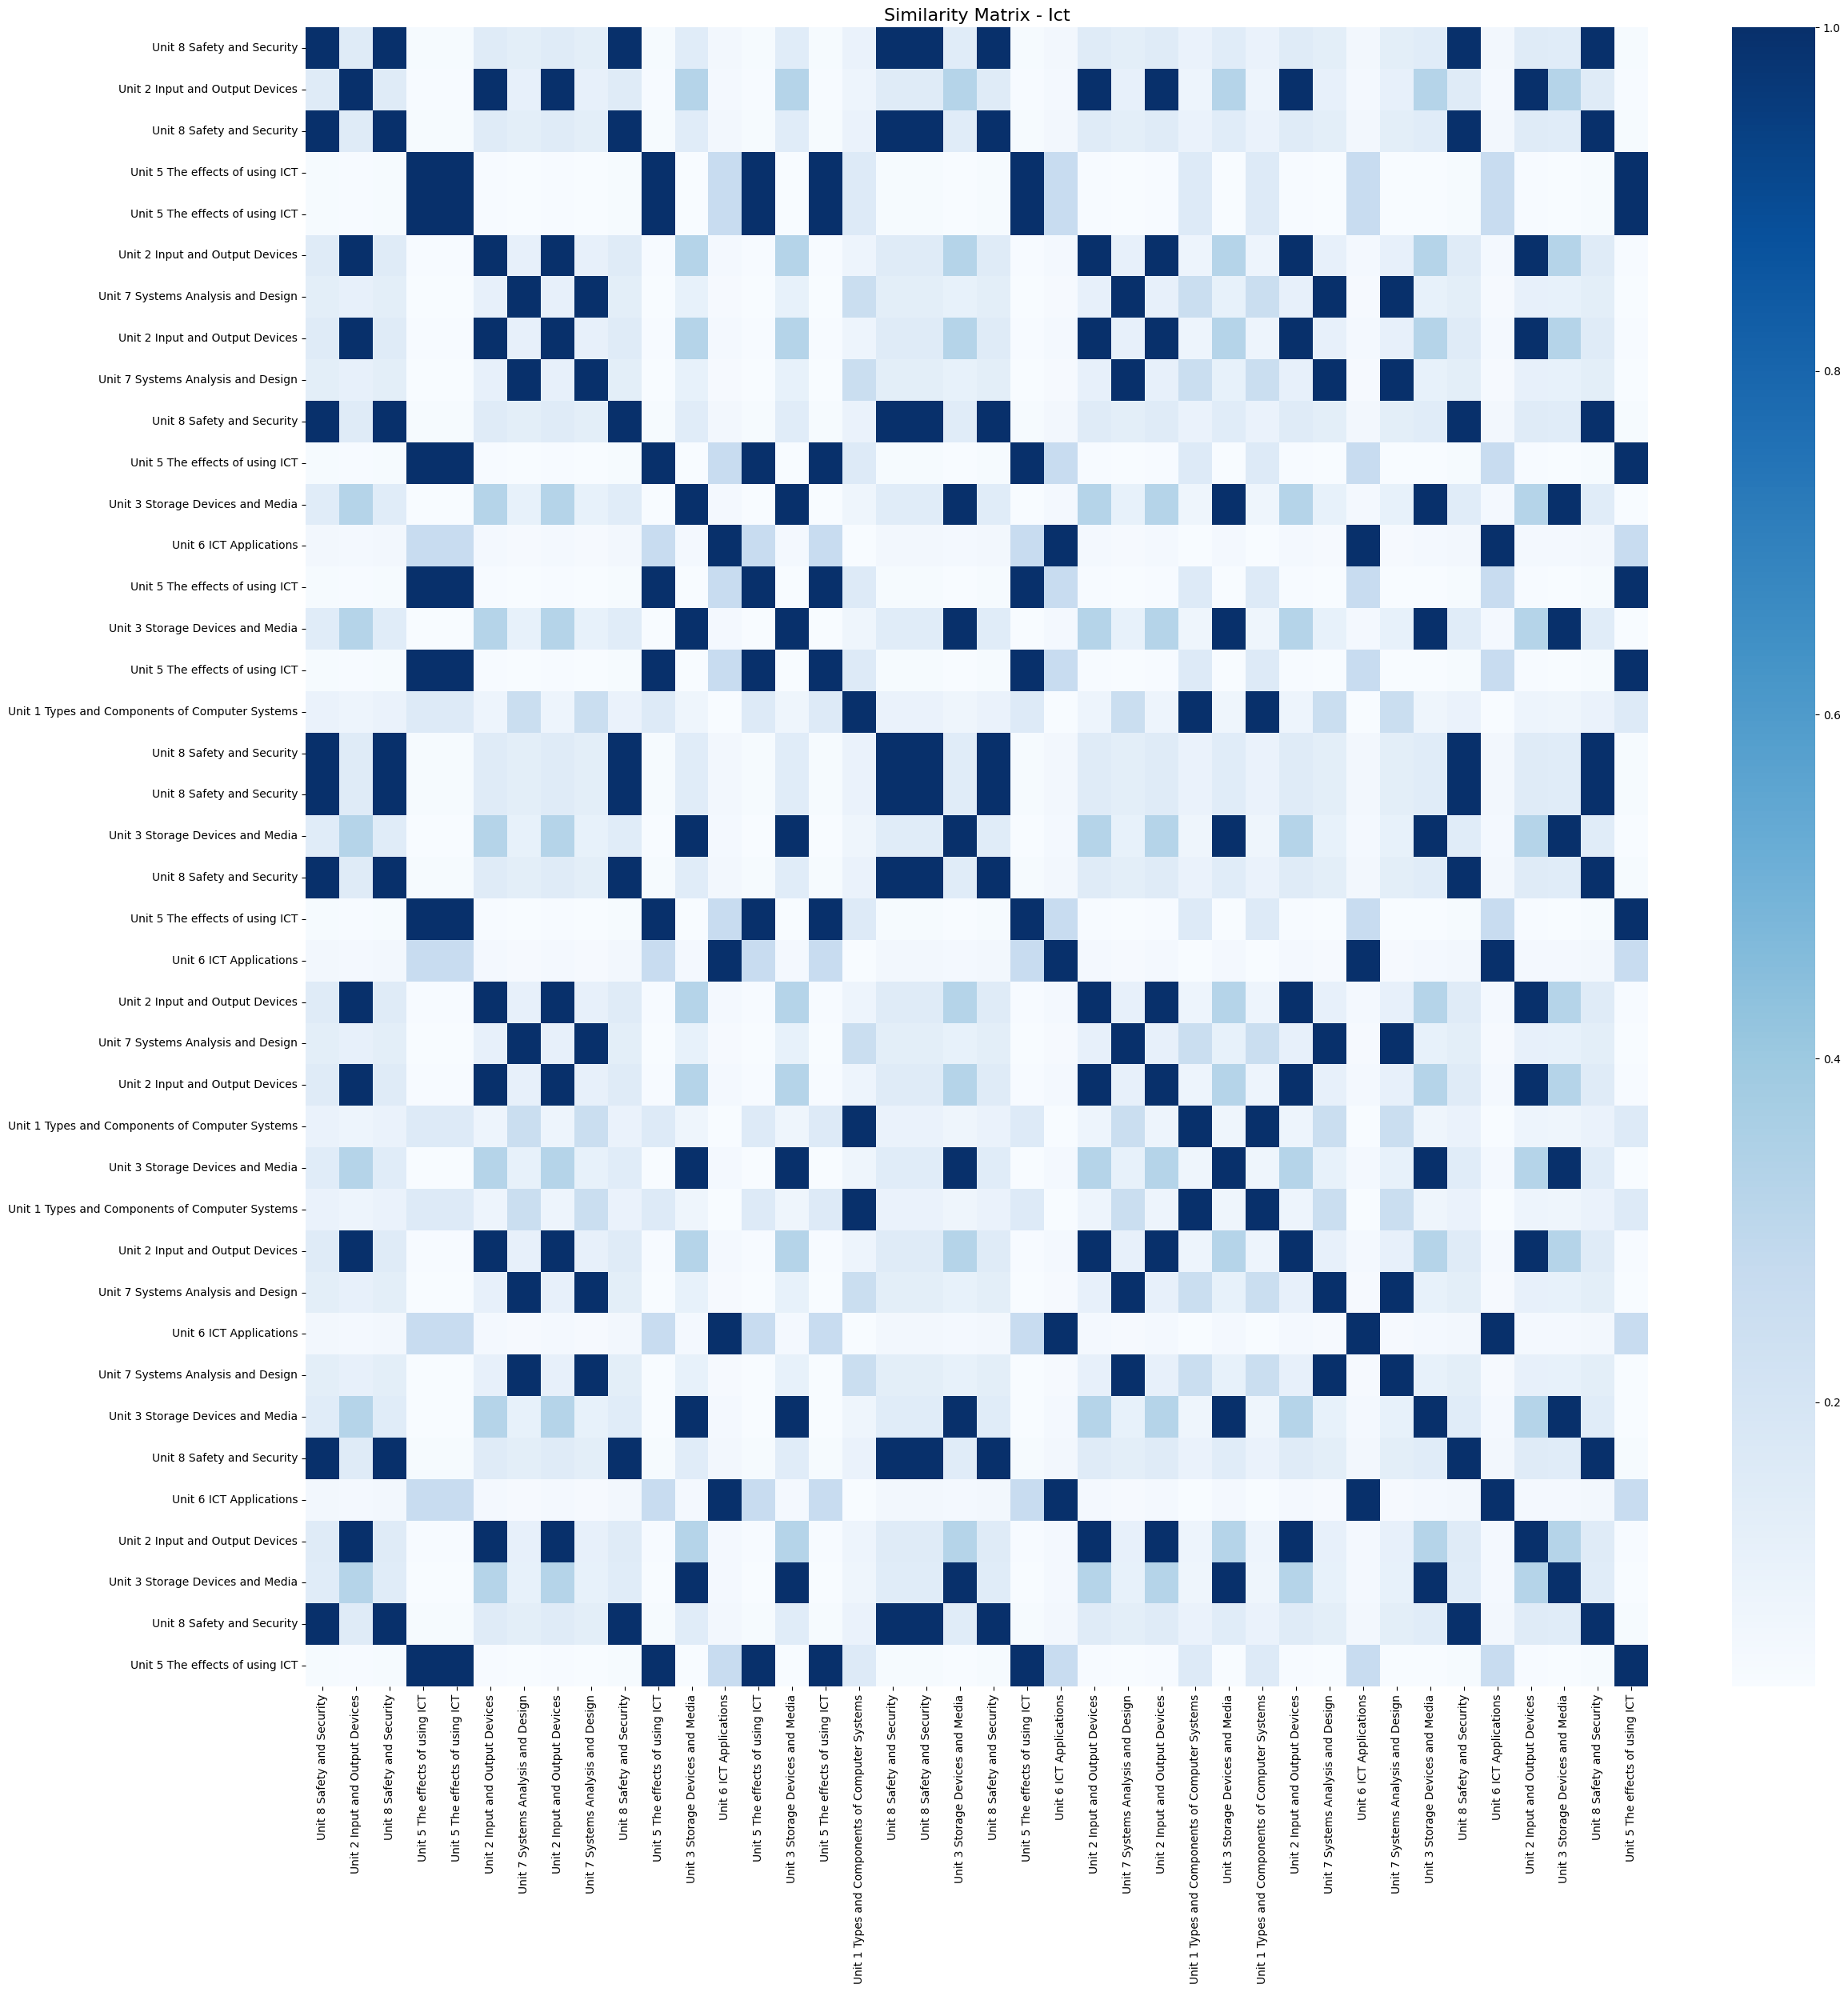

Plotting Business similarity matrix...


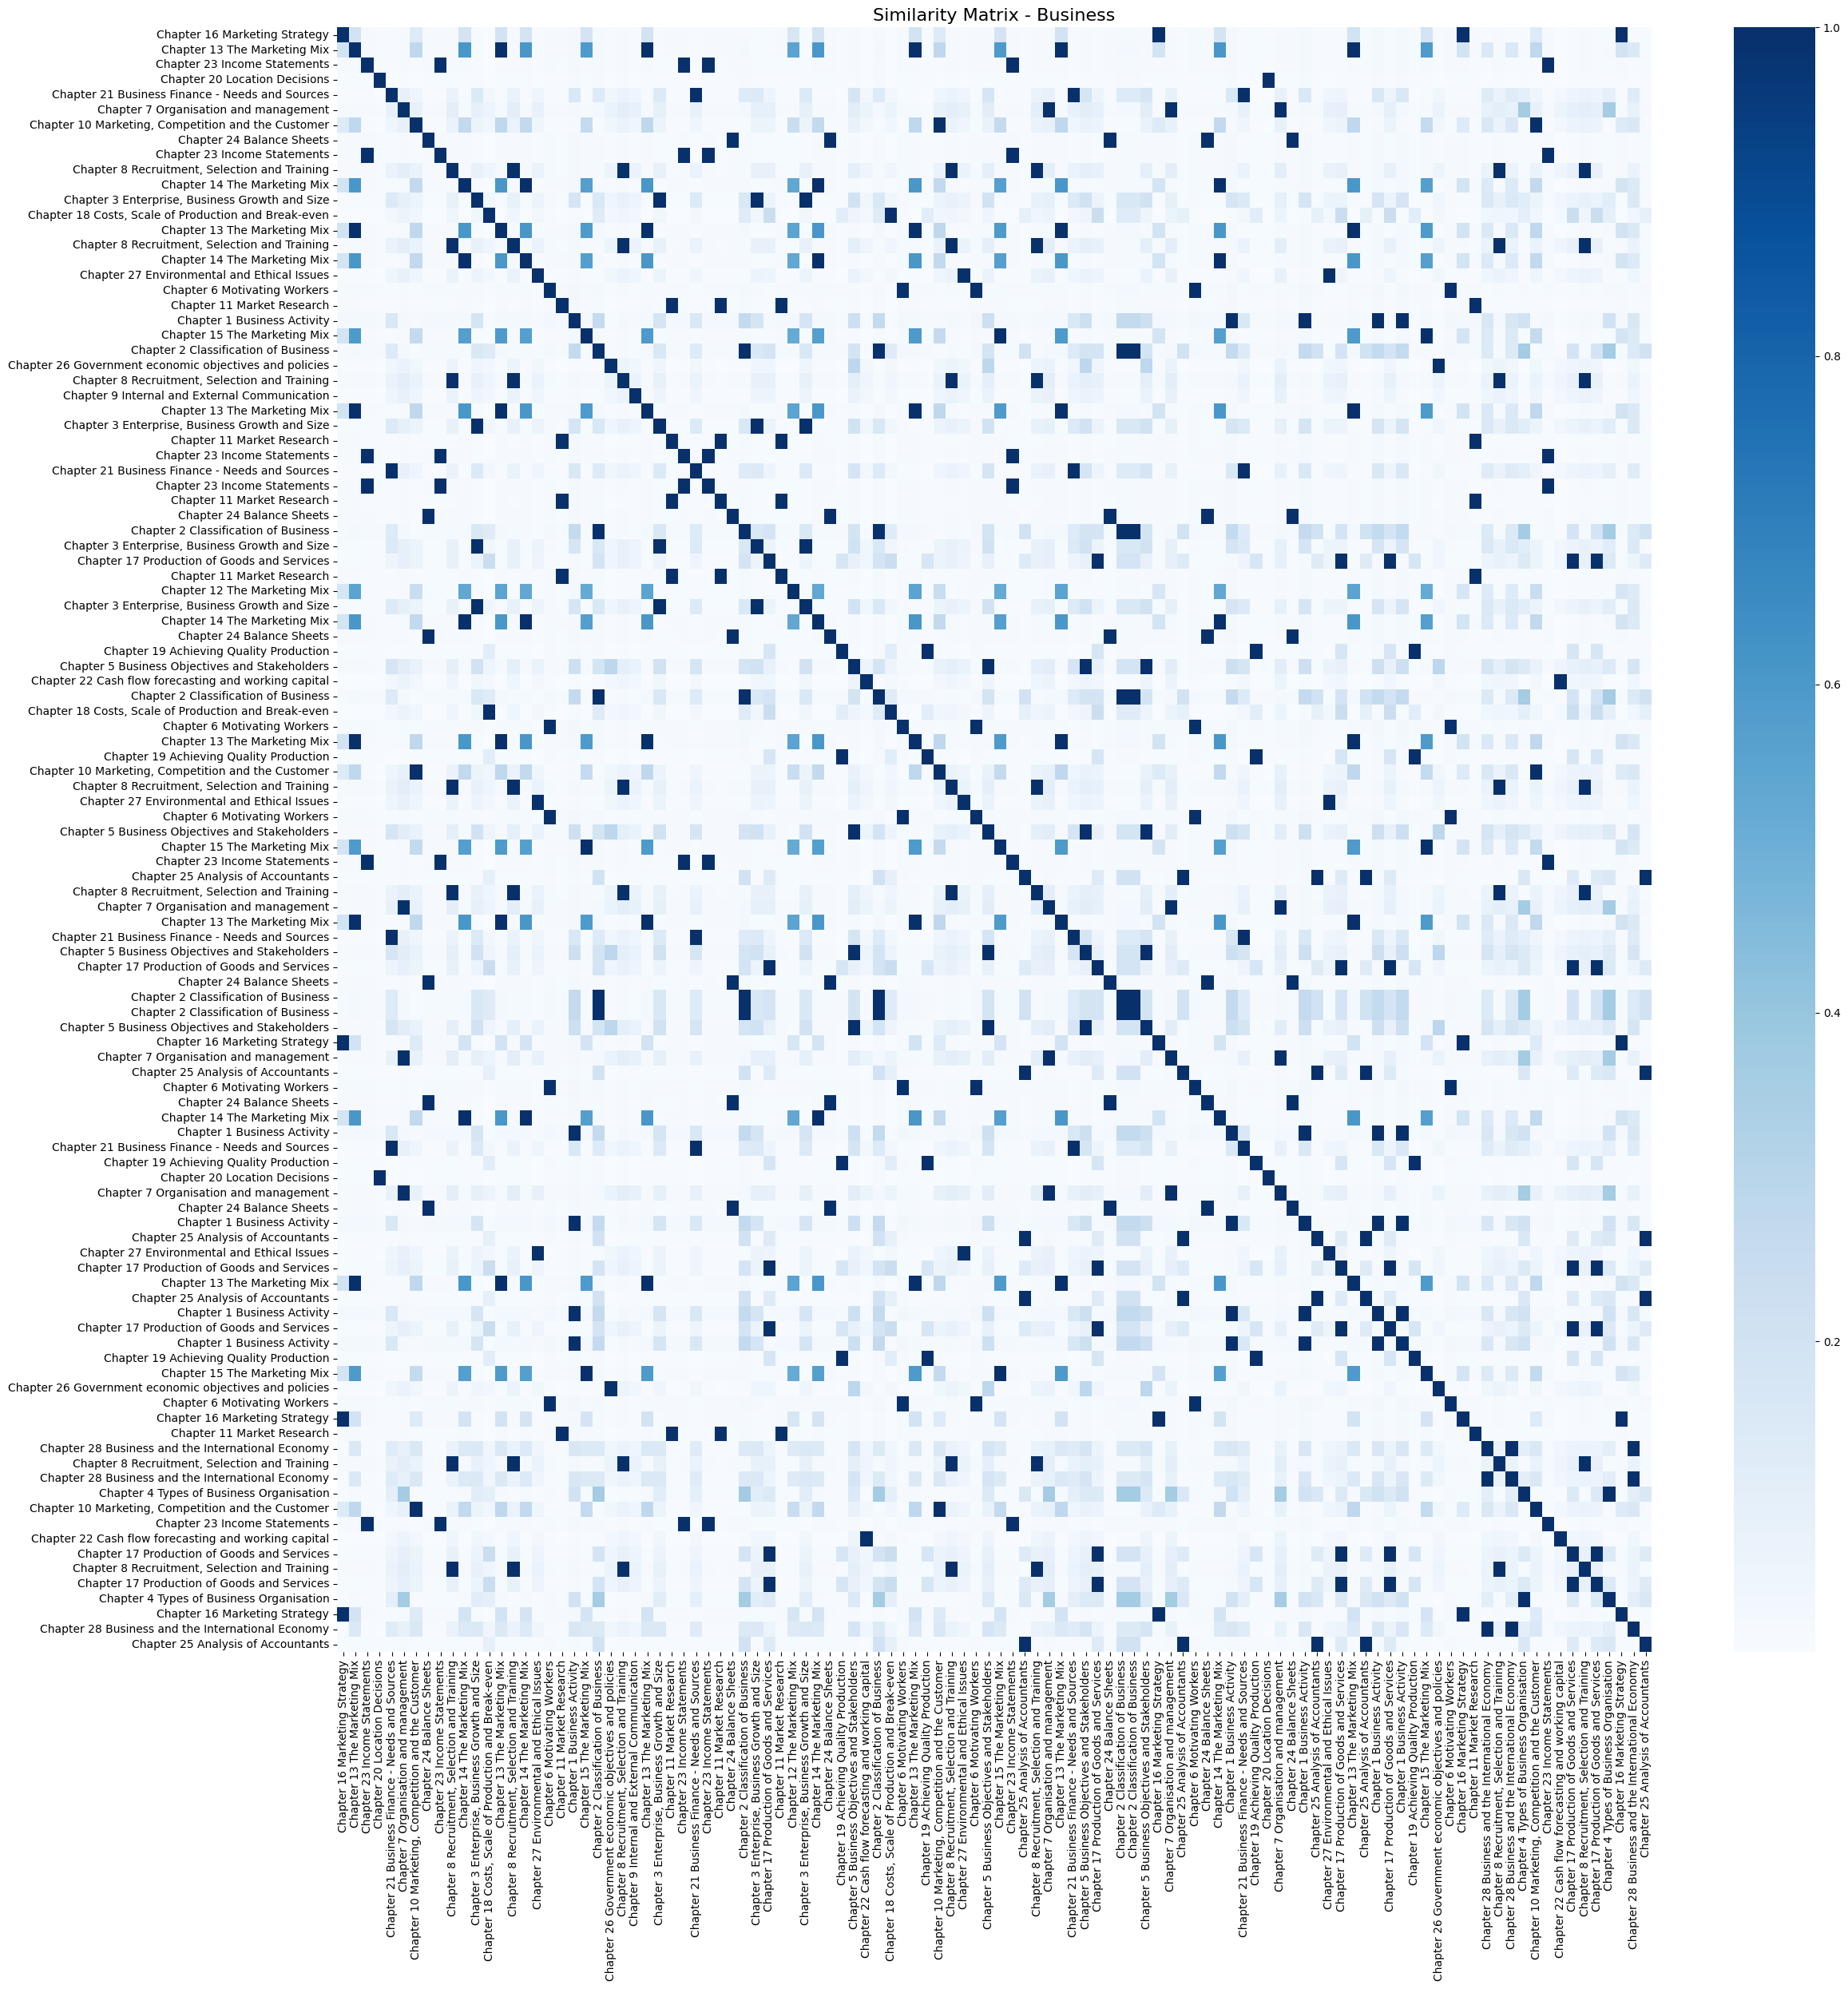

Plotting Biology similarity matrix...


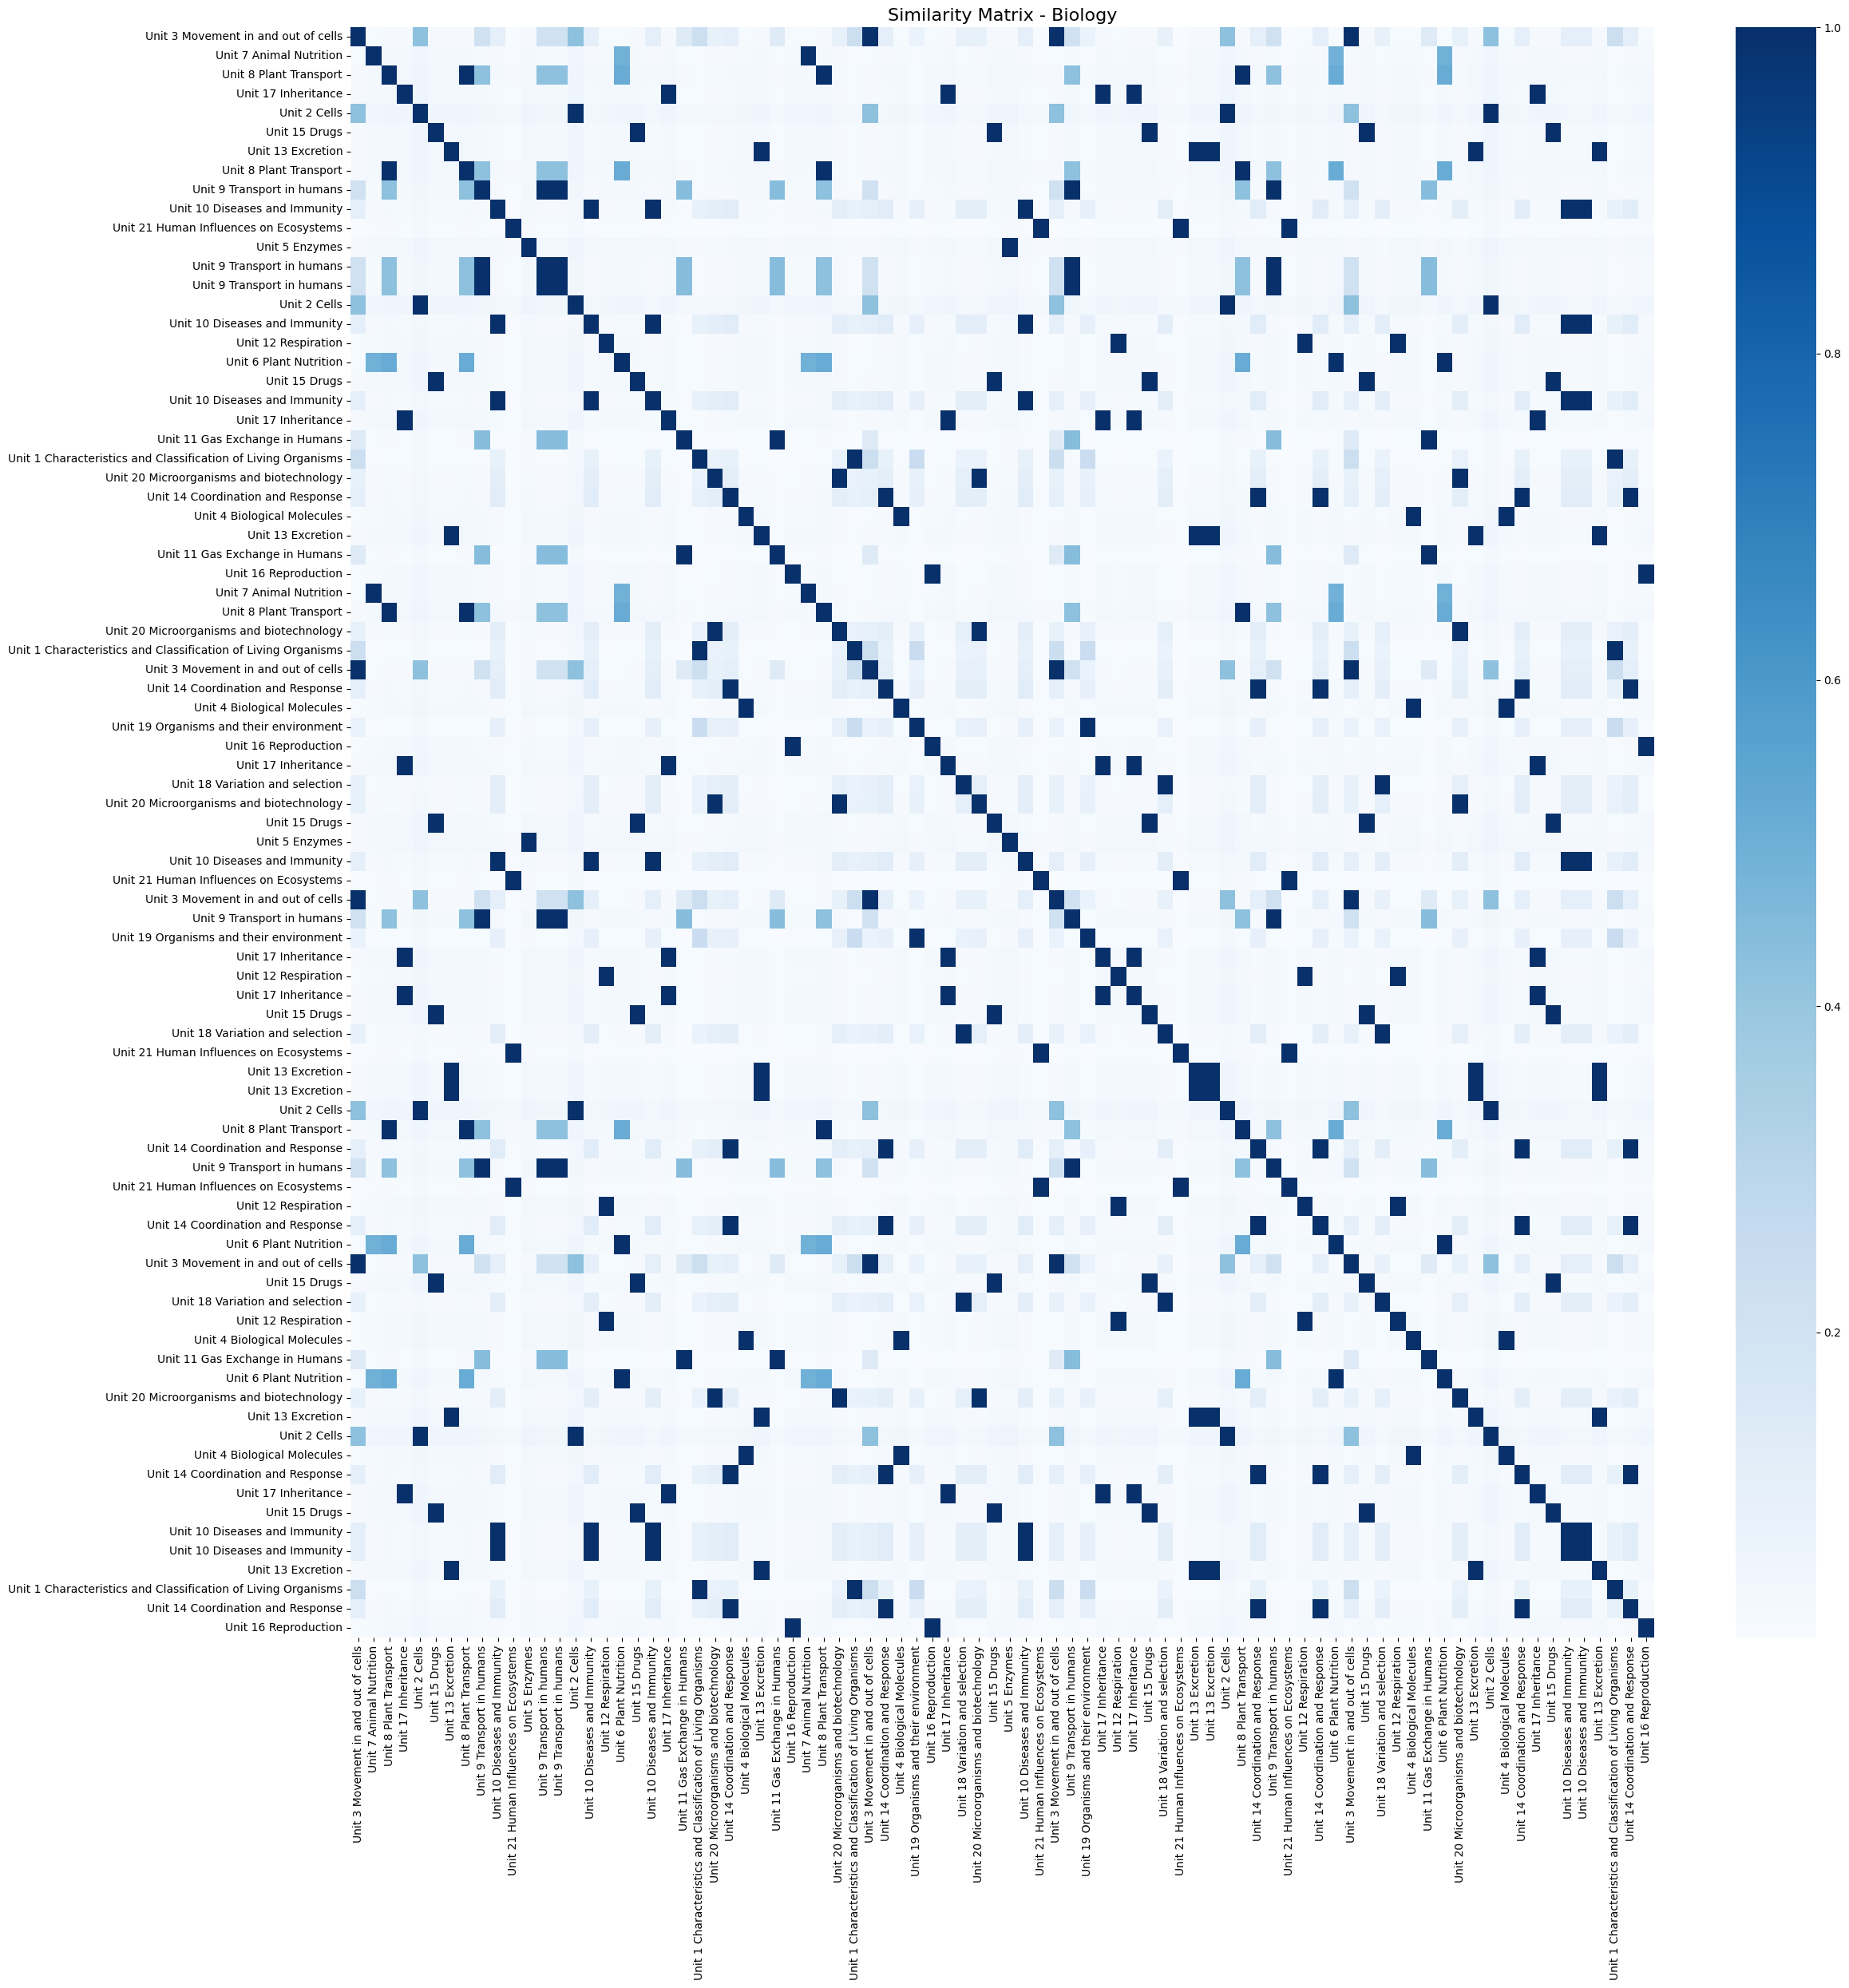

Plotting Chemistry similarity matrix...


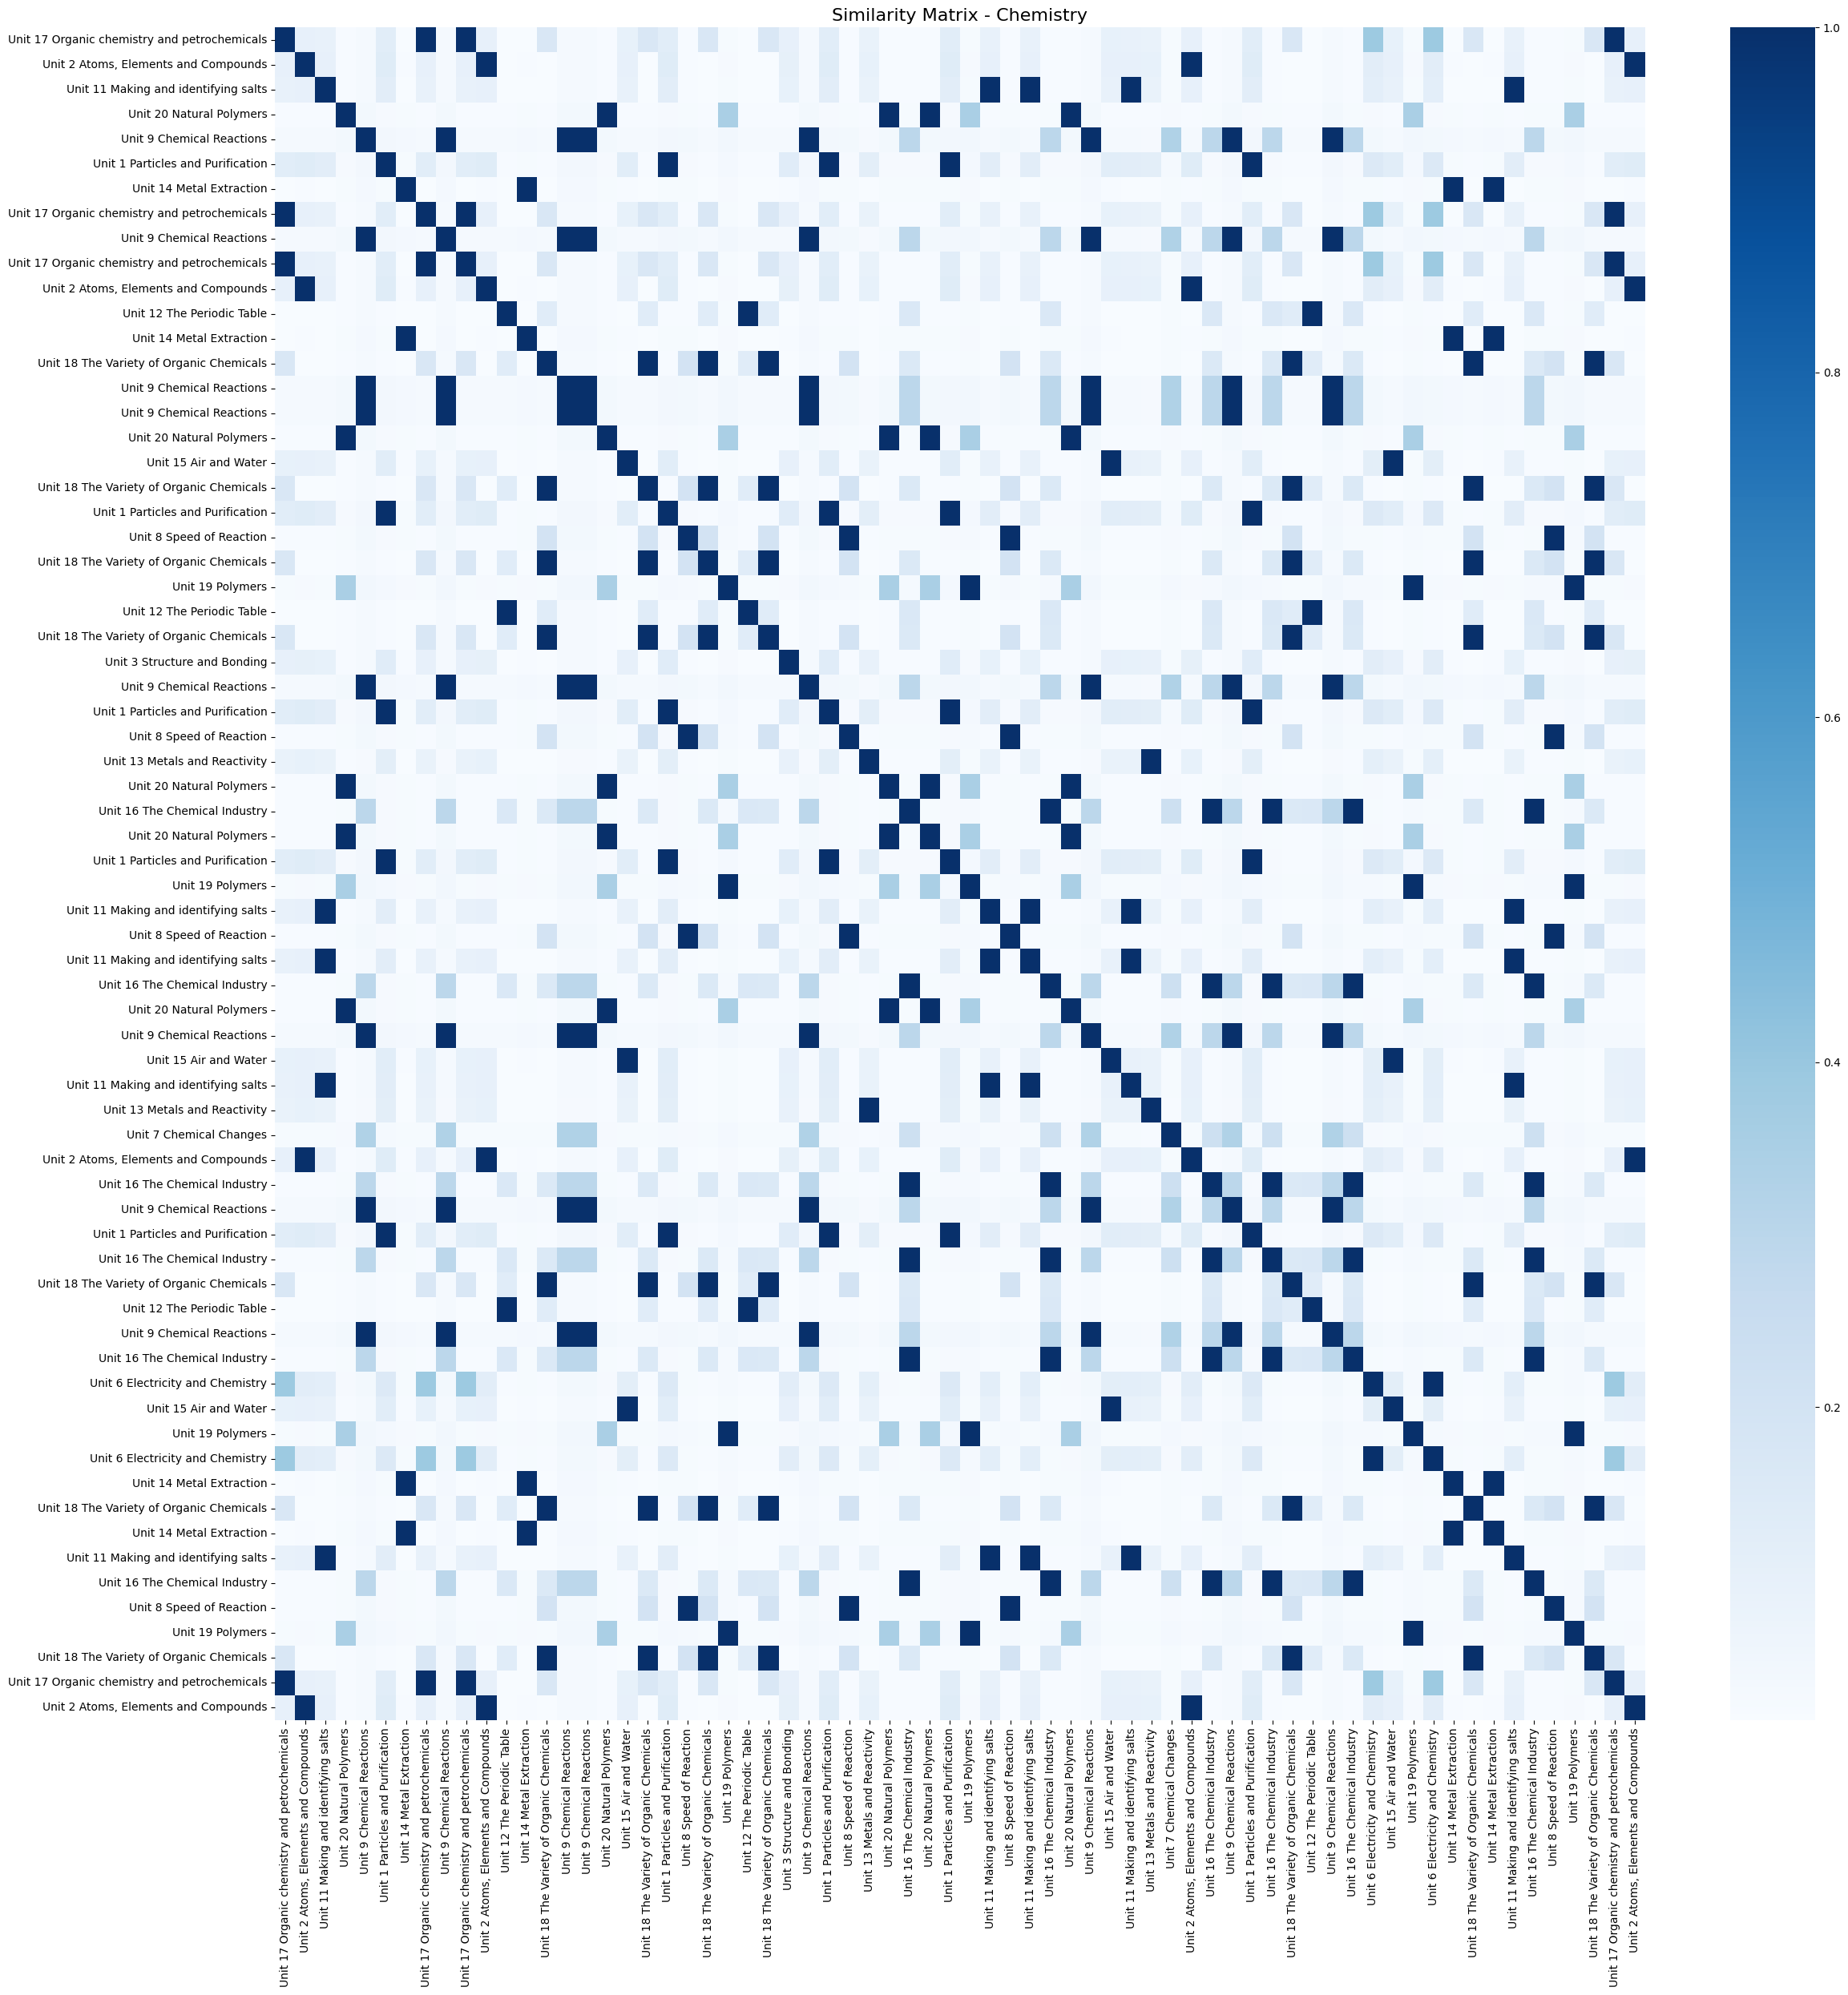

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot similarity heatmap
def plot_similarity_matrix(subject, table):
    plt.figure(figsize=(25, 25))
    sns.heatmap(table, cmap="Blues", annot=False, cbar=True,
                xticklabels=True, yticklabels=True)
    plt.title(f"Similarity Matrix - {subject.capitalize()}", fontsize=16)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot for all subjects
for subject, table in subject_tables.items():
    print(f"Plotting {subject} similarity matrix...")
    plot_similarity_matrix(subject, table)



RMSE: 1.4136
MAE:  1.2309
 SVD MODEL EVALUATION
RMSE: 1.4136
MAE: 1.2309

 PREDICTION ERROR ANALYSIS
Average prediction error: 1.2309
Max prediction error: 2.3092
Min prediction error: 0.0022


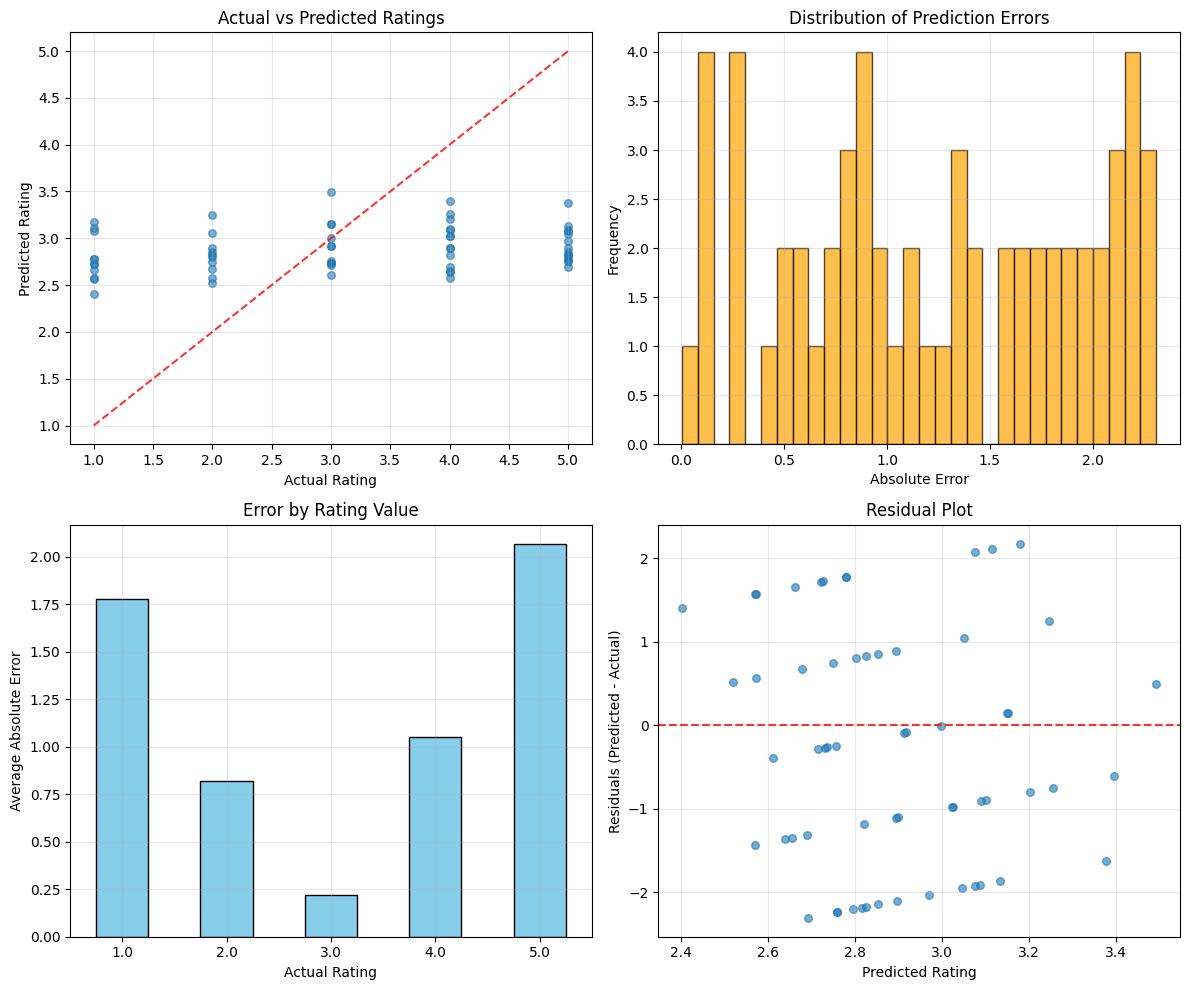


 CROSS-VALIDATION RESULTS
Cross-validation RMSE scores: ['1.5240', '1.2743', '1.4741', '1.4845', '1.3133']
Cross-validation MAE scores: ['1.2974', '1.0991', '1.3067', '1.2839', '1.1215']
Mean RMSE: 1.4140 (±0.1004)
Mean MAE: 1.2217 (±0.0916)

 TOP-N RECOMMENDATION EVALUATION
Precision@5: 0.1400
Recall@5: 0.1427

 USER AND ITEM ANALYSIS
User activity statistics:
       avg_rating  interaction_count
count      20.000               20.0
mean        2.973               15.0
std         0.308                0.0
min         2.133               15.0
25%         2.850               15.0
50%         3.000               15.0
75%         3.217               15.0
max         3.400               15.0

Topic popularity statistics:
       avg_rating  interaction_count
count      73.000             73.000
mean        2.945              4.110
std         0.818              1.704
min         1.000              1.000
25%         2.400              3.000
50%         3.000              4.000
75%         3

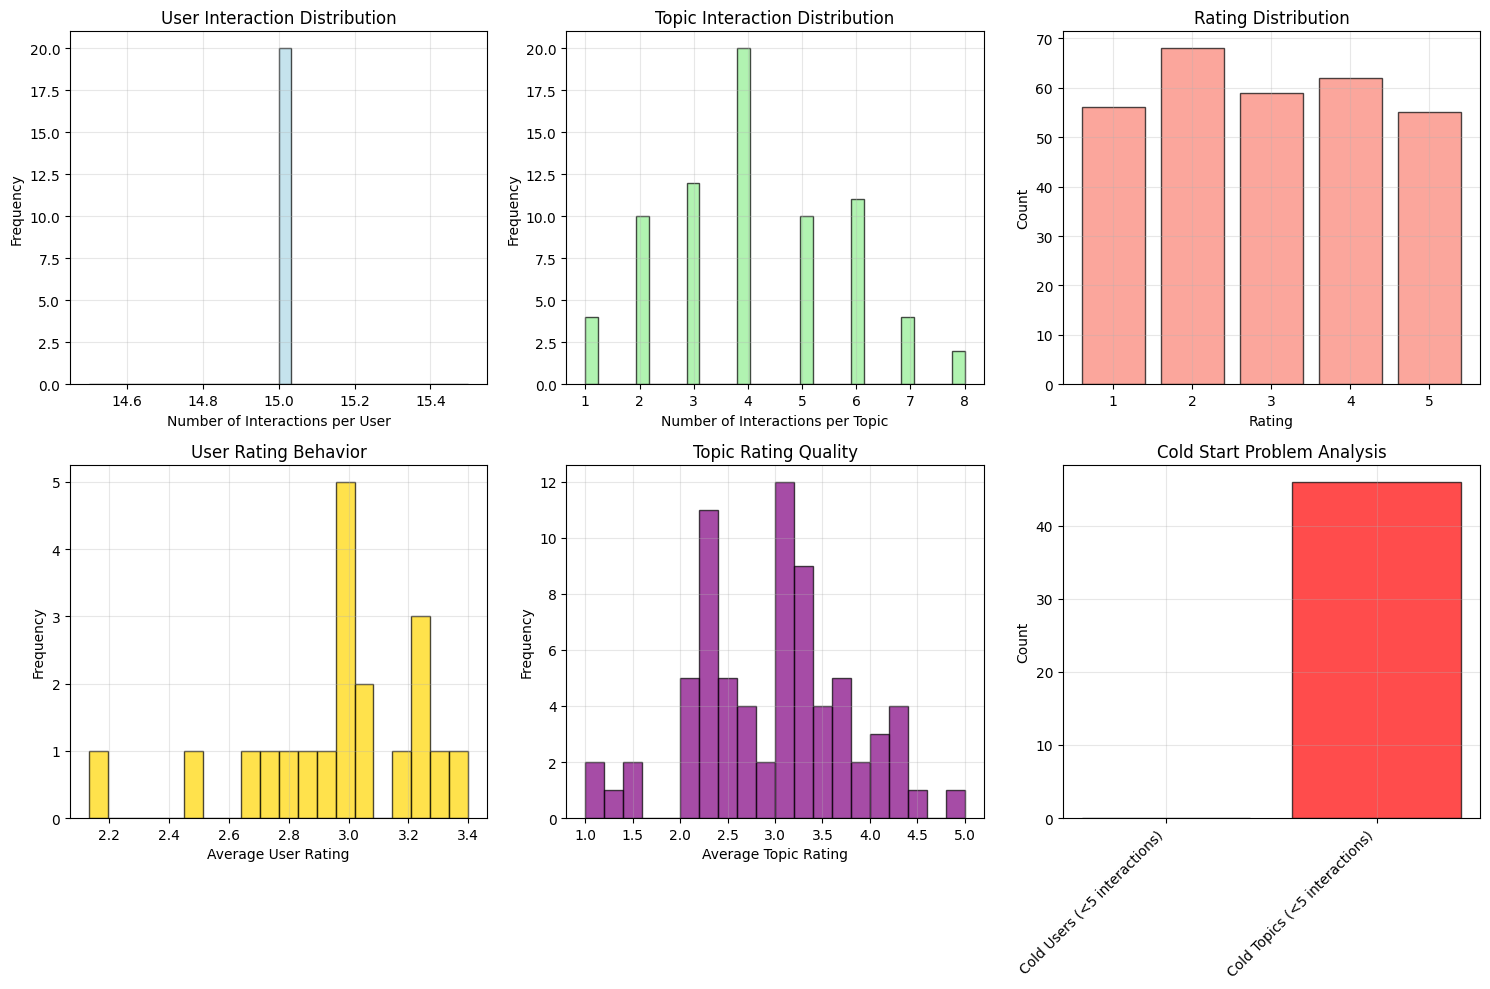

\ RECOMMENDATION DIVERSITY ANALYSIS


NameError: name 'get_top_n_recommendations' is not defined

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, ndcg_score
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv")

#Encoding
df["user_id_encoded"] = df["user_id"].astype("category").cat.codes
df["topic_id_encoded"] = df["topic_name"].astype("category").cat.codes

#Create mappings for easy lookup
topic_map = df.drop_duplicates("topic_id_encoded").set_index("topic_id_encoded")["topic_name"].to_dict()
user_map = df.drop_duplicates("user_id").set_index("user_id")["user_id_encoded"].to_dict()

#Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user_id_encoded", "topic_id_encoded", "rating"]], reader)

#Train/test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#Train SVD model
algo = SVD(random_state=42)
algo.fit(trainset)

#Evaluate
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(" SVD MODEL EVALUATION")
print("=" * 50)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# 1. PREDICTION ERROR ANALYSIS
print("\n PREDICTION ERROR ANALYSIS")
print("=" * 50)

# Extract actual and predicted ratings
actual_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]
errors = [abs(pred.r_ui - pred.est) for pred in predictions]

print(f"Average prediction error: {np.mean(errors):.4f}")
print(f"Max prediction error: {np.max(errors):.4f}")
print(f"Min prediction error: {np.min(errors):.4f}")

# Visualization: Prediction vs Actual
plt.figure(figsize=(12, 10))

# Scatter plot of actual vs predicted
plt.subplot(2, 2, 1)
plt.scatter(actual_ratings, predicted_ratings, alpha=0.6, s=30)
plt.plot([1, 5], [1, 5], 'r--', alpha=0.8)  # Perfect prediction line
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(2, 2, 2)
plt.hist(errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)

# Error by rating value
error_by_rating = pd.DataFrame({
    'actual': actual_ratings,
    'error': errors
}).groupby('actual')['error'].mean()

plt.subplot(2, 2, 3)
error_by_rating.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Actual Rating')
plt.ylabel('Average Absolute Error')
plt.title('Error by Rating Value')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# Residual plot
residuals = [pred.est - pred.r_ui for pred in predictions]
plt.subplot(2, 2, 4)
plt.scatter(predicted_ratings, residuals, alpha=0.6, s=30)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('Predicted Rating')
plt.ylabel('Residuals (Predicted - Actual)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svd_prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. CROSS-VALIDATION FOR ROBUST EVALUATION
print("\n CROSS-VALIDATION RESULTS")
print("=" * 50)

cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

print("Cross-validation RMSE scores:", [f"{score:.4f}" for score in cv_results['test_rmse']])
print("Cross-validation MAE scores:", [f"{score:.4f}" for score in cv_results['test_mae']])
print(f"Mean RMSE: {np.mean(cv_results['test_rmse']):.4f} (±{np.std(cv_results['test_rmse']):.4f})")
print(f"Mean MAE: {np.mean(cv_results['test_mae']):.4f} (±{np.std(cv_results['test_mae']):.4f})")

# 3. TOP-N RECOMMENDATION EVALUATION
print("\n TOP-N RECOMMENDATION EVALUATION")
print("=" * 50)

# Create binary relevance (rating >= 4 is relevant)
df['relevant'] = (df['rating'] >= 4).astype(int)

# Recommendation function with relevance
def get_top_n_recommendations_with_relevance(user_id, n=5):
    user_inner_id = user_map[user_id]
    all_topic_ids = df["topic_id_encoded"].unique()
    interacted_items = df[df["user_id_encoded"] == user_inner_id]["topic_id_encoded"].tolist()

    preds = []
    for item in all_topic_ids:
        if item not in interacted_items:
            pred = algo.predict(str(user_inner_id), str(item))
            preds.append((item, pred.est))
    
    preds.sort(key=lambda x: x[1], reverse=True)
    
    # Get relevance information
    recommendations = []
    for item, score in preds[:n]:
        topic_name = topic_map[item]
        # Check if this topic would be relevant (has high rating from other users)
        avg_rating = df[df['topic_id_encoded'] == item]['rating'].mean()
        relevant = 1 if avg_rating >= 4 else 0
        recommendations.append({
            'topic_name': topic_name,
            'predicted_score': score,
            'relevance': relevant
        })
    
    return recommendations

# Evaluate precision and recall for top-N recommendations
def evaluate_top_n(precision_at=5):
    precisions = []
    recalls = []
    
    test_users = df['user_id'].unique()[:20]  # Evaluate on first 20 users for efficiency
    
    for user in test_users:
        recs = get_top_n_recommendations_with_relevance(user, n=precision_at)
        relevant_recs = sum(1 for rec in recs if rec['relevance'] == 1)
        
        precision = relevant_recs / precision_at
        # For recall, we need the total number of relevant items for this user
        user_relevant_items = len(df[(df['user_id'] == user) & (df['relevant'] == 1)])
        recall = relevant_recs / user_relevant_items if user_relevant_items > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    return np.mean(precisions), np.mean(recalls)

precision, recall = evaluate_top_n(5)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")

# 4. USER AND ITEM ANALYSIS
print("\n USER AND ITEM ANALYSIS")
print("=" * 50)

# User activity analysis
user_activity = df.groupby('user_id_encoded').agg({
    'rating': 'count',
    'rating': 'mean'
}).rename(columns={'rating': 'avg_rating'})
user_activity['interaction_count'] = df.groupby('user_id_encoded').size()

# Topic popularity analysis
topic_popularity = df.groupby('topic_id_encoded').agg({
    'rating': 'count',
    'rating': 'mean'
}).rename(columns={'rating': 'avg_rating'})
topic_popularity['interaction_count'] = df.groupby('topic_id_encoded').size()

print("User activity statistics:")
print(user_activity.describe().round(3))
print("\nTopic popularity statistics:")
print(topic_popularity.describe().round(3))

# Visualization: User and item analysis
plt.figure(figsize=(15, 10))

# User interaction distribution
plt.subplot(2, 3, 1)
plt.hist(user_activity['interaction_count'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
plt.xlabel('Number of Interactions per User')
plt.ylabel('Frequency')
plt.title('User Interaction Distribution')
plt.grid(True, alpha=0.3)

# Topic interaction distribution
plt.subplot(2, 3, 2)
plt.hist(topic_popularity['interaction_count'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Number of Interactions per Topic')
plt.ylabel('Frequency')
plt.title('Topic Interaction Distribution')
plt.grid(True, alpha=0.3)

# Rating distribution
plt.subplot(2, 3, 3)
rating_counts = df['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, alpha=0.7, color='salmon', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.xticks(range(1, 6))
plt.grid(True, alpha=0.3)

# User rating distribution
plt.subplot(2, 3, 4)
plt.hist(user_activity['avg_rating'], bins=20, alpha=0.7, color='gold', edgecolor='black')
plt.xlabel('Average User Rating')
plt.ylabel('Frequency')
plt.title('User Rating Behavior')
plt.grid(True, alpha=0.3)

# Topic rating distribution
plt.subplot(2, 3, 5)
plt.hist(topic_popularity['avg_rating'], bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Average Topic Rating')
plt.ylabel('Frequency')
plt.title('Topic Rating Quality')
plt.grid(True, alpha=0.3)

# Cold start problem analysis
user_interaction_counts = df.groupby('user_id_encoded').size()
cold_users = sum(user_interaction_counts < 5)  # Users with few interactions
cold_topics = sum(topic_popularity['interaction_count'] < 5)  # Topics with few interactions

plt.subplot(2, 3, 6)
categories = ['Cold Users (<5 interactions)', 'Cold Topics (<5 interactions)']
values = [cold_users, cold_topics]
plt.bar(categories, values, alpha=0.7, color=['orange', 'red'], edgecolor='black')
plt.ylabel('Count')
plt.title('Cold Start Problem Analysis')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svd_user_item_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. RECOMMENDATION DIVERSITY ANALYSIS
print("\ RECOMMENDATION DIVERSITY ANALYSIS")
print("=" * 50)

# Analyze how diverse recommendations are across users
all_recommendations = []
test_users = df['user_id'].unique()[:30]

for user in test_users:
    recs = get_top_n_recommendations(user, n=5)
    for topic, score in recs:
        all_recommendations.append(topic)

# Calculate recommendation frequency
rec_frequency = pd.Series(all_recommendations).value_counts()
print("Top 10 most frequently recommended topics:")
print(rec_frequency.head(10))

print(f"\nRecommendation diversity: {len(rec_frequency)} unique topics recommended")
print(f"Gini coefficient of recommendation distribution: {1 - sum((rec_frequency / rec_frequency.sum())**2):.4f}")

# 6. SAVE COMPREHENSIVE EVALUATION RESULTS
evaluation_results = {
    'rmse': rmse,
    'mae': mae,
    'precision_at_5': precision,
    'recall_at_5': recall,
    'avg_prediction_error': np.mean(errors),
    'cv_mean_rmse': np.mean(cv_results['test_rmse']),
    'cv_mean_mae': np.mean(cv_results['test_mae']),
    'cold_users': cold_users,
    'cold_topics': cold_topics,
    'recommendation_diversity': len(rec_frequency),
    'avg_user_interactions': user_activity['interaction_count'].mean(),
    'avg_topic_interactions': topic_popularity['interaction_count'].mean()
}

results_df = pd.DataFrame(list(evaluation_results.items()), columns=['metric', 'value'])
results_df.to_csv('svd_evaluation_metrics.csv', index=False)

print("\COMPREHENSIVE EVALUATION COMPLETED!")
print("=" * 50)
print("Evaluation metrics saved to 'svd_evaluation_metrics.csv'")
print("Visualizations saved as PNG files")
print("\ SUMMARY:")
for metric, value in evaluation_results.items():
    if isinstance(value, float):
        print(f"{metric:.<25}: {value:.4f}")
    else:
        print(f"{metric:.<25}: {value}")

# 7. GENERATE SAMPLE RECOMMENDATIONS FOR DEMONSTRATION
print(" SAMPLE RECOMMENDATIONS")
print("=" * 50)

sample_users = ["user_1", "user_2", "user_3", "user_4", "user_5"]
results = []

for user in sample_users:
    print(f"\nTop-5 Recommendations for {user}:")
    recs = get_top_n_recommendations(user, n=5)
    for topic, score in recs:
        print(f"  {topic:35}  {score:.4f}")
        results.append({"user_id": user, "topic_name": topic, "predicted_score": score})

recs_df = pd.DataFrame(results)
recs_df.to_csv("svd_recommendations.csv", index=False)
print(" Recommendations saved to 'svd_recommendations.csv'")

<h1>Hybrid Recommender without BiLSTM</h1>

In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv")   

#Build TF-IDF similarity (per subject)
tfidf = TfidfVectorizer(stop_words="english")

subject_sim_matrices = {}
for subject in df["subject"].unique():
    subject_topics = df[df["subject"] == subject]["topic_name"].unique()
    tfidf_matrix = tfidf.fit_transform(subject_topics)
    cosine_sim = cosine_similarity(tfidf_matrix)
    subject_sim_matrices[subject] = {
        "topics": subject_topics,
        "matrix": cosine_sim
    }

#Hybrid Recommendation Function
def hybrid_recommend(user_id, topic_name, top_k=5, alpha=0.5, beta=0.5):
    # Identify the subject of the selected topic
    if topic_name not in df["topic_name"].values:
        return f"Topic '{topic_name}' not found!"
    
    subject = df[df["topic_name"] == topic_name]["subject"].iloc[0]
    sim_data = subject_sim_matrices[subject]
    topics = sim_data["topics"]
    cosine_sim = sim_data["matrix"]

    # Content similarity
    idx = np.where(topics == topic_name)[0][0]
    cos_sim = cosine_sim[idx]

    content_scores = pd.DataFrame({
        "topic_name": topics,
        "content_score": cos_sim
    })

    #Collaborative Filtering
    cf_scores = []
    for t in topics:
        pred = df[(df["user_id"] == user_id) & (df["topic_name"] == t)]["rating"].mean()
        if np.isnan(pred):
            pred = df[df["topic_name"] == t]["rating"].mean()
        cf_scores.append(pred)
    content_scores["cf_score"] = cf_scores

    # Hybrid score
    content_scores["hybrid_score"] = (
        alpha * content_scores["content_score"] +
        beta * content_scores["cf_score"]
    )

    #Rank and return
    recs = content_scores.sort_values(by="hybrid_score", ascending=False).head(top_k)
    return subject, recs[["topic_name", "content_score", "cf_score", "hybrid_score"]]

print("=== Biology Example ===")
subject, recs = hybrid_recommend("user_5", "Unit 12 Respiration", top_k=5)
print(f"Subject: {subject}")
print(recs.to_string(index=False, float_format="%.3f"))
print()  # Empty line for spacing

print("=== Chemistry Example ===")
subject, recs = hybrid_recommend("user_7", "Unit 12 The Periodic Table", top_k=5)
print(f"Subject: {subject}")
print(recs.to_string(index=False, float_format="%.3f"))


=== Biology Example ===
Subject: Biology
                              topic_name  content_score  cf_score  hybrid_score
                     Unit 12 Respiration          1.000     4.250         2.625
                 Unit 7 Animal Nutrition          0.044     5.000         2.522
Unit 20 Microorganisms and biotechnology          0.034     4.250         2.142
                  Unit 6 Plant Nutrition          0.047     4.000         2.023
                     Unit 17 Inheritance          0.042     4.000         2.021

=== Chemistry Example ===
Subject: Chemistry
                   topic_name  content_score  cf_score  hybrid_score
      Unit 7 Chemical Changes          0.042     4.000         2.021
 Unit 3 Structure and Bonding          0.038     4.000         2.019
Unit 16 The Chemical Industry          0.034     3.833         1.934
     Unit 14 Metal Extraction          0.032     3.750         1.891
     Unit 20 Natural Polymers          0.033     3.400         1.716


In [28]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the data
df = pd.read_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv")

# Build TF-IDF similarity (per subject)
tfidf = TfidfVectorizer(stop_words="english")

subject_sim_matrices = {}
for subject in df["subject"].unique():
    subject_topics = df[df["subject"] == subject]["topic_name"].unique()
    tfidf_matrix = tfidf.fit_transform(subject_topics)
    cosine_sim = cosine_similarity(tfidf_matrix)
    subject_sim_matrices[subject] = {
        "topics": subject_topics,
        "matrix": cosine_sim
    }

# Hybrid Recommendation Function
def hybrid_recommend(user_id, topic_name, top_k=5, alpha=0.5, beta=0.5):
    # Identify the subject of the selected topic
    if topic_name not in df["topic_name"].values:
        raise ValueError(f"Topic '{topic_name}' not found!")
    
    subject = df[df["topic_name"] == topic_name]["subject"].iloc[0]
    sim_data = subject_sim_matrices[subject]
    topics = sim_data["topics"]
    cosine_sim = sim_data["matrix"]

    # Content similarity
    idx = np.where(topics == topic_name)[0][0]
    cos_sim = cosine_sim[idx]

    content_scores = pd.DataFrame({
        "topic_name": topics,
        "content_score": cos_sim
    })

    # Collaborative Filtering
    cf_scores = []
    for t in topics:
        pred = df[(df["user_id"] == user_id) & (df["topic_name"] == t)]["rating"].mean()
        if np.isnan(pred):
            pred = df[df["topic_name"] == t]["rating"].mean()
        cf_scores.append(pred)
    content_scores["cf_score"] = cf_scores

    # Hybrid score
    content_scores["hybrid_score"] = (
        alpha * content_scores["content_score"] +
        beta * content_scores["cf_score"]
    )

    # Rank and return
    recs = content_scores.sort_values(by="hybrid_score", ascending=False).head(top_k)
    return recs[["topic_name", "content_score", "cf_score", "hybrid_score"]]

# -------------------------------
# Generate recommendations for ALL users and topics
# -------------------------------
all_results = []

for user in df["user_id"].unique():
    for topic in df["topic_name"].unique():
        try:
            # Get recommendations for this user-topic combination
            recs = hybrid_recommend(user, topic, top_k=5)
            
            # Add input user and topic to the results
            recs = recs.copy()
            recs["input_user"] = user
            recs["input_topic"] = topic
            
            all_results.append(recs)
            
        except Exception as e:
            print(f"Skipping {user}, {topic} due to error: {e}")
            continue

# Combine into one DataFrame
if all_results:
    final_recs = pd.concat(all_results, ignore_index=True)
    
    # Reorder columns for readability
    final_recs = final_recs[["input_user", "input_topic", "topic_name", "content_score", "cf_score", "hybrid_score"]]
    
    # Save to CSV
    final_recs.to_csv("all_hybrid_recommendations.csv", index=False)
    
    print("Exported all recommendations to all_hybrid_recommendations.csv")
    print(f"Total recommendations generated: {len(final_recs)}")
    
    # -------------------------------
    # Show a quick sample
    # -------------------------------
    print("Example Recommendations:")
    print(final_recs.head(15).to_string(index=False, float_format="%.3f"))
else:
    print("No recommendations were generated. Check for errors above.")

Exported all recommendations to all_hybrid_recommendations.csv
Total recommendations generated: 7300
Example Recommendations:
input_user                   input_topic                                      topic_name  content_score  cf_score  hybrid_score
    user_1    Unit 8 Safety and Security                      Unit 8 Safety and Security          1.000     4.000         2.500
    user_1    Unit 8 Safety and Security                 Unit 2 Input and Output Devices          0.070     4.000         2.035
    user_1    Unit 8 Safety and Security Unit 1 Types and Components of Computer Systems          0.061     3.667         1.864
    user_1    Unit 8 Safety and Security                 Unit 5 The effects of using ICT          0.070     2.857         1.464
    user_1    Unit 8 Safety and Security                Unit 3 Storage Devices and Media          0.070     2.833         1.452
    user_1 Chapter 16 Marketing Strategy                    Chapter 15 The Marketing Mix          0.223   

BASIC STATISTICS
Total recommendations generated: 7,300
Number of unique users: 20
Number of unique topics: 67
Number of input topics: 73

SCORE DISTRIBUTION
Hybrid Score Statistics:
count    7300.000
mean        2.158
std         0.277
min         1.231
25%         2.012
50%         2.140
75%         2.417
max         3.000
Name: hybrid_score, dtype: float64

Content Score Statistics:
count    7300.000
mean        0.166
std         0.308
min         0.014
25%         0.029
50%         0.038
75%         0.058
max         1.000
Name: content_score, dtype: float64

CF Score Statistics:
count    7300.000
mean        4.150
std         0.582
min         2.000
25%         3.833
50%         4.000
75%         4.400
max         5.000
Name: cf_score, dtype: float64


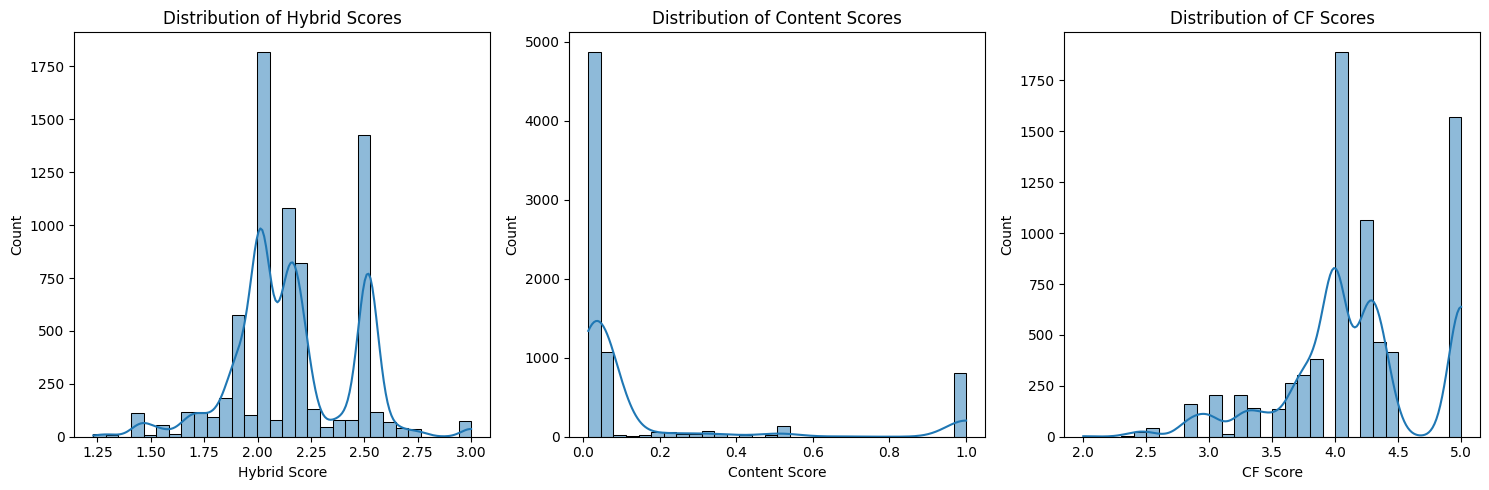

CORRELATION ANALYSIS
Correlation Matrix:
               hybrid_score  content_score  cf_score
hybrid_score          1.000          0.187     0.854
content_score         0.187          1.000    -0.352
cf_score              0.854         -0.352     1.000


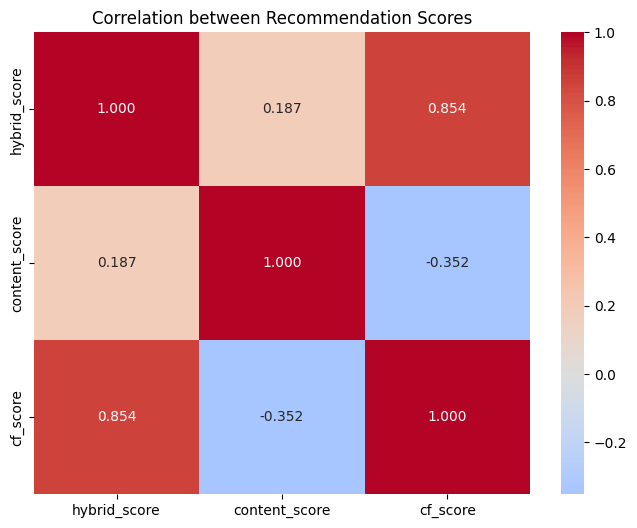

PRECISION AND RECALL AT K=5
Average Precision@5: 0.590
Average Recall@5: 0.026
Average NDCG@5: 0.748
USER ENGAGEMENT ANALYSIS
Top 10 Most Engaged Users:
            engagement_rate  relevant_recommendations
input_user                                           
user_11               0.416                     152.0
user_8                0.416                     152.0
user_7                0.386                     141.0
user_17               0.373                     136.0
user_3                0.356                     130.0
user_2                0.340                     124.0
user_6                0.329                     120.0
user_16               0.326                     119.0
user_4                0.307                     112.0
user_15               0.296                     108.0


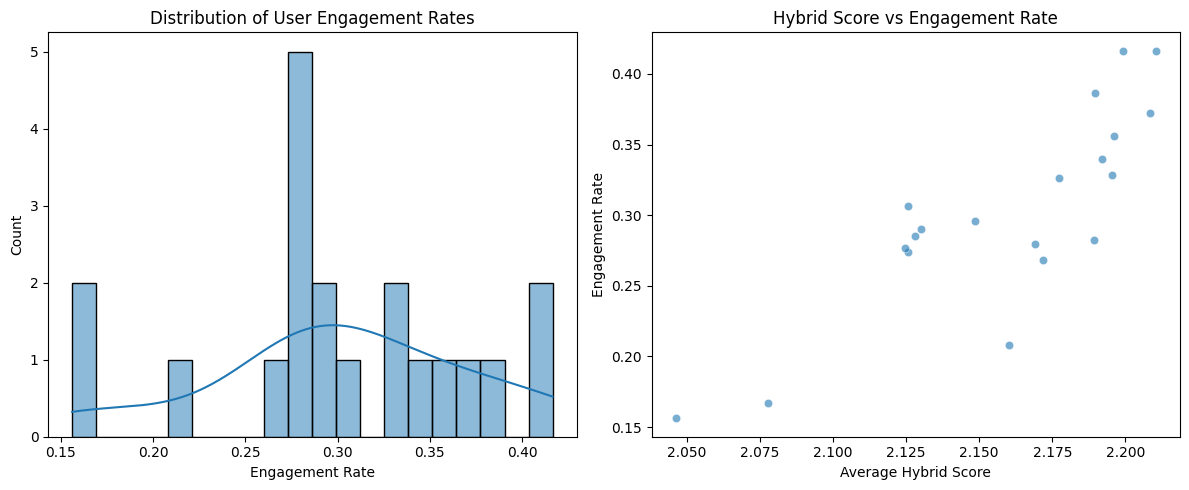

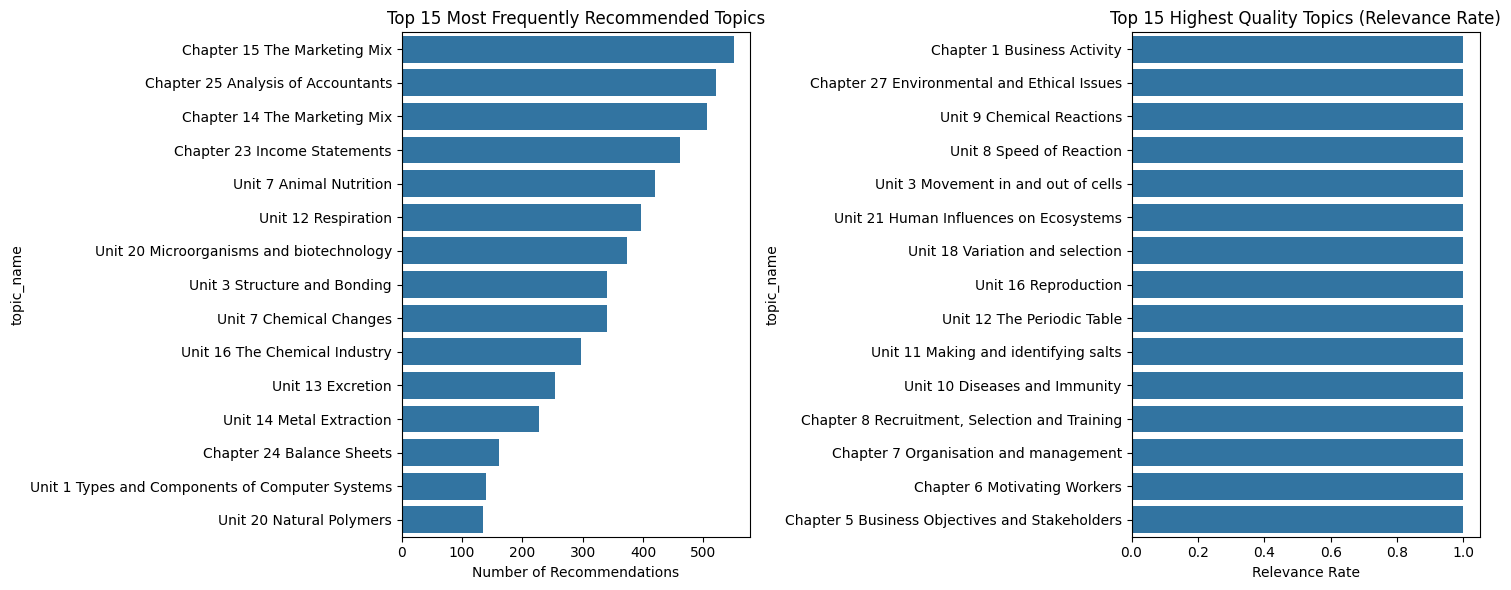


🔧 HYBRID MODEL COMPONENT ANALYSIS
       content_score  cf_score  hybrid_score
count       7300.000  7300.000      7300.000
mean           0.166     4.150         2.158
std            0.308     0.582         0.277
min            0.014     2.000         1.231
25%            0.029     3.833         2.012
50%            0.038     4.000         2.140
75%            0.058     4.400         2.417
max            1.000     5.000         3.000


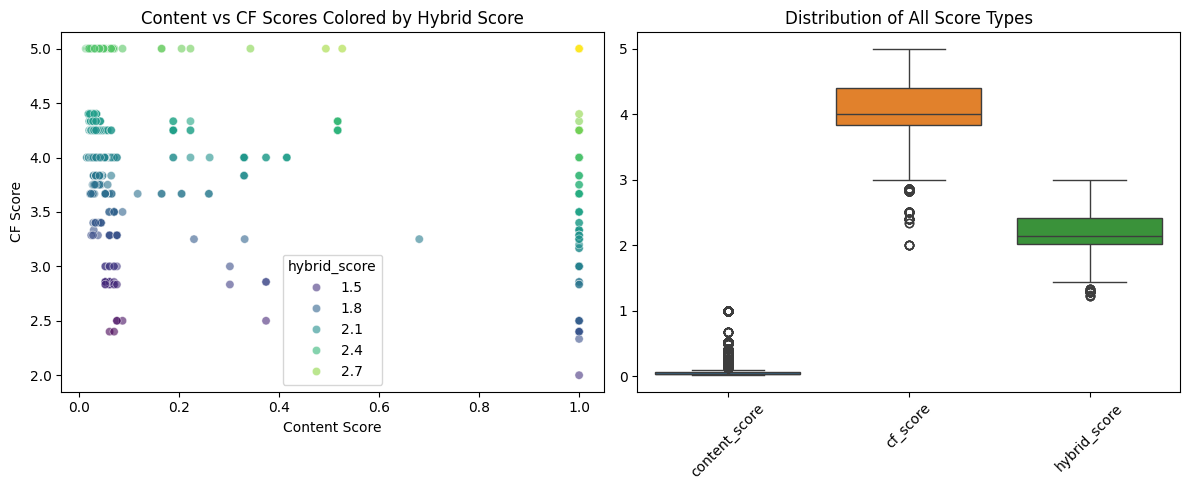


 COMPREHENSIVE EVALUATION REPORT
Total Recommendations: 7,300
Average Precision@5: 0.590
Average Recall@5: 0.026
Average NDCG@5: 0.748
Average User Engagement Rate: 0.302
Average Hybrid Score: 2.158
Content-CF Correlation: -0.352
Evaluation metrics saved to evaluation_metrics.csv
All visualizations saved as PNG files


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, ndcg_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


final_recs = pd.read_csv("all_hybrid_recommendations.csv")


df = pd.read_csv(r"C:\Users\Rizwana\Desktop\studyoclock project\interactions_real.csv")

#Statistics and overview
print("BASIC STATISTICS")
print("=" * 50)
print(f"Total recommendations generated: {len(final_recs):,}")
print(f"Number of unique users: {final_recs['input_user'].nunique()}")
print(f"Number of unique topics: {final_recs['topic_name'].nunique()}")
print(f"Number of input topics: {final_recs['input_topic'].nunique()}")
print()

#SCORE DISTRIBUTION ANALYSIS
print("SCORE DISTRIBUTION")
print("=" * 50)
print("Hybrid Score Statistics:")
print(final_recs['hybrid_score'].describe().round(3))
print("\nContent Score Statistics:")
print(final_recs['content_score'].describe().round(3))
print("\nCF Score Statistics:")
print(final_recs['cf_score'].describe().round(3))

#Visualization: Score Distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(final_recs['hybrid_score'], bins=30, kde=True)
plt.title('Distribution of Hybrid Scores')
plt.xlabel('Hybrid Score')

plt.subplot(1, 3, 2)
sns.histplot(final_recs['content_score'], bins=30, kde=True)
plt.title('Distribution of Content Scores')
plt.xlabel('Content Score')

plt.subplot(1, 3, 3)
sns.histplot(final_recs['cf_score'], bins=30, kde=True)
plt.title('Distribution of CF Scores')
plt.xlabel('CF Score')

plt.tight_layout()
plt.savefig('score_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

#CORRELATION ANALYSIS
print("CORRELATION ANALYSIS")
print("=" * 50)
correlation_matrix = final_recs[['hybrid_score', 'content_score', 'cf_score']].corr()
print("Correlation Matrix:")
print(correlation_matrix.round(3))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation between Recommendation Scores')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

#TOP-N RECOMMENDATION ANALYSIS
#Create a binary relevance column (assuming ratings > 3 are relevant)
df['relevant'] = (df['rating'] >= 3).astype(int)

#Merge recommendations with actual interactions to find relevant items
eval_data = final_recs.merge(
    df[['user_id', 'topic_name', 'rating', 'relevant']],
    left_on=['input_user', 'topic_name'],
    right_on=['user_id', 'topic_name'],
    how='left'
)

eval_data['relevant'] = eval_data['relevant'].fillna(0)  # Not interacted = not relevant

# 5. PRECISION AND RECALL AT K
def precision_recall_at_k(df, k=5):
    results = []
    for user in df['input_user'].unique():
        user_recs = df[df['input_user'] == user].nlargest(k, 'hybrid_score')
        relevant_count = user_recs['relevant'].sum()
        precision = relevant_count / k if k > 0 else 0
        recall = relevant_count / df[(df['input_user'] == user) & (df['relevant'] == 1)].shape[0] if df[(df['input_user'] == user) & (df['relevant'] == 1)].shape[0] > 0 else 0
        results.append({'user': user, 'precision': precision, 'recall': recall})
    return pd.DataFrame(results)

precision_recall_df = precision_recall_at_k(eval_data, k=5)

print("PRECISION AND RECALL AT K=5")
print("=" * 50)
print(f"Average Precision@5: {precision_recall_df['precision'].mean():.3f}")
print(f"Average Recall@5: {precision_recall_df['recall'].mean():.3f}")

#NDCG (Normalized Discounted Cumulative Gain)
def calculate_ndcg(df, k=5):
    ndcg_scores = []
    for user in df['input_user'].unique():
        user_recs = df[df['input_user'] == user].nlargest(k, 'hybrid_score')
        relevance_scores = user_recs['relevant'].values
        # Calculate ideal DCG
        ideal_relevance = np.sort(relevance_scores)[::-1]  # Sort in descending order
        dcg = sum((2 ** rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores))
        idcg = sum((2 ** rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(ideal_relevance))
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)
    return np.mean(ndcg_scores)

avg_ndcg = calculate_ndcg(eval_data, k=5)
print(f"Average NDCG@5: {avg_ndcg:.3f}")

#USER ENGAGEMENT ANALYSIS
user_engagement = eval_data.groupby('input_user').agg({
    'hybrid_score': 'mean',
    'relevant': 'sum',
    'topic_name': 'count'
}).rename(columns={'topic_name': 'total_recommendations', 'relevant': 'relevant_recommendations'})

user_engagement['engagement_rate'] = user_engagement['relevant_recommendations'] / user_engagement['total_recommendations']

print( "USER ENGAGEMENT ANALYSIS")
print("=" * 50)
print("Top 10 Most Engaged Users:")
print(user_engagement.nlargest(10, 'engagement_rate')[['engagement_rate', 'relevant_recommendations']].round(3))

#Visualization: User Engagement
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(user_engagement['engagement_rate'], bins=20, kde=True)
plt.title('Distribution of User Engagement Rates')
plt.xlabel('Engagement Rate')

plt.subplot(1, 2, 2)
sns.scatterplot(data=user_engagement, x='hybrid_score', y='engagement_rate', alpha=0.6)
plt.title('Hybrid Score vs Engagement Rate')
plt.xlabel('Average Hybrid Score')
plt.ylabel('Engagement Rate')

plt.tight_layout()
plt.savefig('user_engagement_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#TOPIC POPULARITY ANALYSIS
topic_popularity = final_recs['topic_name'].value_counts().head(15)
topic_quality = eval_data.groupby('topic_name')['relevant'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(y=topic_popularity.index, x=topic_popularity.values)
plt.title('Top 15 Most Frequently Recommended Topics')
plt.xlabel('Number of Recommendations')

plt.subplot(1, 2, 2)
sns.barplot(y=topic_quality.index, x=topic_quality.values)
plt.title('Top 15 Highest Quality Topics (Relevance Rate)')
plt.xlabel('Relevance Rate')

plt.tight_layout()
plt.savefig('topic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#HYBRID MODEL COMPONENT ANALYSIS
component_analysis = final_recs[['content_score', 'cf_score', 'hybrid_score']].describe().round(3)

print(" HYBRID MODEL COMPONENT ANALYSIS")
print("=" * 50)
print(component_analysis)

#Visualization: Component influence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=final_recs.sample(1000), x='content_score', y='cf_score', 
                hue='hybrid_score', palette='viridis', alpha=0.6)
plt.title('Content vs CF Scores Colored by Hybrid Score')
plt.xlabel('Content Score')
plt.ylabel('CF Score')

plt.subplot(1, 2, 2)
sns.boxplot(data=final_recs[['content_score', 'cf_score', 'hybrid_score']])
plt.title('Distribution of All Score Types')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('component_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

#Conclusion
print("\n" + "=" * 60)
print(" COMPREHENSIVE EVALUATION REPORT")
print("=" * 60)
print(f"Total Recommendations: {len(final_recs):,}")
print(f"Average Precision@5: {precision_recall_df['precision'].mean():.3f}")
print(f"Average Recall@5: {precision_recall_df['recall'].mean():.3f}")
print(f"Average NDCG@5: {avg_ndcg:.3f}")
print(f"Average User Engagement Rate: {user_engagement['engagement_rate'].mean():.3f}")
print(f"Average Hybrid Score: {final_recs['hybrid_score'].mean():.3f}")
print(f"Content-CF Correlation: {correlation_matrix.loc['content_score', 'cf_score']:.3f}")

#Save evaluation metrics to CSV
evaluation_metrics = pd.DataFrame({
    'metric': ['Precision@5', 'Recall@5', 'NDCG@5', 'Engagement_Rate', 'Avg_Hybrid_Score', 'Content_CF_Correlation'],
    'value': [
        precision_recall_df['precision'].mean(),
        precision_recall_df['recall'].mean(),
        avg_ndcg,
        user_engagement['engagement_rate'].mean(),
        final_recs['hybrid_score'].mean(),
        correlation_matrix.loc['content_score', 'cf_score']
    ]
})

evaluation_metrics.to_csv('evaluation_metrics.csv', index=False)
print("Evaluation metrics saved to evaluation_metrics.csv")
print("All visualizations saved as PNG files")